In [ ]:
import pandas as pd
from src.data.weather_loader import fetch_weather_open_meteo

LAT = 54.3233   # <- ggf. anpassen
LON = 10.1228

FORECAST_HOURS = 30
EXPECTED_STEPS = FORECAST_HOURS * 4

# "jetzt" in UTC, auf 15min gerastert
now_utc_aware = pd.Timestamp.now(tz="UTC").floor("15min")

# Für den Vergleich machen wir eine naive Version (UTC-naiv)
now_utc_naive = now_utc_aware.tz_convert("UTC").tz_localize(None)

# Hist-Zeitfenster (egal für Forecast, aber Funktion braucht es)
start_time = (now_utc_aware - pd.Timedelta(days=2)).to_pydatetime()
end_time   = now_utc_aware.to_pydatetime()

df_hist, df_fc = fetch_weather_open_meteo(
    latitude=LAT,
    longitude=LON,
    start_time=start_time,
    end_time=end_time,
    timezone="UTC",
    model="icon_seamless",
    forecast_hours=FORECAST_HOURS,
    output_timezone=None,
)

# ---------------- Validierungen ----------------

# 1) Länge
assert len(df_fc) == EXPECTED_STEPS, f"Forecast-Länge falsch: {len(df_fc)} statt {EXPECTED_STEPS}"

# 2) 15-Minuten-Raster
steps = df_fc.index.to_series().diff().dropna().unique()
assert len(steps) == 1 and steps[0] == pd.Timedelta("15min"), f"Unerwartete Zeitauflösung: {steps}"

# 3) Startzeit plausibel (Vergleich tz-naiv gegen tz-naiv)
fc_start = df_fc.index.min()  # tz-naiv
assert fc_start >= now_utc_naive, f"Forecast startet in der Vergangenheit: {fc_start} < {now_utc_naive}"

# 4) NaNs (Info)
print("NaNs pro Spalte:")
print(df_fc.isna().sum())

print(
    "✅ Forecast OK\n"
    f"   now (UTC naive): {now_utc_naive}\n"
    f"   Start: {df_fc.index.min()}\n"
    f"   Ende : {df_fc.index.max()}\n"
    f"   Punkte: {len(df_fc)}"
)

df_fc.head()


NaNs pro Spalte:
temperature_C          0
wind_speed_mps         0
solar_radiation_Wm2    0
dtype: int64
✅ Forecast OK
   now (UTC naive): 2025-12-16 18:45:00
   Start: 2025-12-16 18:45:00
   Ende : 2025-12-18 00:30:00
   Punkte: 120


,temperature_C,wind_speed_mps,solar_radiation_Wm2
time,,,
2025-12-16 18:45:00,6.6,7.0,0.0
2025-12-16 19:00:00,6.7,7.0,0.0
2025-12-16 19:15:00,6.7,6.9,0.0
2025-12-16 19:30:00,6.7,7.2,0.0
2025-12-16 19:45:00,6.8,7.6,0.0


2025-12-17 15:42:00 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs/service.log


Notebook CWD: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis
RAW_TS_DIR: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/timeseries
CLEAN_TS_DIR: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/clean/timeseries_no_bess


2025-12-17 15:42:01 [INFO] __main__ - Geladen: 16 Nodes (measurements)
2025-12-17 15:42:01 [INFO] __main__ - Geladen: 16 Nodes (weather_hist)
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node BOLN_E01 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node BOLN_E02 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node BOLN_E03 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node BOLS_E41 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node BOLS_E42 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node JUBO_E01 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node JUBO_E02 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node JUBO_E03 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Bereinige P_MW für Node SHUW_E23 ...
2025-12-17 15:42:01 [INFO] src.data.data_cleaning - Berei


Coverage report exists: True -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/logs/data_coverage_report.csv

Top 10 niedrigste Coverage:


,node_id,freq,n_total,n_valid,n_nan,coverage_pct,first_valid,last_valid,max_nan_block_steps,max_nan_block_hours,weather_any_present_coverage_pct,weather_any_missing_steps
0,WEDING_E12,15min,68781,16096,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
1,WEDING_E14,15min,68781,16096,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
2,BOLS_E41,15min,68781,16110,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
3,BOLS_E42,15min,68781,16110,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
4,SIEV_E01,15min,68781,64775,4006,94.176,2024-01-01 00:00:00,2025-12-17 11:00:00,1904,476.00,0.0,NaN
5,SHUW_E23,15min,68781,65039,3742,94.560,2024-01-01 00:00:00,2025-12-17 11:00:00,1271,317.75,0.0,NaN
6,SIES_E02,15min,68781,66605,2176,96.836,2024-01-01 00:00:00,2025-12-17 11:00:00,1799,449.75,0.0,NaN
7,SHUW_E24,15min,68781,66692,2089,96.963,2024-01-01 00:00:00,2025-12-17 11:00:00,1583,395.75,0.0,NaN
8,BOLN_E03,15min,68781,66700,2081,96.974,2024-01-01 00:00:00,2025-12-17 11:00:00,1703,425.75,0.0,NaN
9,BOLN_E01,15min,68781,66707,2074,96.985,2024-01-01 00:00:00,2025-12-17 11:00:00,1703,425.75,0.0,NaN



Top 10 größte NaN-Blöcke:


,node_id,freq,n_total,n_valid,n_nan,coverage_pct,first_valid,last_valid,max_nan_block_steps,max_nan_block_hours,weather_any_present_coverage_pct,weather_any_missing_steps
0,WEDING_E12,15min,68781,16096,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
1,WEDING_E14,15min,68781,16096,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
2,BOLS_E41,15min,68781,16110,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
3,BOLS_E42,15min,68781,16110,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00,52666,13166.50,0.0,NaN
4,SIEV_E01,15min,68781,64775,4006,94.176,2024-01-01 00:00:00,2025-12-17 11:00:00,1904,476.00,0.0,NaN
6,SIES_E02,15min,68781,66605,2176,96.836,2024-01-01 00:00:00,2025-12-17 11:00:00,1799,449.75,0.0,NaN
8,BOLN_E03,15min,68781,66700,2081,96.974,2024-01-01 00:00:00,2025-12-17 11:00:00,1703,425.75,0.0,NaN
9,BOLN_E01,15min,68781,66707,2074,96.985,2024-01-01 00:00:00,2025-12-17 11:00:00,1703,425.75,0.0,NaN
7,SHUW_E24,15min,68781,66692,2089,96.963,2024-01-01 00:00:00,2025-12-17 11:00:00,1583,395.75,0.0,NaN
5,SHUW_E23,15min,68781,65039,3742,94.560,2024-01-01 00:00:00,2025-12-17 11:00:00,1271,317.75,0.0,NaN



--- Summary cleaned measurements (worst coverage first) ---


,node_id,start,end,n,nan,coverage_pct,first_valid,last_valid
14,WEDING_E12,2024-01-01,2025-12-17 11:00:00,68781,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00
15,WEDING_E14,2024-01-01,2025-12-17 11:00:00,68781,52685,23.402,2025-07-02 14:30:00,2025-12-17 11:00:00
3,BOLS_E41,2024-01-01,2025-12-17 11:00:00,68781,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00
4,BOLS_E42,2024-01-01,2025-12-17 11:00:00,68781,52671,23.422,2025-07-02 14:30:00,2025-12-17 11:00:00
11,SIEV_E01,2024-01-01,2025-12-17 11:00:00,68781,4006,94.176,2024-01-01 00:00:00,2025-12-17 11:00:00
8,SHUW_E23,2024-01-01,2025-12-17 11:00:00,68781,3742,94.560,2024-01-01 00:00:00,2025-12-17 11:00:00
10,SIES_E02,2024-01-01,2025-12-17 11:00:00,68781,2176,96.836,2024-01-01 00:00:00,2025-12-17 11:00:00
9,SHUW_E24,2024-01-01,2025-12-17 11:00:00,68781,2089,96.963,2024-01-01 00:00:00,2025-12-17 11:00:00
2,BOLN_E03,2024-01-01,2025-12-17 11:00:00,68781,2081,96.974,2024-01-01 00:00:00,2025-12-17 11:00:00
0,BOLN_E01,2024-01-01,2025-12-17 11:00:00,68781,2074,96.985,2024-01-01 00:00:00,2025-12-17 11:00:00


2025-12-17 15:42:01 [INFO] src.network.bess_cleaning - BESS-clean Output-Verzeichnis: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/clean/timeseries_no_bess
2025-12-17 15:42:01 [INFO] src.network.bess_cleaning - BESS-Matrix geladen: 2 Serien, shape=(68781, 2), ridge_alpha=1.000000
2025-12-17 15:42:01 [INFO] src.network.bess_cleaning - BESS-clean(Ridge) JUBO_E03: n_fit=16045 r2=0.052 corr(y,removed)=0.103 |beta|_sum=0.079
2025-12-17 15:42:01 [INFO] src.network.bess_cleaning - BESS-clean(Ridge) JUBO_E02: n_fit=16043 r2=0.005 corr(y,removed)=0.030 |beta|_sum=0.048
2025-12-17 15:42:02 [INFO] src.network.bess_cleaning - BESS-clean(Ridge) BOLN_E01: n_fit=16024 r2=0.000 corr(y,removed)=0.007 |beta|_sum=0.005
2025-12-17 15:42:02 [INFO] src.network.bess_cleaning - BESS-clean(Ridge) TARP_E01: n_fit=16046 r2=0.197 corr(y,removed)=0.228 |beta|_sum=0.371
2025-12-17 15:42:02 [INFO] src.network.bess_cleaning - BESS-clean(Ridge) SHUW_E23: n_fit=16050 r2=0.226 co

,node_id,n_fit,r2,corr_y_removed,beta_abs_sum,ridge_alpha,beta__BOLS_E41_hist.csv,beta__BOLS_E42_hist.csv
7,WEDING_E12,16000,0.203167,0.450072,0.291249,1.0,-0.263688,-0.027561
5,WEDING_E14,15999,0.102737,0.319963,0.228407,1.0,-0.012593,-0.215814
4,SHUW_E23,16050,0.225872,0.263663,0.750621,1.0,-0.646912,0.103709
3,TARP_E01,16046,0.197005,0.228141,0.370721,1.0,-0.051755,-0.318966
6,SHUW_E24,16049,0.101503,0.154763,0.676972,1.0,0.093452,-0.583520
8,TARP_E03,16039,0.100806,0.129371,0.220621,1.0,0.015317,0.205303
13,SIEV_E01,16028,0.063734,0.128111,0.177400,1.0,0.065251,0.112150
0,JUBO_E03,16045,0.052098,0.103204,0.078724,1.0,0.027263,0.051461
12,JUBO_E01,16057,0.020287,0.062841,0.126374,1.0,-0.038927,-0.087447
1,JUBO_E02,16043,0.004747,0.029969,0.047838,1.0,0.011445,0.036393


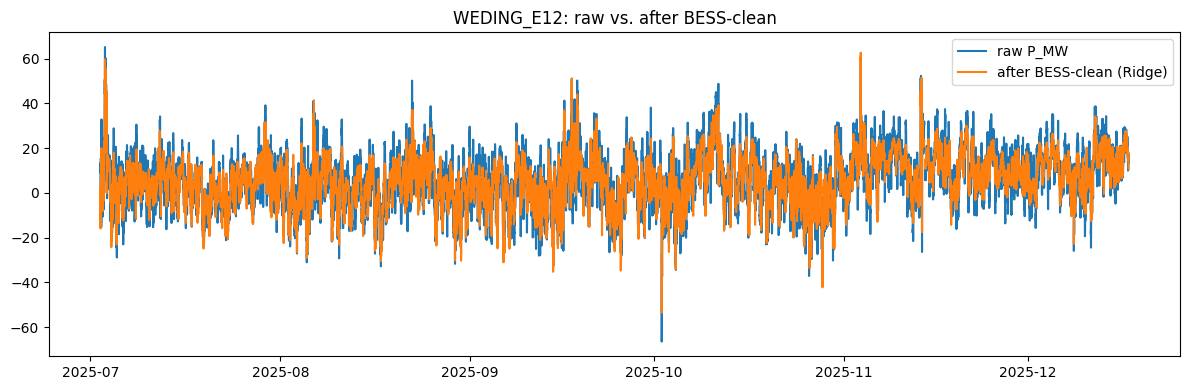

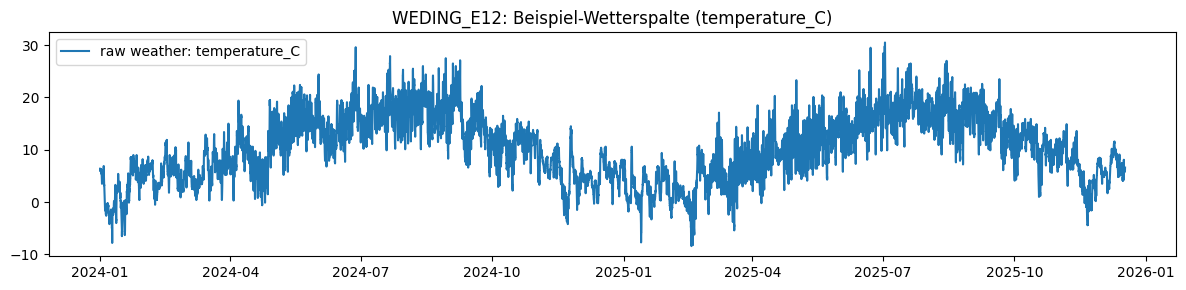

In [ ]:
import os
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.utils.logging_config import setup_logging
from src.config import RAW_TS_DIR, CLEAN_TS_DIR, FREQ
from src.data.data_cleaning import clean_data  # <-- WICHTIG: nicht nur helper importieren
from src.network.bess_cleaning import remove_bess_effects_from_csv_multi

# ---------------- Logging (wie main.py) ----------------
setup_logging(level=logging.INFO)
logger = logging.getLogger(__name__)

print("Notebook CWD:", os.getcwd())
print("RAW_TS_DIR:", RAW_TS_DIR)
print("CLEAN_TS_DIR:", CLEAN_TS_DIR)

# ---------------- 1) Rohdaten aus CSV laden (kein Scraping) ----------------
meas_dir = Path(RAW_TS_DIR)
csv_files = sorted(meas_dir.glob("*_hist.csv"))
assert len(csv_files) > 0, f"Keine *_hist.csv in {meas_dir} gefunden."

MAX_NODES = 20  # für Tests
data_measurements = {}
data_weather_hist = {}

for p in csv_files[:MAX_NODES]:
    node_id = p.stem.replace("_hist", "")
    df = pd.read_csv(p, parse_dates=["timestamp"]).sort_values("timestamp").set_index("timestamp")

    if "P_MW" not in df.columns:
        logger.warning("Skip %s: keine Spalte P_MW", p.name)
        continue

    # main.py-analog: measurements als Series
    data_measurements[node_id] = df["P_MW"].astype(float)

    # weather_hist als DataFrame (falls vorhanden)
    weather_cols = [c for c in df.columns if c != "P_MW"]
    if weather_cols:
        data_weather_hist[node_id] = df[weather_cols].copy()
    else:
        data_weather_hist[node_id] = pd.DataFrame(index=df.index)

logger.info("Geladen: %d Nodes (measurements)", len(data_measurements))
logger.info("Geladen: %d Nodes (weather_hist)", len(data_weather_hist))

# forecast lassen wir hier leer (weil „kein Scraping“)
data = {
    "nodes": [],  # optional, clean_data nutzt es nur zum Durchreichen
    "measurements": data_measurements,
    "weather_hist": data_weather_hist,
    "weather_forecast": {},
}

# ---------------- 2) Data Cleaning (GENAU über clean_data) ----------------
data_clean = clean_data(data)  # schreibt logs/data_coverage_report.csv (wenn du die angepasste Datei nutzt)

# Coverage-Report prüfen
report_path = Path("logs") / "data_coverage_report.csv"
print("\nCoverage report exists:", report_path.exists(), "->", report_path.resolve())

if report_path.exists():
    cov = pd.read_csv(report_path)
    print("\nTop 10 niedrigste Coverage:")
    display(cov.sort_values("coverage_pct", ascending=True).head(10))

    print("\nTop 10 größte NaN-Blöcke:")
    display(cov.sort_values("max_nan_block_steps", ascending=False).head(10))

# Kurzsummary nach Cleaning
def summarize_series(s: pd.Series) -> dict:
    return {
        "start": s.index.min(),
        "end": s.index.max(),
        "n": len(s),
        "nan": int(s.isna().sum()),
        "coverage_pct": round(100.0 * (1.0 - s.isna().mean()), 3),
        "first_valid": s.first_valid_index(),
        "last_valid": s.last_valid_index(),
    }

summary_df = pd.DataFrame(
    [{"node_id": k, **summarize_series(v)} for k, v in data_clean["measurements"].items()]
).sort_values("coverage_pct", ascending=True)

print("\n--- Summary cleaned measurements (worst coverage first) ---")
display(summary_df.head(10))

# ---------------- 3) BESS Cleaning (Ridge) wie in der Pipeline ----------------
BESS_FILES = ["BOLS_E41_hist.csv", "BOLS_E42_hist.csv"]  # <- ggf. anpassen

clean_bess_dict, bess_report = remove_bess_effects_from_csv_multi(
    bess_files=BESS_FILES,
    ts_col="timestamp",
    val_col="P_MW",
    min_overlap_points=200,
    out_dir=None,    # => CLEAN_TS_DIR
    ridge_alpha=1.0,
)

logger.info("BESS-clean fertig. Output in: %s", CLEAN_TS_DIR)
display(bess_report.head(10))

# ---------------- 4) Plot: raw vs. cleaned (no_bess) für Beispielnode ----------------
if not bess_report.empty:
    example_node = bess_report.iloc[0]["node_id"]

    # raw (aus CSV, inkl. Wetter)
    p = meas_dir / f"{example_node}_hist.csv"
    df_raw = pd.read_csv(p, parse_dates=["timestamp"]).sort_values("timestamp").set_index("timestamp")

    y_raw = df_raw["P_MW"].astype(float)
    y_clean_bess = clean_bess_dict[example_node]

    plt.figure(figsize=(12,4))
    plt.plot(y_raw.index, y_raw, label="raw P_MW")
    plt.plot(y_clean_bess.index, y_clean_bess, label="after BESS-clean (Ridge)")
    plt.title(f"{example_node}: raw vs. after BESS-clean")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # optional: Wetter mit anzeigen (falls vorhanden)
    weather_cols = [c for c in df_raw.columns if c != "P_MW"]
    if weather_cols:
        col = weather_cols[0]
        plt.figure(figsize=(12,3))
        plt.plot(df_raw.index, df_raw[col], label=f"raw weather: {col}")
        plt.title(f"{example_node}: Beispiel-Wetterspalte ({col})")
        plt.legend()
        plt.tight_layout()
        plt.show()
else:
    print("BESS-Report ist leer – evtl. falsche BESS_FILES oder min_overlap_points zu hoch.")


In [ ]:
from src.data.eiot_client import _load_eiot_token
import logging

logging.getLogger("src.data.eiot_client").setLevel(logging.INFO)

try:
    token = _load_eiot_token()
    print("Token erfolgreich geladen. Länge:", len(token))
    print("Token (Anfang):", token[:50], "...")
except Exception as e:
    print("Fehler beim Laden des Tokens:", repr(e))


Token erfolgreich geladen. Länge: 1250
Token (Anfang): eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiIsImtpZCI6InJ0c0 ...


In [ ]:
from datetime import datetime, timezone, timedelta
from src.data.eiot_client import fetch_datapoint_raw

dp_id = "7b3fec1d-2c6f-4450-b41a-74d709e1c3b6"  # eine gültige ID einsetzen
start = datetime.now(timezone.utc) - timedelta(hours=1)
end = datetime.now(timezone.utc)

try:
    resp = fetch_datapoint_raw(
        datapoint_id=dp_id,
        start_time=start,
        end_time=end,
        aggregation="AVG",
        bucket_factor=15,
        bucket_unit="MINUTE",
        timezone_str="Europe/Berlin",
        chunk_days=1,
    )
    print("OK, Samples:", len(resp.get("samples", [])))
except Exception as e:
    print("Fehler beim EIOT-Request:", repr(e))


OK, Samples: 4


In [ ]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from datetime import datetime, timezone
import logging
import pandas as pd

from src.data.data_loader import load_all_data

# Logging hochdrehen (optional)
logging.getLogger("src.data").setLevel(logging.INFO)
logging.getLogger("src.data.data_loader").setLevel(logging.INFO)
logging.getLogger("src.data.eiot_client").setLevel(logging.INFO)
logging.getLogger("src.data.weather_loader").setLevel(logging.INFO)

# --- Zeitraum für Wetter definieren: 01.01.2024 bis jetzt ---

tz = "Europe/Berlin"
now = pd.Timestamp.now(tz=tz)              # entspricht dem 'now' in fetch_weather_open_meteo
start_weather = pd.Timestamp("2024-01-01 00:00", tz=tz)

past_hours = int((now - start_weather).total_seconds() // 3600) + 1

print(f"Wetter-Historie: von {start_weather} bis {now}")
print(f"-> weather_past_hours = {past_hours}")

print("Starte Datenladen ...")

data = load_all_data(
    weather_forecast_hours=24,   # oder 0, wenn du keinen Forecast brauchst
)


print("FERTIG.\n")

print("Geladene Nodes:")
print(data["nodes"].index.tolist())

print("\nNodes mit Messwerten:")
print(list(data["measurements"].keys()))

if data["measurements"]:
    first = next(iter(data["measurements"].keys()))
    print("\nBeispiel für ersten Node:", first)
    print(data["measurements"][first].head())
    print(data["measurements"][first].tail())


Wetter-Historie: von 2024-01-01 00:00:00+01:00 bis 2025-12-10 12:45:03.237956+01:00
-> weather_past_hours = 17029
Starte Datenladen ...


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s_old, s_new])
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s_old, s_new])
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a 

FERTIG.

Geladene Nodes:
['SHUW_E24', 'SHUW_E23', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02', 'BOLN_E02', 'BOLN_E03', 'BOLN_E01', 'BOLS_E42', 'BOLS_E41']

Nodes mit Messwerten:
['SHUW_E24', 'SHUW_E23', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02', 'BOLN_E03', 'BOLN_E01', 'BOLS_E42', 'BOLS_E41', 'JUBO_E01', 'BOLN_E02']

Beispiel für ersten Node: SHUW_E24
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Name: P_MW, dtype: float64
2025-12-10 11:30:00   NaN
2025-12-10 11:45:00   NaN
2025-12-10 12:00:00   NaN
2025-12-10 12:15:00   NaN
2025-12-10 12:30:00   NaN
Name: P_MW, dtype: float64


### Test data cleaning

In [ ]:
from src.data.data_loader import load_all_data
from src.data.data_cleaning import clean_data

# 1) Rohdaten laden
raw = load_all_data()

print(
    "Nodes:", len(raw["nodes"]),
    "| Messreihen:", len(raw["measurements"]),
    "| Wetter-Hist:", len(raw["weather_hist"]),
)

# 2) Bereinigung
clean = clean_data(raw)

print(
    "Clean-Messreihen:", len(clean["measurements"]),
    "| Clean-Wetter-Hist:", len(clean["weather_hist"]),
)


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'historical-forecast-api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made t

Nodes: 16 | Messreihen: 16 | Wetter-Hist: 16
Clean-Messreihen: 16 | Clean-Wetter-Hist: 16


In [3]:
# Einen beliebigen Node nehmen, der Messwerte hat
node_id = next(iter(raw["measurements"].keys()))
print("Teste Node:", node_id)

s_raw = raw["measurements"][node_id]
s_clean = clean["measurements"][node_id]

print("\nRAW P_MW head:")
print(s_raw.head())

print("\nCLEAN P_MW head:")
print(s_clean.head())

print("\nRAW Zeitspanne:", s_raw.index.min(), "→", s_raw.index.max())
print("CLEAN Zeitspanne:", s_clean.index.min(), "→", s_clean.index.max())

print("\nNaNs P_MW (raw → clean):",
      s_raw.isna().sum(), "→", s_clean.isna().sum())


Teste Node: SHUW_E24

RAW P_MW head:
timestamp
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Name: P_MW, dtype: float64

CLEAN P_MW head:
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Freq: 15min, Name: P_MW, dtype: float64

RAW Zeitspanne: 2024-01-01 00:00:00 → 2025-12-07 17:15:00
CLEAN Zeitspanne: 2024-01-01 00:00:00 → 2025-12-07 17:15:00

NaNs P_MW (raw → clean): 2364 → 2089


In [4]:
weather_cols = ["temperature_C", "wind_speed_mps", "solar_radiation_Wm2"]

if node_id in raw["weather_hist"]:
    w_raw = raw["weather_hist"][node_id]
    w_clean = clean["weather_hist"][node_id]

    print("\nRAW Wetter head:")
    print(w_raw[weather_cols].head())

    print("\nCLEAN Wetter head:")
    print(w_clean[weather_cols].head())

    print("\nNaNs Wetter (raw → clean):")
    for col in weather_cols:
        if col in w_raw.columns:
            print(
                col,
                ":", w_raw[col].isna().sum(),
                "→", w_clean[col].isna().sum()
            )
else:
    print("Keine Wetterdaten für Node", node_id)



RAW Wetter head:
                     temperature_C  wind_speed_mps  solar_radiation_Wm2
time                                                                   
2024-01-01 01:00:00            6.6            17.7                  0.0
2024-01-01 01:15:00            6.6            17.4                  0.0
2024-01-01 01:30:00            6.5            17.1                  0.0
2024-01-01 01:45:00            6.4            16.9                  0.0
2024-01-01 02:00:00            6.3            16.5                  0.0

CLEAN Wetter head:
                     temperature_C  wind_speed_mps  solar_radiation_Wm2
2024-01-01 01:00:00            6.6            17.7                  0.0
2024-01-01 01:15:00            6.6            17.4                  0.0
2024-01-01 01:30:00            6.5            17.1                  0.0
2024-01-01 01:45:00            6.4            16.9                  0.0
2024-01-01 02:00:00            6.3            16.5                  0.0

NaNs Wetter (raw → clean)

In [1]:
from src.main import main
print("go")
res = main(run_full_pipeline=False)

raw = res["raw"]
clean = res["clean"]

node_id = next(iter(raw["measurements"].keys()))
print("Node:", node_id)
print(clean["measurements"][node_id].head())


2025-12-07 21:00:19 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-07 21:00:19 [INFO] src.main - Starte Leistungsband-Service...


go


2025-12-07 21:00:24 [INFO] src.data.data_loader - Starte Laden der historischen Wirkleistungs- und Wetterdaten (global_start_local=2024-01-01 01:00:00+01:00, end_local=2025-12-07 21:00:24.540540+01:00, global_start_utc=2024-01-01 00:00:00+00:00, end_time_utc=2025-12-07 20:00:24.540540+00:00) ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Lade Knotendaten (inkl. P_Datapoint_ID, Lat/Lon, DerivedSpec) aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Knotendaten geladen: 16 Knoten.
2025-12-07 21:00:24 [INFO] src.data.data_loader - Verarbeite Node SHUW_E24 (DP=97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380) ...
2025-12-07 21:00:24 [INFO] src.data.data_loader - Gefundene bestehende Hist-Daten für SHUW_E24: von 2024-01-01 00:00:00 bis 2025-12-07 17:45:00 (Zeilen: 67848)
2025-12-07 21:00:24 [INFO] src.data.data_loader - Node SHUW_E24: vorhandene Daten bis 2025-12-07 17:45:00 (loc

Node: SHUW_E24
2024-01-01 00:00:00   -22.996800
2024-01-01 00:15:00   -23.516007
2024-01-01 00:30:00   -23.192500
2024-01-01 00:45:00   -22.885967
2024-01-01 01:00:00   -24.715713
Freq: 15min, Name: P_MW, dtype: float64


## Graph Stuff

In [ ]:
# ================================================
# Test des Netzmodells & Konsistenzchecks
# ================================================

from src.alt.network_model import load_network_model
from src.utils.logging_config import setup_logging

import numpy as np
import pandas as pd

setup_logging()

# ------------------------------------------------
# Netzmodell laden
# ------------------------------------------------
net = load_network_model()  # optional: load_network_model(slack_node="SHUW_E24")

print("---- Netzmodell Überblick ----")
print("Anzahl Knoten:", len(net.nodes))
print("Anzahl Leitungen:", len(net.lines))
print("Shape A (lines x nodes):", net.A.shape)
print("Shape Bbus (nodes x nodes):", net.Bbus.shape)
print("Slack-Knoten:", net.slack_node)
print("Shape Ar:", net.Ar.shape)
print("Shape B_rr:", net.B_rr.shape)

print("\n---- Beispiel: Nodes ----")
display(net.nodes.head())

print("\n---- Beispiel: Leitungen ----")
# Wir haben Limits nur in Ampere, keine MW-Limits und keine Längen mehr im Modell notwendig
cols_to_show = [c for c in ["from_node", "to_node", "x", "b", "limit_a"] if c in net.lines.columns]
display(net.lines[cols_to_show].head())


# ================================================
# Konsistenzcheck 1: Bbus Symmetrie
# ================================================
B = net.Bbus.values
print("\nSymmetriecheck Bbus:")
sym_diff = np.abs(B - B.T).max()
print("max |B - B^T| =", sym_diff)

# ================================================
# Konsistenzcheck 2: Spaltensummen von Bbus
# ================================================
col_sums = B.sum(axis=0)
print("max |Spaltensumme(Bbus)| =", np.abs(col_sums).max())

# ================================================
# Konsistenzcheck 3: Rang von B_rr
# ================================================
rank_B_rr = np.linalg.matrix_rank(net.B_rr.values)
print("Rang von B_rr:", rank_B_rr, "von", net.B_rr.shape[0])


# ================================================
# Konsistenzcheck 4: Reaktanzen – aber Busbar-Leitungen ausnehmen
# ================================================
print("\n---- Reaktanz-Check (nur Nicht-Busbar-Leitungen) ----")

# Debug: Welche Typen gibt es überhaupt?
if "type" in net.nodes.columns:
    print("Verfügbare Node-Typen und Häufigkeit:")
    print(net.nodes["type"].value_counts())
else:
    print("Warnung: net.nodes hat keine Spalte 'type'. Busbars können dann nicht erkannt werden.")
    
# Busbar-Knoten bestimmen (falls 'type' vorhanden)
if "type" in net.nodes.columns:
    # Annahme: Index von net.nodes ist die Node-ID (z.B. 'SHUW', 'SHUW_E24', ...)
    busbar_nodes = set(net.nodes.index[net.nodes["type"] == "busbar"])
else:
    busbar_nodes = set()

print("\nAnzahl erkannter Sammelschienen (busbar_nodes):", len(busbar_nodes))
if len(busbar_nodes) > 0:
    print("Beispiel Busbar-Nodes:", list(sorted(busbar_nodes))[:10])

# Falls 'x' nicht existiert, abbrechen
if "x" not in net.lines.columns:
    print("Spalte 'x' in net.lines nicht gefunden – kein Reaktanz-Check möglich.")
else:
    # 1) Leitungen mit fehlender oder 0-Reaktanz
    is_missing_x = net.lines["x"].isna() | (net.lines["x"] == 0)

    # 2) Leitungen, die an eine Sammelschiene angeschlossen sind:
    #    -> from_node ODER to_node ist in busbar_nodes
    if busbar_nodes:
        connected_to_busbar = (
            net.lines["from_node"].isin(busbar_nodes)
            | net.lines["to_node"].isin(busbar_nodes)
        )
    else:
        # Keine Busbars bekannt -> alle False
        connected_to_busbar = pd.Series(False, index=net.lines.index)

    # 3) Wirkliche Problem-Leitungen:
    #    fehlende/0 Reaktanz UND NICHT an Busbar angeschlossen
    problem_lines = net.lines[is_missing_x & ~connected_to_busbar]

    print(f"Gesamtzahl Leitungen mit fehlender/0 Reaktanz: {int(is_missing_x.sum())}")
    print(f"...davon direkt an Sammelschienen angeschlossen: {int((is_missing_x & connected_to_busbar).sum())}")
    print(f"...übrig (relevant zu prüfen): {len(problem_lines)}")

    if len(problem_lines) > 0:
        print("\nLeitungen mit fehlender/0 Reaktanz (ohne Busbar-Anschluss):")
        cols_show = [c for c in ["from_node", "to_node", "x", "limit_a"] if c in problem_lines.columns]
        display(problem_lines[cols_show].head(20))
    else:
        print("✅ Alle relevanten (Nicht-Busbar-)Leitungen haben eine gültige Reaktanz.")


print("\nNetzmodell-Test abgeschlossen.")


2025-12-08 12:32:40 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 12:32:40 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 12:32:40 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 12:32:40 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung TARP_SS_TARP_E01 (Tarp -> Tarp_E01) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 12:32:40 [WARNING] src.network.network_model - Leitung JUBO_E03_JUBO (JUBO -> JUBO_E03) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird

---- Netzmodell Überblick ----
Anzahl Knoten: 29
Anzahl Leitungen: 6
Shape A (lines x nodes): (6, 29)
Shape Bbus (nodes x nodes): (29, 29)
Slack-Knoten: BOLN_E01
Shape Ar: (6, 28)
Shape B_rr: (28, 28)

---- Beispiel: Nodes ----


,label,type,pos_x,pos_y,P_Datapoint_ID,Q_Datapoint_ID,Windgeschw_Datapoint,Globale_Strahlung_Datapoint,Aussentemp_Datapoint,Latitude_deg,Longitude_deg,Strom_Limit_in_A,DAB_ID,busbar_id,derived,p_max_MW
id,,,,,,,,,,,,,,,,
BOLN,BOLN,busbar,850.387134,0.010577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOLN_A3,BOLN_A3,junction,619.655071,-1.172015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOLN_E01,BOLN_E01,uw_field,990.284389,40.972400,34482f6c-cbbc-4f7f-99ae-db73a5885eb9,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,SHNG_E:DSO:SHN:ST:STUW45210:SA:110:SF:E01,NaN,NaN,NaN
BOLN_E02,BOLN_E02,uw_field,714.233866,-4.270225,NaN,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,NaN,"BOLN_E03:-1, BOLN_E02:-1","{'method': 'field_sum', 'feature_key': 'P', 't...",NaN
BOLN_E03,BOLN_E03,uw_field,984.103815,-35.689258,bf40c502-ea38-4eca-986a-11fa618c97f1,NaN,360b2dc9-834a-42d6-8653-2630cbdcfb38,2ed62708-3221-400f-b30e-6bf21798b4c5,6a4f03f6-17a7-40d1-96cb-483e4a7c2ad1,54.615976,9.449164,NaN,SHNG_E:DSO:SHN:ST:STUW45210:SA:110:SF:E03,NaN,NaN,NaN



---- Beispiel: Leitungen ----


,from_node,to_node,x,b,limit_a
id,,,,,
110_SHUW_TARP_GELB_JUBO_BOLS_A5_BOLS,BOLS_A5,BOLS_E42,0.000040,25062.656642,547.0
110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,Tarp_E01,BOLS_A5,69.101054,0.014472,547.0
110_SHUW_TARP_GELB_JUBO_JUBO_A5_BOLS_A5,BOLS_A5,JUBO_A5,11.403285,0.087694,555.0
110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,JUBO_A5,JUBO_E01,4.990608,0.200376,632.0
110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5,SHUW_E24,JUBO_A5,1.626966,0.614641,1435.0



Symmetriecheck Bbus:
max |B - B^T| = 0.0
max |Spaltensumme(Bbus)| = 1.477965319574004e-12
Rang von B_rr: 6 von 28

---- Reaktanz-Check (nur Nicht-Busbar-Leitungen) ----
Verfügbare Node-Typen und Häufigkeit:
type
uw_field    14
busbar       7
junction     6
battery      2
Name: count, dtype: int64

Anzahl erkannter Sammelschienen (busbar_nodes): 7
Beispiel Busbar-Nodes: ['BOLN', 'JUBO', 'SHUW', 'SIES', 'SIEV', 'Tarp', 'Weding']
Gesamtzahl Leitungen mit fehlender/0 Reaktanz: 0
...davon direkt an Sammelschienen angeschlossen: 0
...übrig (relevant zu prüfen): 0
✅ Alle relevanten (Nicht-Busbar-)Leitungen haben eine gültige Reaktanz.

Netzmodell-Test abgeschlossen.


In [13]:
# ============================================================
# Überblick über whole_graph.json + Kanten ohne Reaktanz
# (ohne direkte Verbindung zu einer Sammelschiene)
# ============================================================

import json
import pandas as pd
from src.config import GRAPH_PATH

try:
    from IPython.display import display
except ImportError:
    display = print

# -------------------------
# 1) JSON einlesen
# -------------------------
with open(GRAPH_PATH, "r", encoding="utf-8") as f:
    elems = json.load(f)

nodes = [e for e in elems if "data" in e and "source" not in e["data"]]
edges = [e for e in elems if "data" in e and "source" in e["data"]]

print("==== GROBER ÜBERBLICK ====")
print(f"Anzahl Knoten im JSON: {len(nodes)}")
print(f"Anzahl Kanten im JSON: {len(edges)}\n")

# -------------------------
# 2) Knotentypen auswerten
# -------------------------
node_info = []
for e in nodes:
    d = e["data"]
    node_info.append({
        "id": d["id"],
        "label": d.get("label", d["id"]),
        "type": d.get("type", None)
    })

df_nodes = pd.DataFrame(node_info)

print("Knotentypen im JSON:")
print(df_nodes["type"].value_counts())
print("\nBeispiel-Knoten:")
display(df_nodes.head(10))

# Mapping ID -> Typ
node_type_map = df_nodes.set_index("id")["type"].to_dict()

# -------------------------
# 3) Kanten grob anzeigen
# -------------------------
edge_info = []
for e in edges:
    d = e["data"]
    feats = d.get("features", {}) or {}
    edge_info.append({
        "id": d.get("id"),
        "label": d.get("label"),
        "source": d.get("source"),
        "target": d.get("target"),
        "source_type": node_type_map.get(d.get("source")),
        "target_type": node_type_map.get(d.get("target")),
        "has_X_total_ohm": feats.get("X_total_ohm") is not None,
        "has_X_ohm_per_km": feats.get("X_ohm_per_km") is not None,
        "strom_limit_a": feats.get("Strom_Limit_in_A"),
    })

df_edges = pd.DataFrame(edge_info)

print("\nBeispiel-Kanten:")
display(df_edges.head(20))

# -------------------------
# 4) Kanten ohne Reaktanz
#    UND nicht an Sammelschiene
# -------------------------

def has_reactance(row):
    return bool(row["has_X_total_ohm"] or row["has_X_ohm_per_km"])

def touches_busbar(row):
    return (row["source_type"] == "busbar") or (row["target_type"] == "busbar")

mask_no_x_and_no_bus = (~df_edges.apply(has_reactance, axis=1)) & (~df_edges.apply(touches_busbar, axis=1))

df_edges_problem = df_edges[mask_no_x_and_no_bus].copy()

print("\n==== KANTEN OHNE REAKTANZ (UND NICHT AN SAMMELSCHIENE) ====")
print(f"Anzahl solcher Kanten: {len(df_edges_problem)}")

if len(df_edges_problem) > 0:
    display(df_edges_problem[[
        "id", "label", "source", "source_type", "target", "target_type", "strom_limit_a"
    ]])
else:
    print("Keine Kanten gefunden, die die Kriterien erfüllen.")


==== GROBER ÜBERBLICK ====
Anzahl Knoten im JSON: 29
Anzahl Kanten im JSON: 29

Knotentypen im JSON:
type
uw_field    14
busbar       7
junction     6
battery      2
Name: count, dtype: int64

Beispiel-Knoten:


,id,label,type
0,WEDING,WEDING,busbar
1,TARP,TARP,busbar
2,JUBO,JUBO,busbar
3,SHUW,SHUW,busbar
4,BOLN,BOLN,busbar
5,SIES,SIES,busbar
6,SIEV,SIEV,busbar
7,SHUW_E24,SHUW_E24,uw_field
8,SHUW_E23,SHUW_E23,uw_field
9,JUBO_E01,JUBO_E01,uw_field



Beispiel-Kanten:


,id,label,source,target,source_type,target_type,has_X_total_ohm,has_X_ohm_per_km,strom_limit_a
0,SHUW_SS_E23,SHUW_SS_E23,SHUW,SHUW_E23,busbar,uw_field,False,False,NaN
1,SHUW_SS_E24,SHUW_SS_E24,SHUW,SHUW_E24,busbar,uw_field,False,False,NaN
2,JUBO_E01_JUBO,JUBO_E01_JUBO,JUBO,JUBO_E01,busbar,uw_field,False,False,NaN
3,JUBO_E02_JUBO,JUBO_E02_JUBO,JUBO_E02,JUBO,uw_field,busbar,False,False,NaN
4,JUBO_E03_JUBO,JUBO_E03_JUBO,JUBO_E03,JUBO,uw_field,busbar,False,False,NaN
5,TARP_SS_TARP_E01,TARP_SS_TARP_E01,TARP_E01,TARP,uw_field,busbar,False,False,NaN
6,TARP_SS_TARP_E03,TARP_SS_TARP_E03,TARP,TARP_E03,busbar,uw_field,False,False,NaN
7,WEDING_SS_WEDING_E14,WEDING_SS_WEDING_E14,WEDING_E14,WEDING,uw_field,busbar,False,False,NaN
8,WEDING_SS_WEDING_E12,WEDING_SS_WEDING_E12,WEDING_E12,WEDING,uw_field,busbar,False,False,NaN
9,SIEV_SS_E01,SIEV_SS_E01,SIEV_E01,SIEV,uw_field,busbar,False,False,NaN



==== KANTEN OHNE REAKTANZ (UND NICHT AN SAMMELSCHIENE) ====
Anzahl solcher Kanten: 0
Keine Kanten gefunden, die die Kriterien erfüllen.


2025-12-08 14:56:21 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 14:56:21 [INFO] src.main - Starte Leistungsband-Service...
2025-12-08 14:56:26 [INFO] src.data.data_loader - Starte Laden der historischen Wirkleistungs- und Wetterdaten (global_start_local=2024-01-01 01:00:00+01:00, end_local=2025-12-08 14:56:26.962931+01:00, global_start_utc=2024-01-01 00:00:00+00:00, end_time_utc=2025-12-08 13:56:26.962931+00:00) ...
2025-12-08 14:56:26 [INFO] src.data.data_loader - Lade Knotendaten (inkl. P_Datapoint_ID, Lat/Lon, DerivedSpec) aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 14:56:27 [INFO] src.data.data_loader - Knotendaten geladen: 16 Knoten.
2025-12-08 14:56:27 [INFO] src.data.data_loader - Verarbeite Node SHUW_E24 (DP=97f72ae3-8fe4-4ef6-a3f6-5f58b2ec2380) ...
2025-12-08 14:56:27 [INFO] src.data.data_loader - Gefundene bestehende Hist-Daten für SHUW_E24: v

Anzahl Knoten mit Messwerten: 16

--- Top-10 Knoten nach total_abs_MWh (|P| integriert) ---


,mean_P_MW,max_P_MW,min_P_MW,mean_abs_P_MW,total_abs_MWh
node,,,,,
SHUW_E24,-39.189179,142.890660,-195.637267,39.587152,651594.627204
SHUW_E23,-27.439614,427.740991,-150.303600,28.108969,451050.578043
TARP_E01,20.221529,171.666667,-27.266667,20.541204,347726.633089
JUBO_E01,19.442366,85.655653,-61.828244,19.488763,330958.166261
JUBO_E02,-13.431515,7.473509,-57.498167,13.435589,222298.540740
TARP_E03,4.032331,208.333333,-72.506533,11.303670,191385.265393
BOLN_E03,-10.227046,0.089329,-43.940660,10.241748,168597.092347
BOLN_E02,9.875853,43.940660,-0.089329,9.890040,167952.659703
SIEV_E01,-6.899070,0.295629,-62.488713,7.099736,113457.333501



→ Knoten mit größtem Durchsatz (total_abs_MWh): SHUW_E24
mean_P_MW           -39.189179
max_P_MW            142.890660
min_P_MW           -195.637267
mean_abs_P_MW        39.587152
total_abs_MWh    651594.627204
Name: SHUW_E24, dtype: float64


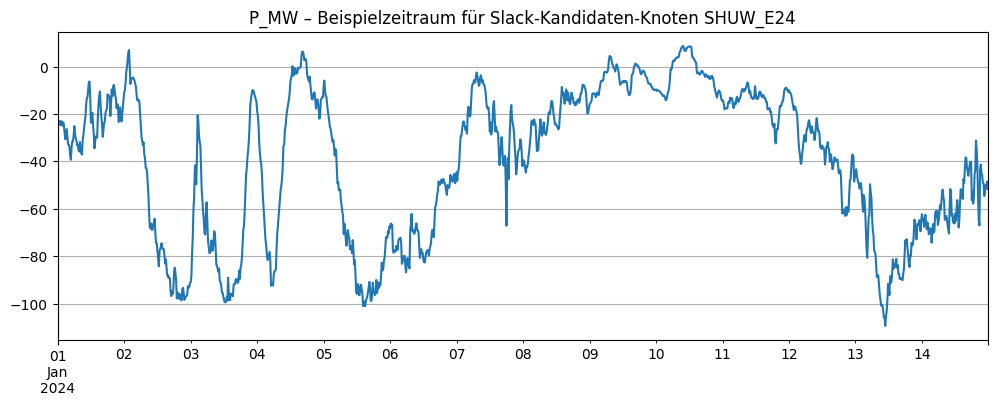

In [14]:
# ===============================================================
# Slack-Kandidaten: Knoten mit „meistem Durchsatz“
# Basis: historische Leistungswerte P_MW aus clean["measurements"]
# ===============================================================

from src.main import main
import pandas as pd
import numpy as np

# ---------------------------------------------------------------
# 1) Daten laden
# ---------------------------------------------------------------
res = main(run_full_pipeline=False)
clean = res["clean"]

meas = clean["measurements"]  # dict: node_id -> Series (P_MW)
print(f"Anzahl Knoten mit Messwerten: {len(meas)}")

# Zeitauflösung (15min -> 0.25 h)
HOURS_PER_STEP = 0.25  # 15 Minuten

# ---------------------------------------------------------------
# 2) Kennzahlen je Knoten berechnen
#    - mean_P_MW: mittlere Wirkleistung (kann + / - sein)
#    - max_P_MW: maximal eingespeiste Leistung
#    - min_P_MW: maximal aufgenommene Leistung
#    - mean_abs_P_MW: mittlere |P|
#    - total_abs_MWh: Summe |P| * Δt  -> "durchgesetzte Energie"
# ---------------------------------------------------------------
stats = []

for node_id, s in meas.items():
    # NaNs raus; für unseren Zweck uninteressant
    s = s.dropna()
    if s.empty:
        continue

    mean_P = s.mean()
    max_P = s.max()
    min_P = s.min()
    mean_abs_P = s.abs().mean()
    total_abs_MWh = s.abs().sum() * HOURS_PER_STEP

    stats.append(
        {
            "node": node_id,
            "mean_P_MW": mean_P,
            "max_P_MW": max_P,
            "min_P_MW": min_P,
            "mean_abs_P_MW": mean_abs_P,
            "total_abs_MWh": total_abs_MWh,
        }
    )

df_nodes = pd.DataFrame(stats).set_index("node")

# ---------------------------------------------------------------
# 3) Ranking nach "Durchsatz" (integrierte |P| in MWh)
# ---------------------------------------------------------------
df_sorted = df_nodes.sort_values("total_abs_MWh", ascending=False)

print("\n--- Top-10 Knoten nach total_abs_MWh (|P| integriert) ---")
display(df_sorted.head(10))

best_node = df_sorted.index[0]
print(f"\n→ Knoten mit größtem Durchsatz (total_abs_MWh): {best_node}")
print(df_sorted.loc[best_node])

# Optional: Wenn du dir diesen Knoten noch einmal zeitlich anschauen willst
import matplotlib.pyplot as plt

s_best = meas[best_node]

plt.figure(figsize=(12, 4))
s_best["2024-01-01":"2024-01-14"].plot()
plt.title(f"P_MW – Beispielzeitraum für Slack-Kandidaten-Knoten {best_node}")
plt.grid(True)
plt.show()


In [ ]:
from src.alt.network_model import load_network_model

net = load_network_model()

best_node = df_sorted.index[0]  # dein Top-Durchsatz-Knoten aus der vorherigen Auswertung

# Kandidaten-Busbar suchen: alle Kanten, die best_node berühren
adj_edges = net.lines[
    (net.lines["from_node"] == best_node) | (net.lines["to_node"] == best_node)
]

# Knoten-Tabelle (mit Spalte 'type')
nodes_df = net.nodes  # index = node_id, col 'type'

busbar_candidates = set()

for _, e in adj_edges.iterrows():
    other = e["to_node"] if e["from_node"] == best_node else e["from_node"]
    if nodes_df.loc[other, "type"] == "busbar":
        busbar_candidates.add(other)

if len(busbar_candidates) == 1:
    slack_node = list(busbar_candidates)[0]
    print(f"Slack-Knoten: Sammelschiene {slack_node} (verbunden mit {best_node})")
elif len(busbar_candidates) > 1:
    print("Mehrere Busbars angrenzend, bitte eine auswählen:", busbar_candidates)
    slack_node = best_node  # Fallback-Regel
else:
    slack_node = best_node
    print(f"Keine Busbar angrenzend – nutze direkt {best_node} als Slack.")

# slack_node kannst du dann an load_network_model(slack_node=...) übergeben


2025-12-08 15:08:39 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 15:08:39 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 15:08:39 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm/X_ohm_per_km) – wird vorerst übersprungen.
2025-12-08 15:08:39 [WARNING] src.network.network_model - Leitung JUBO_E02_JUBO (JUBO

Keine Busbar angrenzend – nutze direkt SHUW_E24 als Slack.


In [ ]:
from src.utils.logging_config import setup_logging
from src.alt.network_model import load_network_model

setup_logging()

net = load_network_model()   # nutzt jetzt SLACK_NODE_ID aus config

print("Slack-Knoten:", net.slack_node)
print("Nodes:", net.nodes.shape)
print("Lines:", net.lines.shape)
print("A:", net.A.shape, "Bbus:", net.Bbus.shape, "Ar:", net.Ar.shape, "B_rr:", net.B_rr.shape)


2025-12-08 15:24:29 [INFO] src.utils.logging_config - Logging initialisiert. Logfile: logs\service.log
2025-12-08 15:24:29 [INFO] src.network.network_model - Lade Netzgraph aus C:\Users\M97947\OneDrive - E.ON\Dokumente\Thesis\Code_Github\masterthesis\src\data\raw\graph\whole_graph.json ...
2025-12-08 15:24:29 [INFO] src.network.network_model - Graph geladen (Listenformat): 29 Nodes, 29 Edges.
2025-12-08 15:24:29 [INFO] src.network.network_model - Nodes-DataFrame aufgebaut: 29 Knoten (Index=id).
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-12-08 15:24:29 [WARNING] src.network.network_model - Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
2025-1

Slack-Knoten: SHUW
Nodes: (29, 12)
Lines: (15, 11)
A: (15, 29) Bbus: (29, 29) Ar: (15, 28) B_rr: (28, 28)


## PTDF

In [ ]:
from src.utils.logging_config import setup_logging
from src.alt.network_model import load_network_model
from src.alt.ptdf import compute_ptdf

setup_logging()

net = load_network_model()

H_rel = compute_ptdf(
    net,
    relevant_only=True,
    use_pinv=True,   # <--- wichtiger Parameter
)

print("Slack-Knoten:", net.slack_node)
print("PTDF-Shape:", H_rel.shape)
display(H_rel.head())


Slack-Knoten: SHUW
PTDF-Shape: (15, 16)


,BOLN_E01,BOLN_E02,BOLN_E03,BOLS_E41,BOLS_E42,JUBO_E01,JUBO_E02,JUBO_E03,SHUW_E23,SHUW_E24,SIES_E02,SIEV_E01,TARP_E01,TARP_E03,WEDING_E12,WEDING_E14
id,,,,,,,,,,,,,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",2.172407e-14,-0.9,4.862238e-15,0.1,-3.871519e-15,7.358538e-17,1.499263e-31,-7.585368e-30,0.1,1.348084e-15,0.1,0.1,-1.575023e-15,0.0,0.1,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",-3.678906e-13,-0.5,-1.430818e-14,-0.5,-3.612697e-14,-1.826330e-14,-2.335892e-30,1.385369e-27,-0.5,-1.989113e-14,0.5,0.5,-2.418675e-14,0.0,0.5,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",4.113445e-13,-0.3,2.395370e-14,0.7,2.802621e-14,1.749851e-14,2.635345e-30,-1.400529e-27,0.7,1.843532e-14,-0.3,-0.3,2.103942e-14,0.0,-0.3,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",1.406088e-13,-0.1,1.225696e-15,0.9,1.339597e-14,6.078661e-15,7.978004e-31,-3.781460e-28,-0.1,6.613231e-15,-0.1,-0.1,8.479234e-15,0.0,-0.1,0.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",1.310324e-13,-0.1,2.135084e-14,-0.1,1.291639e-15,5.438551e-15,1.039865e-30,-6.444569e-28,0.9,5.005000e-15,-0.1,-0.1,4.066276e-15,0.0,-0.1,0.0


In [ ]:
from src.alt.network_model import load_network_model
from src.alt.ptdf import compute_ptdf_full, check_ptdf_kcl, debug_single_injection

net = load_network_model()
H_full = compute_ptdf_full(net, use_pinv=True)

# 1) KCL-Check über alle Nicht-Slack-Knoten
check_ptdf_kcl(net, H_full, sample_nodes=None, tol=1e-8)

# 2) Einzel-Injektion debuggen
flows, kcl_vec = debug_single_injection(net, H_full, node_id="SHUW_E24")
display(flows.head())
display(kcl_vec)


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

id
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN       5.932523e-16
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3    5.329150e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3   -3.932672e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS      -8.645290e-15
110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3       1.302555e-14
Name: flow_per_1MW, dtype: float64

BOLN          0.000000e+00
BOLN_A3      -8.032262e-16
BOLN_E01      0.000000e+00
BOLN_E02     -5.932523e-16
BOLN_E03      0.000000e+00
BOLS_A3      -8.312935e-15
BOLS_A5      -1.666667e-01
BOLS_E41     -8.645290e-15
BOLS_E42     -1.666667e-01
JUBO          0.000000e+00
JUBO_A5      -1.666667e-01
JUBO_E01     -1.666667e-01
JUBO_E02      0.000000e+00
JUBO_E03      0.000000e+00
SHUW_E23      1.302555e-14
SHUW_E24      8.333333e-01
SIES          0.000000e+00
SIES_A3       1.317594e-15
SIES_E02      2.545127e-17
SIEV          0.000000e+00
SIEV_A3       5.554123e-15
SIEV_E01      4.476351e-15
TARP          0.000000e+00
TARP_E01     -1.666667e-01
TARP_E03      0.000000e+00
WEDING        0.000000e+00
WEDING_E12   -6.044368e-15
WEDING_E14    0.000000e+00
Name: kcl_balance, dtype: float64

### flows

In [ ]:
from pathlib import Path
import pandas as pd
import numpy as np
from src.alt.network_model import load_network_model
from src.alt.ptdf import compute_ptdf

# Netzmodell laden (Slack kommt aus config.py)
net = load_network_model()

# PTDF für relevante Knoten berechnen (uw_field + battery)
H_rel = compute_ptdf(net, relevant_only=True)

# Knoten, für die wir Zeitreihen benötigen
relevant_nodes = list(H_rel.columns)

print("Relevante Knoten:", relevant_nodes)
print("Shape H_rel:", H_rel.shape)

# --------------------------------------------------
# Pfad zu den Zeitreihen & Spaltennamen
# --------------------------------------------------
MEAS_DIR = Path("src/data/raw/timeseries")  # ggf. anpassen

# Spaltennamen in den CSV-Dateien anpassen, falls nötig
TS_COL  = "timestamp"       # Zeitstempel-Spalte
VAL_COL = "P_MW"  # Leistungs-Spalte (z.B. in MW)

print(f"MEAS_DIR: {MEAS_DIR}")
if not MEAS_DIR.exists():
    raise FileNotFoundError(f"MEAS_DIR existiert nicht: {MEAS_DIR}")

all_csv = sorted(p.name for p in MEAS_DIR.glob("*.csv"))
print(f"Gefundene CSV-Dateien: {len(all_csv)}")
for name in all_csv:
    print("-", name)


# --------------------------------------------------
# Loader: lädt <node>.csv oder <node>_hist.csv
# --------------------------------------------------
def load_series(node_id: str) -> pd.Series | None:
    """
    Lädt die Zeitreihe für einen Knoten aus
        <MEAS_DIR>/<node_id>.csv  oder
        <MEAS_DIR>/<node_id>_hist.csv

    Erwartet eine Zeitspalte TS_COL und eine Wertspalte VAL_COL.
    """
    candidates = [
        MEAS_DIR / f"{node_id}.csv",
        MEAS_DIR / f"{node_id}_hist.csv",
    ]

    path = None
    for c in candidates:
        if c.exists():
            path = c
            break

    if path is None:
        print(f"[MISS] Keine Datei für Node {node_id} gefunden (weder *.csv noch *_hist.csv).")
        return None

    df = pd.read_csv(path)
    print(f"[LOAD] {node_id}: {path.name} | Spalten = {list(df.columns)}")

    if TS_COL not in df.columns or VAL_COL not in df.columns:
        print(f"[SKIP] {path.name} hat nicht TS_COL={TS_COL} und VAL_COL={VAL_COL}.")
        return None

    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce", utc=True)
    df = df.dropna(subset=[TS_COL, VAL_COL])
    if df.empty:
        print(f"[EMPTY] {path.name} hat nach Cleaning keine gültigen Zeilen.")
        return None

    s = (
        df.set_index(TS_COL)[VAL_COL]
        .astype(float)
        .tz_convert(None)
        .sort_index()
    )
    print(f"[OK]   {node_id}: {len(s)} Punkte.")
    return s


# --------------------------------------------------
# Zeitreihen für relevante Knoten laden
# --------------------------------------------------
# Annahme: relevant_nodes kommt z.B. aus H_rel.columns
try:
    relevant_nodes = list(H_rel.columns)
except NameError:
    raise RuntimeError("relevant_nodes ist nicht definiert – typischerweise: relevant_nodes = list(H_rel.columns)")

series_dict: dict[str, pd.Series] = {}

print("\n--- Lade Zeitreihen für relevante Knoten ---")
for nid in relevant_nodes:
    s = load_series(nid)
    if s is None or s.empty:
        continue
    series_dict[nid] = s

print("\n--- Zusammenfassung ---")
print(f"Knoten mit vorhandener Zeitreihe: {len(series_dict)}")
print("Nodes:", sorted(series_dict.keys()))

if not series_dict:
    raise RuntimeError(
        "Keine Zeitreihen für relevante Knoten geladen. "
        "Prüfe MEAS_DIR, Dateinamen und Spaltennamen (TS_COL/VAL_COL)."
    )

# --------------------------------------------------
# Gemeinsame Zeitbasis (inner join)
# --------------------------------------------------
df_P = pd.concat(series_dict.values(), axis=1, join="inner")
df_P.columns = list(series_dict.keys())

print("\n---- Zeitreihen-Matrix df_P ----")
print("Gemeinsame Zeitpunkte:", len(df_P))
print("Knoten mit Messwerten:", df_P.shape[1])
display(df_P.head())


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

Relevante Knoten: ['BOLN_E01', 'BOLN_E02', 'BOLN_E03', 'BOLS_E41', 'BOLS_E42', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'SHUW_E23', 'SHUW_E24', 'SIES_E02', 'SIEV_E01', 'TARP_E01', 'TARP_E03', 'WEDING_E12', 'WEDING_E14']
Shape H_rel: (15, 16)
MEAS_DIR: src/data/raw/timeseries
Gefundene CSV-Dateien: 15
- BOLN_E01_hist.csv
- BOLN_E02_hist.csv
- BOLN_E03_hist.csv
- BOLS_E41_hist.csv
- BOLS_E42_hist.csv
- JUBO_E02_hist.csv
- JUBO_E03_hist.csv
- SHUW_E23_hist.csv
- SHUW_E24_hist.csv
- SIES_E02_hist.csv
- SIEV_E01_hist.csv
- Tarp_E01_hist.csv
- Tarp_E03_hist.csv
- Weding_E12_hist.csv
- Weding_E14_hist.csv

--- Lade Zeitreihen für relevante Knoten ---
[LOAD] BOLN_E01: BOLN_E01_hist.csv | Spalten = ['timestamp', 'P_MW', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
[OK]   BOLN_E01: 65476 Punkte.
[LOAD] BOLN_E02: BOLN_E02_hist.csv | Spalten = ['timestamp', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
[SKIP] BOLN_E02_hist.csv hat nicht TS_COL=timestamp und VAL_COL=P_MW.
[LOAD]

,BOLN_E01,BOLN_E03,BOLS_E41,BOLS_E42,JUBO_E02,JUBO_E03,SHUW_E23,SHUW_E24,SIES_E02,SIEV_E01,TARP_E01,TARP_E03,WEDING_E12,WEDING_E14
timestamp,,,,,,,,,,,,,,
2025-07-02 15:30:00,-1.060031,-2.760247,-0.049500,0.311850,-5.738144,-10.248208,-29.517407,-35.888707,-1.325459,-24.168873,20.000000,4.333333,-0.991650,-4.816350
2025-07-02 15:45:00,-3.034188,-8.116977,-0.049500,4.865847,-18.515167,-16.038347,-32.450693,-56.824393,-2.999312,-23.523267,18.266667,10.666667,-6.948147,-11.421297
2025-07-02 16:00:00,-6.074335,-18.029455,-41.334133,-5.888849,-30.232387,-14.651100,-11.311915,-62.848493,-5.405685,-27.280027,23.200000,17.066667,-4.796550,-17.250740
2025-07-02 16:15:00,-5.970118,-18.928687,-46.426060,-6.071170,-18.431800,-9.688532,-4.489510,-42.408253,-5.093024,-16.857033,21.000000,4.533333,3.598650,-4.775100
2025-07-02 16:30:00,-2.161747,-8.441539,-46.861627,18.003157,-8.771635,-6.663969,11.121135,-44.953487,-2.117162,-9.165937,11.600000,3.600000,13.472237,-3.870907


In [ ]:
from pathlib import Path
from src.alt.network_model import load_network_model
from src.alt.flows import build_flows_timeseries

net = load_network_model()  # nutzt Slack aus config.py
meas_dir = Path("src/data/raw/timeseries")

df_F, H_rel, df_P = build_flows_timeseries(
    net=net,
    meas_dir=meas_dir,
    relevant_only=True,   # nur uw_field + battery
    use_pinv=False,       # oder True, wenn du magst
)

df_F.head()


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

id,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",110-TARP-WEDI-GRUEN TARP-WEDI,110_SHUW_TARP_GELB_JUBO_BOLS_A5_BOLS,110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,110_SHUW_TARP_GELB_JUBO_JUBO_A5_BOLS_A5,110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5
timestamp,,,,,,,,,,,,,,,
2025-07-02 15:30:00,-5.605289,1.540462,-12.751040,5.555789,-23.912118,-4.279830,8.344657,18.563584,4.613639,4.574842,-2.907993,22.596143,-28.100278,2.596143,33.292564
2025-07-02 15:45:00,-6.597092,-0.485266,-12.708918,6.547592,-25.853601,-3.597780,10.680138,16.926175,-0.351055,11.043982,-10.481161,23.881980,-39.978454,5.615313,51.209080
2025-07-02 16:00:00,-9.012831,7.581893,-25.607555,-32.321302,-2.299084,-3.607146,5.038083,18.267196,4.216281,17.158703,-1.700708,30.789557,-40.079822,7.589557,55.258936
2025-07-02 16:15:00,-6.926698,16.282081,-30.135477,-39.499362,2.437188,-1.833674,-7.521710,9.930336,10.525348,4.654217,1.491266,25.579904,-28.668542,4.579904,37.828349
2025-07-02 16:30:00,-3.355135,18.964814,-25.675085,-43.506491,14.476271,-1.237973,-14.371706,5.810802,16.827372,3.735453,-20.561545,14.158388,-37.278322,2.558388,42.395098


In [2]:
import os
import pandas as pd
import numpy as np

# Pfad zum Timeseries-Ordner
MEAS_DIR = r"src/data/raw/timeseries"

TS_COL = "timestamp"
VAL_COL = "P_MW"

# -----------------------------
# 1) Batterie laden
# -----------------------------
bess_file = "BOLS_E42_hist.csv"   # oder z.B. "BOLS_A5_hist.csv"
bess_path = os.path.join(MEAS_DIR, bess_file)

bess = pd.read_csv(bess_path, parse_dates=[TS_COL])
bess = bess[[TS_COL, VAL_COL]].rename(columns={VAL_COL: "BESS_P"})
bess = bess.sort_values(TS_COL).set_index(TS_COL)


# -----------------------------
# 2) Alle anderen Nodes laden
# -----------------------------
correlations = {}

for fname in os.listdir(MEAS_DIR):
    if not fname.endswith("_hist.csv"):
        continue
    if fname == bess_file:
        continue

    path = os.path.join(MEAS_DIR, fname)
    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # gemeinsame Zeitbasis finden
    merged = bess.join(df, how="inner", rsuffix="_other")

    if len(merged) < 100:   # zu wenige Samples, überspringen
        continue

    corr = merged["BESS_P"].corr(merged[VAL_COL])
    correlations[fname.replace("_hist.csv", "")] = corr


# -----------------------------
# 3) Sortiert ausgeben
# -----------------------------
s = pd.Series(correlations).sort_values(key=np.abs, ascending=False)
print("Korrelation zwischen Batterie-P und allen anderen Knoten:")
print(s)


Korrelation zwischen Batterie-P und allen anderen Knoten:
BOLS_E41      0.940766
TARP_E01     -0.447962
SHUW_E23     -0.440713
WEDING_E12   -0.430709
WEDING_E14   -0.320049
SHUW_E24     -0.318354
TARP_E03      0.316852
SIEV_E01      0.255469
JUBO_E03      0.232275
JUBO_E01     -0.145870
JUBO_E02      0.069637
SIES_E02      0.049523
BOLN_E03     -0.049197
BOLN_E02      0.048678
BOLN_E01     -0.016657
dtype: float64


### bess-cleaning using just regression

BESS-Zeitreihe geladen: BOLS_E42_hist.csv, Samples: 68112
Korrelationen VOR Bereinigung (BESS_P vs. Node):
BOLS_E41      0.940766
TARP_E01     -0.447962
SHUW_E23     -0.440713
WEDING_E12   -0.430709
WEDING_E14   -0.320049
SHUW_E24     -0.318354
TARP_E03      0.316852
SIEV_E01      0.255469
JUBO_E03      0.232275
JUBO_E01     -0.145870
JUBO_E02      0.069637
SIES_E02      0.049523
BOLN_E03     -0.049197
BOLN_E02      0.048678
BOLN_E01     -0.016657
dtype: float64

Zusammenfassung Regression & Bereinigung:
      node  corr_before    corr_after      beta      alpha       r2  mean_abs_removed_MW  is_bess_uw_field
  BOLS_E41     0.940766  9.247196e-04  0.942776  -0.048351 0.885040            13.090777              True
  TARP_E01    -0.447962 -1.442284e-04 -0.367999  20.028707 0.796828             5.109797             False
  SHUW_E23    -0.440713 -2.745527e-04 -0.505464 -27.813207 0.751213             7.018543             False
WEDING_E12    -0.430709 -2.116053e-03 -0.273330   5.094285 0.1

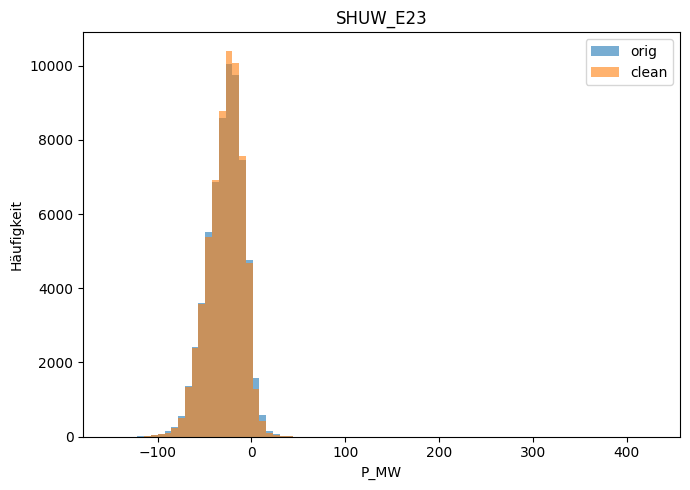

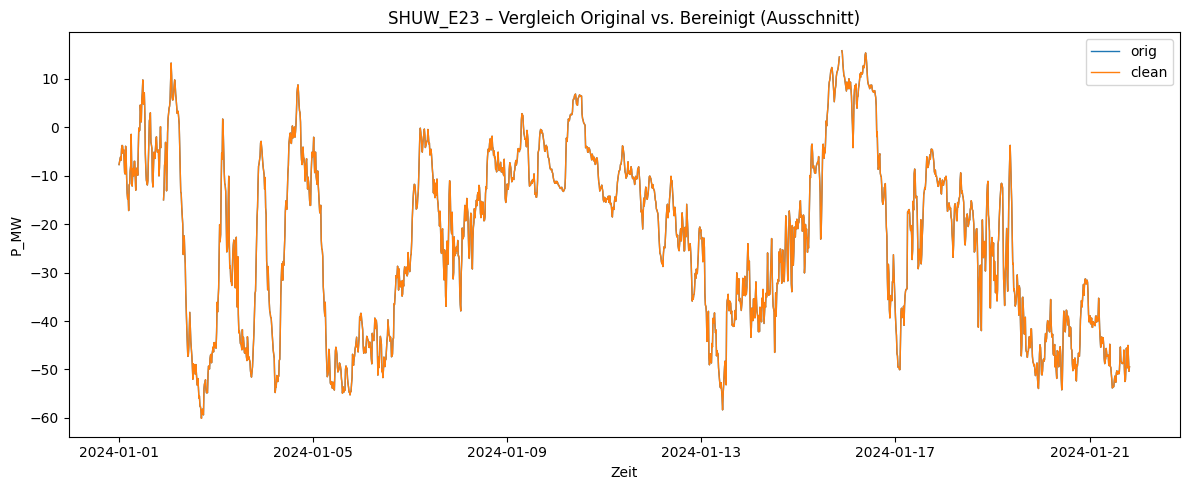

In [10]:
# %%
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ============================
# KONFIGURATION
# ============================

MEAS_DIR = r"src/data/raw/timeseries"
TS_COL = "timestamp"
VAL_COL = "P_MW"

# Datei mit BESS-Leistung
BESS_FILE = "BOLS_E42_hist.csv"

# >>> HIER SELBST PFLEGEN <<<
# Namen (ohne _hist.csv) der UW-Felder direkt am BESS-Umspannwerk
BESS_UW_FIELDS = [
    "BOLS_E41",
    "BOLS_E42",   # BESS selbst
    # "BOLS_E43",
]

# Node für Beispielplots
PLOT_NODE = "SHUW_E23"   # kannst du anpassen

# %%
# ============================
# 1) BESS laden
# ============================

bess_path = os.path.join(MEAS_DIR, BESS_FILE)

bess = pd.read_csv(bess_path, parse_dates=[TS_COL])
bess = bess[[TS_COL, VAL_COL]].rename(columns={VAL_COL: "BESS_P"})
bess = bess.sort_values(TS_COL).set_index(TS_COL)

print(f"BESS-Zeitreihe geladen: {BESS_FILE}, Samples: {len(bess)}")

# %%
# ============================
# 2) Hilfsfunktion: lineare Regression
#    y ≈ alpha + beta * x
# ============================

def fit_simple_linear_regression(x: pd.Series, y: pd.Series):
    """
    Einfache OLS-Regression:
        y ≈ alpha + beta * x

    Rückgabe:
      alpha, beta, r2
    """
    x = x.astype(float)
    y = y.astype(float)

    mx = x.mean()
    my = y.mean()

    cov_xy = ((x - mx) * (y - my)).sum()
    var_x = ((x - mx) ** 2).sum()

    if var_x == 0:
        beta = 0.0
    else:
        beta = cov_xy / var_x

    alpha = my - beta * mx

    # R^2
    y_hat = alpha + beta * x
    ss_res = ((y - y_hat) ** 2).sum()
    ss_tot = ((y - my) ** 2).sum()
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return alpha, beta, r2

# %%
# ============================
# 3) Korrelationen VOR Bereinigung
# ============================

correlations_before = {}
orig_series = {}   # komplette Original-Serien pro Node (eigener Index)

for fname in os.listdir(MEAS_DIR):
    if not fname.endswith("_hist.csv"):
        continue
    if fname == BESS_FILE:
        continue  # BESS selbst überspringen

    node_name = fname.replace("_hist.csv", "")
    path = os.path.join(MEAS_DIR, fname)

    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # Original-Zeitreihe (voll) merken
    orig_series[node_name] = df[VAL_COL]

    # Für Korrelation nur gemeinsame Zeitbasis mit BESS
    merged = bess.join(df, how="inner", rsuffix="_other")
    if len(merged) < 100:
        continue

    corr_before = merged["BESS_P"].corr(merged[VAL_COL])
    correlations_before[node_name] = corr_before

print("Korrelationen VOR Bereinigung (BESS_P vs. Node):")
s_before = pd.Series(correlations_before).sort_values(key=np.abs, ascending=False)
print(s_before)

# %%
# ============================
# 4) Regression + Bereinigung auf voller Node-Zeitreihe
#    P_node_clean(t) = P_node(t) - beta * P_BESS(t)
#    BESS-Werte, die fehlen -> 0  (dort keine Korrektur)
# ============================

results = []
clean_series = {}

for node_name, corr_before in correlations_before.items():
    fname = f"{node_name}_hist.csv"
    path = os.path.join(MEAS_DIR, fname)

    df = pd.read_csv(path, parse_dates=[TS_COL])
    df = df[[TS_COL, VAL_COL]].sort_values(TS_COL).set_index(TS_COL)

    # 1) Für REGRESSION: nur Schnittmenge Node & BESS
    merged = bess.join(df, how="inner", rsuffix="_other")
    if len(merged) < 100:
        continue

    x_reg = merged["BESS_P"]
    y_reg = merged[VAL_COL]

    alpha, beta, r2 = fit_simple_linear_regression(x_reg, y_reg)

    # 2) Für BEREINIGUNG: auf voller Node-Zeitreihe arbeiten
    #    BESS auf Node-Index legen (Roh-Version mit NaNs)
    bess_on_node_idx_raw = bess.reindex(df.index)["BESS_P"]
    # Version mit NaN->0 für die tatsächliche Korrektur
    bess_on_node_idx = bess_on_node_idx_raw.fillna(0.0)

    y_full = df[VAL_COL]
    y_clean_full = y_full - beta * bess_on_node_idx

    # 3) Korrelation NACH Bereinigung: nur auf Zeiten mit BESS-Wert
    mask = ~bess_on_node_idx_raw.isna()
    if mask.sum() >= 10:
        corr_after = bess_on_node_idx_raw[mask].corr(y_clean_full[mask])
    else:
        corr_after = np.nan

    # mittlere entfernte Leistung (nur dort, wo BESS Daten hat, also x_reg)
    mean_abs_removed = (beta * x_reg).abs().mean()

    clean_series[node_name] = y_clean_full

    is_bess_uw = node_name in BESS_UW_FIELDS

    results.append({
        "node": node_name,
        "corr_before": corr_before,
        "corr_after": corr_after,
        "beta": beta,
        "alpha": alpha,
        "r2": r2,
        "mean_abs_removed_MW": mean_abs_removed,
        "is_bess_uw_field": is_bess_uw,
    })

# %%
# ============================
# 5) Ergebnis-Tabelle
# ============================

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="corr_before", key=np.abs, ascending=False)

print("\nZusammenfassung Regression & Bereinigung:")
print(results_df.to_string(index=False))

# %%
# ============================
# 6) DataFrames mit Original & Bereinigt
# ============================

orig_df = pd.DataFrame(orig_series)
clean_df = pd.DataFrame(clean_series)

# Korrelationen vor/nach: jeweils nur auf Schnitt mit BESS
corr_before_full = (
    orig_df.join(bess, how="inner")
           .corr()["BESS_P"]
           .drop("BESS_P")
)

corr_after_full = (
    clean_df.join(bess, how="inner")
            .corr()["BESS_P"]
            .drop("BESS_P")
)

print("\nKorrelationsvergleich (BESS_P vs. Nodes):")
corr_compare = pd.DataFrame({
    "corr_before": corr_before_full,
    "corr_after": corr_after_full
}).sort_values(by="corr_before", key=np.abs, ascending=False)

print(corr_compare)

# %%
# ============================
# 7) Beispiel-Statistiken für einen Node
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    print(f"\nDescriptive Stats für {PLOT_NODE} (ORIG):")
    print(orig_df[PLOT_NODE].describe())
    print(f"\nDescriptive Stats für {PLOT_NODE} (CLEAN):")
    print(clean_df[PLOT_NODE].describe())
else:
    print(f"\nWARNUNG: {PLOT_NODE} nicht in Daten gefunden.")

# %%
# ============================
# 8) Histogramm-Vergleich für einen Node
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    plt.figure(figsize=(7, 5))
    plt.hist(orig_df[PLOT_NODE].dropna(), bins=80, alpha=0.6, label="orig")
    plt.hist(clean_df[PLOT_NODE].dropna(), bins=80, alpha=0.6, label="clean")
    plt.title(PLOT_NODE)
    plt.xlabel("P_MW")
    plt.ylabel("Häufigkeit")
    plt.legend()
    plt.tight_layout()
    plt.show()

# %%
# ============================
# 9) Zeitreihen-Vergleich (Ausschnitt)
# ============================

if PLOT_NODE in orig_df.columns and PLOT_NODE in clean_df.columns:
    # irgendein Zeitraum wählen (z.B. erste 2000 Punkte)
    slice_idx = orig_df.index[:2000]

    plt.figure(figsize=(12, 5))
    plt.plot(slice_idx, orig_df.loc[slice_idx, PLOT_NODE], label="orig", linewidth=1)
    plt.plot(slice_idx, clean_df.loc[slice_idx, PLOT_NODE], label="clean", linewidth=1)
    plt.title(f"{PLOT_NODE} – Vergleich Original vs. Bereinigt (Ausschnitt)")
    plt.xlabel("Zeit")
    plt.ylabel("P_MW")
    plt.legend()
    plt.tight_layout()
    plt.show()


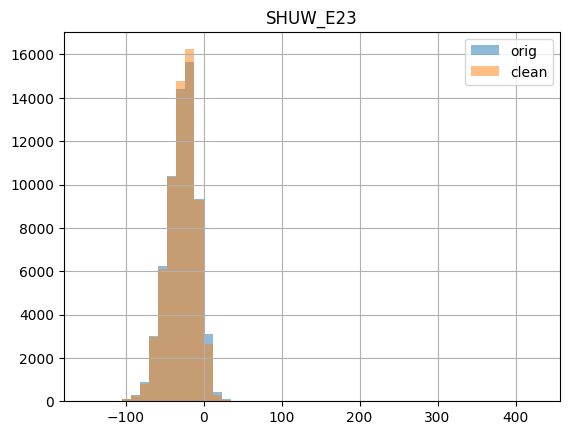

In [11]:
import matplotlib.pyplot as plt

node = "SHUW_E23"
orig_df[node].hist(bins=50, alpha=0.5, label="orig")
clean_df[node].hist(bins=50, alpha=0.5, label="clean")
plt.legend()
plt.title(node)
plt.show()


### bess cleaning using ptdf and regression in comparision

In [12]:
# %%
import numpy as np
import pandas as pd

# ---- Parameter ----
FIELD_DEBUG = "BOLS_E41"   # oder "SHUW_E23"
TOPK = 30

A = net.A
lines = net.lines

print("Slack:", net.slack_node)
print("BESS_NODE:", BESS_NODE, "| in H.columns:", BESS_NODE in H.columns)
print("FIELD_DEBUG:", FIELD_DEBUG, "| in A.columns:", FIELD_DEBUG in A.columns)

# 1) Alle inzidenten Leitungen am Feld + PTDF(line, BESS)
if FIELD_DEBUG in A.columns:
    inc = A.index[A[FIELD_DEBUG] != 0].tolist()
    inc = [l for l in inc if l in H.index]
    if not inc:
        print("Keine inzidenten Leitungen (oder keine in H.index).")
    else:
        df_inc = pd.DataFrame({
            "line_id": inc,
            "A_sign": A.loc[inc, FIELD_DEBUG].astype(float).values,
            "from_node": lines.loc[inc, "from_node"].values,
            "to_node": lines.loc[inc, "to_node"].values,
            "PTDF_line_BESS": H.loc[inc, BESS_NODE].astype(float).values,
            "abs_PTDf": H.loc[inc, BESS_NODE].astype(float).abs().values,
        }).sort_values("abs_PTDf", ascending=False)

        print(f"\nInzidente Leitungen an {FIELD_DEBUG} (sortiert nach |PTDF|):")
        display(df_inc)
else:
    print("FIELD_DEBUG nicht in A.columns")

# 2) Global: Leitungen mit größtem |PTDF(:, BESS)|
ptdf_bess = H[BESS_NODE].astype(float)
top_lines = ptdf_bess.abs().sort_values(ascending=False).head(TOPK).index.tolist()

df_top = pd.DataFrame({
    "line_id": top_lines,
    "PTDF_line_BESS": ptdf_bess.loc[top_lines].values,
    "from_node": lines.loc[top_lines, "from_node"].values,
    "to_node": lines.loc[top_lines, "to_node"].values,
    "length_km": lines.loc[top_lines, "length_km"].values if "length_km" in lines.columns else np.nan,
}).sort_values("PTDF_line_BESS", key=np.abs, ascending=False)

print(f"\nTop {TOPK} Leitungen nach |PTDF(line, BESS)|:")
display(df_top)


Slack: SHUW
BESS_NODE: BOLS_E42 | in H.columns: True
FIELD_DEBUG: BOLS_E41 | in A.columns: True

Inzidente Leitungen an BOLS_E41 (sortiert nach |PTDF|):


,line_id,A_sign,from_node,to_node,PTDF_line_BESS,abs_PTDf
0,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",1.0,BOLS_E41,BOLS_A3,3.029961e-14,3.029961e-14



Top 30 Leitungen nach |PTDF(line, BESS)|:


,line_id,PTDF_line_BESS,from_node,to_node,length_km
0,110_SHUW_TARP_GELB_JUBO_BOLS_A5_BOLS,-8.333333e-01,BOLS_A5,BOLS_E42,NaN
1,110_SHUW_TARP_GELB_JUBO_JUBO_A5_BOLS_A5,-5.000000e-01,JUBO_A5,BOLS_A5,NaN
2,110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,-1.666667e-01,JUBO_E01,JUBO_A5,NaN
3,110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,-1.666667e-01,TARP_E01,BOLS_A5,NaN
4,110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5,1.666667e-01,JUBO_A5,SHUW_E24,NaN
5,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",6.544147e-14,BOLS_A3,BOLN_A3,NaN
6,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",-6.294749e-14,SIES_A3,BOLN_A3,NaN
7,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",4.739117e-14,SIES_A3,SIEV_A3,NaN
8,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",3.029961e-14,BOLS_E41,BOLS_A3,NaN
9,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",-1.801397e-14,WEDING_E12,SIEV_A3,NaN


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

PTDF H: (15, 28) (lines x non-slack nodes) | slack: SHUW
Top 20 |k_j| nach improved mapping:


JUBO_E01     -1.666667e-01
TARP_E01     -1.666667e-01
SHUW_E24      1.666667e-01
BOLS_E41      3.029961e-14
WEDING_E12   -1.801397e-14
SIEV_E01      1.465884e-14
SIES_E02      7.875458e-15
SHUW_E23      4.915734e-15
BOLN_E02      1.154273e-15
WEDING_E14    0.000000e+00
TARP_E03      0.000000e+00
Name: k_j, dtype: float64

PTDF-A (improved mapping) bereinigte Nodes: 11


,node,line_id,k_j,corr_after_ptdfA,mean_abs_removed_MW_ptdfA
0,TARP_E01,110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,-1.666667e-01,-0.264428,2.314226e+00
1,SHUW_E23,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",4.915734e-15,-0.440713,6.825672e-14
2,WEDING_E14,110-TARP-WEDI-GRUEN TARP-WEDI,0.000000e+00,-0.320049,0.000000e+00
3,BOLS_E41,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",3.029961e-14,0.940766,4.207209e-13
4,SHUW_E24,110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5,1.666667e-01,-0.410011,2.314226e+00


Vergleich – Regression vs. PTDF-A (improved mapping) Top 30:


,node,line_id,corr_before,corr_after_reg,corr_after_ptdfA,beta,k_j,r2,mean_abs_removed_MW_reg,mean_abs_removed_MW_ptdfA,corr_improvement_reg,corr_improvement_ptdfA
0,BOLS_E41,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",0.940766,9.247196e-04,0.940766,0.942776,3.029961e-14,0.885040,13.090777,4.207209e-13,0.939841,4.440892e-15
1,TARP_E01,110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,-0.447962,-1.442284e-04,-0.264428,-0.367999,-1.666667e-01,0.796828,5.109797,2.314226e+00,0.447817,1.835336e-01
2,SHUW_E23,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",-0.440713,-2.745527e-04,-0.440713,-0.505464,4.915734e-15,0.751213,7.018543,6.825672e-14,0.440439,-3.774758e-15
3,WEDING_E12,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",-0.430709,-2.116053e-03,-0.430709,-0.273330,-1.801397e-14,0.187857,3.795290,2.501305e-13,0.428593,2.342571e-14
4,WEDING_E14,110-TARP-WEDI-GRUEN TARP-WEDI,-0.320049,-1.561087e-03,-0.320049,-0.224203,0.000000e+00,0.103303,3.113145,0.000000e+00,0.318488,0.000000e+00
5,SHUW_E24,110_SHUW_TARP_GELB_JUBO_SHUW_JUBO_A5,-0.318354,-1.687995e-04,-0.410011,-0.491986,1.666667e-01,0.792984,6.831404,2.314226e+00,0.318185,-9.165772e-02
6,TARP_E03,110-TARP-WEDI-GRUEN TARP-WEDI,0.316852,3.461115e-04,0.316852,0.217090,0.000000e+00,0.854582,3.014374,0.000000e+00,0.316506,0.000000e+00
7,SIEV_E01,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",0.255469,5.270133e-04,0.255469,0.178305,1.465884e-14,0.763961,2.475833,2.035432e-13,0.254942,1.998401e-14
8,JUBO_E01,110_SHUW_TARP_GELB_JUBO_JUBO_A5_JUBO,-0.145870,2.394977e-17,0.046264,-0.126829,-1.666667e-01,0.816953,1.761065,2.314226e+00,0.145870,9.960559e-02
9,SIES_E02,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",0.049523,4.698816e-05,0.049523,0.009644,7.875458e-15,0.789610,0.133910,1.093535e-13,0.049476,4.027334e-14


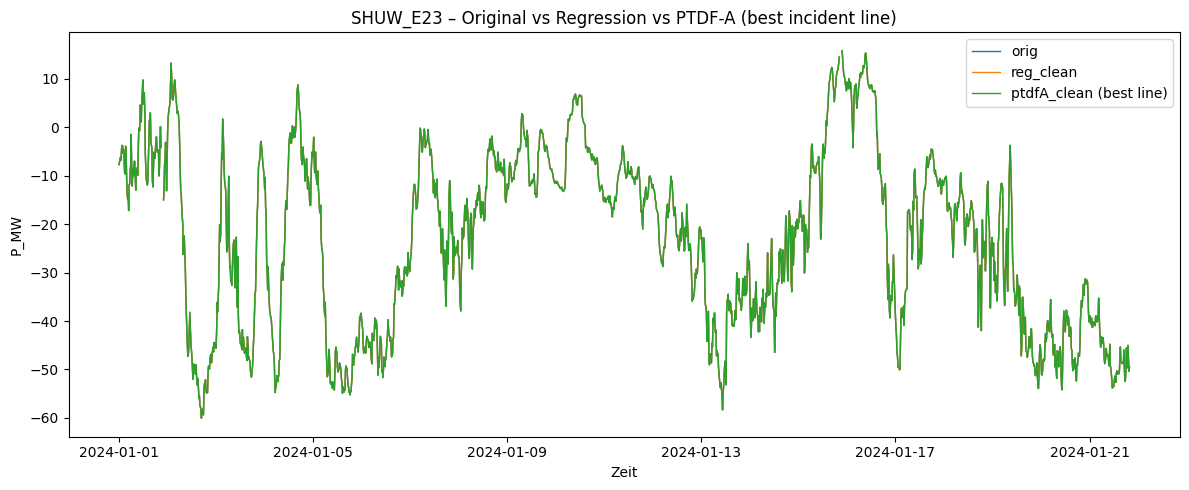

In [ ]:
# %%
# ============================================================
# Variante A (besser): Feld -> inzidente Leitung mit max |PTDF(line, BESS)|
# Voraussetzungen: bess, orig_series, reg_results_df, reg_clean_df existieren
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.alt.network_model import load_network_model
from src.alt.ptdf import compute_ptdf

# ---- Settings ----
BESS_NODE = "BOLS_E42"
PLOT_NODE = "SHUW_E23"
PTDF_USE_PINV = True
OVERRIDE_SLACK_NODE = None

# ---- Load net + PTDF ----
net = load_network_model(slack_node=OVERRIDE_SLACK_NODE)
H = compute_ptdf(net, relevant_only=False, use_pinv=PTDF_USE_PINV)

print("PTDF H:", H.shape, "(lines x non-slack nodes) | slack:", net.slack_node)

if BESS_NODE == net.slack_node:
    raise ValueError(f"BESS_NODE={BESS_NODE} ist Slack. OVERRIDE_SLACK_NODE auf anderen Knoten setzen.")
if BESS_NODE not in H.columns:
    raise ValueError(f"BESS_NODE={BESS_NODE} nicht in H.columns.")

A = net.A  # lines x nodes

# ---- Mapping: field -> best incident line ----
best_line = {}
best_k = {}

for field in orig_series.keys():
    if field not in A.columns:
        continue

    inc = A.index[A[field] != 0].tolist()
    if not inc:
        continue

    # nur Leitungen, die in PTDF vorkommen
    inc = [l for l in inc if l in H.index]
    if not inc:
        continue

    # PTDF Werte dieser Leitungen bzgl. BESS
    vals = H.loc[inc, BESS_NODE].astype(float)

    # best = max |PTDF|
    l_star = vals.abs().idxmax()
    k_star = float(vals.loc[l_star])

    best_line[field] = l_star
    best_k[field] = k_star

best_line = pd.Series(best_line, name="line_id")
best_k = pd.Series(best_k, name="k_j").sort_values(key=np.abs, ascending=False)

print("Top 20 |k_j| nach improved mapping:")
display(best_k.head(20))

# ---- PTDF-A bereinigen ----
ptdfA_clean_series = {}
ptdfA_results = []

for node, y_full in orig_series.items():
    if node not in best_k.index:
        continue

    k_j = float(best_k.loc[node])

    bess_raw = bess.reindex(y_full.index)["BESS_P"]
    bess_filled = bess_raw.fillna(0.0)

    y_clean = y_full - k_j * bess_filled
    ptdfA_clean_series[node] = y_clean

    mask = ~bess_raw.isna()
    corr_after = bess_raw[mask].corr(y_clean[mask]) if mask.sum() >= 10 else np.nan
    mean_abs_removed = (k_j * bess.loc[mask, "BESS_P"]).abs().mean() if mask.sum() > 0 else np.nan

    ptdfA_results.append({
        "node": node,
        "line_id": best_line.get(node, None),
        "k_j": k_j,
        "corr_after_ptdfA": corr_after,
        "mean_abs_removed_MW_ptdfA": mean_abs_removed,
    })

ptdfA_clean_df = pd.DataFrame(ptdfA_clean_series)
ptdfA_results_df = pd.DataFrame(ptdfA_results)

print("PTDF-A (improved mapping) bereinigte Nodes:", ptdfA_clean_df.shape[1])
display(ptdfA_results_df.head())

# ---- Compare ----
compare_A = reg_results_df.merge(ptdfA_results_df, on="node", how="inner").copy()

compare_A["abs_corr_before"] = compare_A["corr_before"].abs()
compare_A["abs_corr_after_reg"] = compare_A["corr_after_reg"].abs()
compare_A["abs_corr_after_ptdfA"] = compare_A["corr_after_ptdfA"].abs()
compare_A["corr_improvement_reg"] = compare_A["abs_corr_before"] - compare_A["abs_corr_after_reg"]
compare_A["corr_improvement_ptdfA"] = compare_A["abs_corr_before"] - compare_A["abs_corr_after_ptdfA"]
compare_A = compare_A.sort_values(by="corr_before", key=np.abs, ascending=False)

cols = [
    "node","line_id","corr_before","corr_after_reg","corr_after_ptdfA",
    "beta","k_j","r2",
    "mean_abs_removed_MW_reg","mean_abs_removed_MW_ptdfA",
    "corr_improvement_reg","corr_improvement_ptdfA"
]
cols = [c for c in cols if c in compare_A.columns]

print("Vergleich – Regression vs. PTDF-A (improved mapping) Top 30:")
display(compare_A[cols].head(30))

# ---- Plot example ----
if (PLOT_NODE in orig_series and PLOT_NODE in reg_clean_df.columns and PLOT_NODE in ptdfA_clean_df.columns):
    idx = orig_series[PLOT_NODE].index[:2000]
    plt.figure(figsize=(12, 5))
    plt.plot(idx, orig_series[PLOT_NODE].loc[idx], label="orig", linewidth=1)
    plt.plot(idx, reg_clean_df[PLOT_NODE].loc[idx], label="reg_clean", linewidth=1)
    plt.plot(idx, ptdfA_clean_df[PLOT_NODE].loc[idx], label="ptdfA_clean (best line)", linewidth=1)
    plt.title(f"{PLOT_NODE} – Original vs Regression vs PTDF-A (best incident line)")
    plt.xlabel("Zeit"); plt.ylabel("P_MW")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print(f"{PLOT_NODE} nicht in allen DataFrames vorhanden.")


In [ ]:
from src.data.data_loader import load_all_data

data = load_all_data()
print("keys:", data.keys())
print("weather_hist type/len:", type(data.get("weather_hist")), len(data.get("weather_hist", {})))
print("weather_forecast type/len:", type(data.get("weather_forecast")), len(data.get("weather_forecast", {})))

# optional: zeigen, was genau drin ist
print("weather_hist keys:", list((data.get("weather_hist") or {}).keys())[:10])
print("weather_forecast keys:", list((data.get("weather_forecast") or {}).keys())[:10])


/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/data_loader.py:454: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  s = pd.concat([s_old, s_new])
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'historical-forecast-api.open-meteo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request

keys: dict_keys(['nodes', 'measurements', 'weather_hist', 'weather_forecast'])
weather_hist type/len: <class 'dict'> 16
weather_forecast type/len: <class 'dict'> 16
weather_hist keys: ['SHUW_E24', 'SHUW_E23', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02']
weather_forecast keys: ['SHUW_E24', 'SHUW_E23', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02']


In [1]:
from src.forecast import forecast_all_nodes
import pandas as pd

# Option A: nimm ALLE Wetter-Forecast-Timestamps (aber Modell nutzt max H Schritte)
summary = forecast_all_nodes(overwrite=True, max_hours_cap=None, verbose=True)

# Option B: cap z.B. auf 30h ab letztem historischen Timestamp
# summary = forecast_all_nodes(overwrite=True, max_hours_cap=30.0, verbose=True)

display(summary)
print("OK:", summary["ok"].sum(), "FAIL:", (~summary["ok"]).sum())


[OK] BOLN_E01 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E01_pred.csv (n=96)
[OK] BOLN_E02 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E02_pred.csv (n=96)
[OK] BOLN_E03 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E03_pred.csv (n=96)
[OK] JUBO_E01 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E01_pred.csv (n=96)
[OK] JUBO_E02 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E02_pred.csv (n=96)
[OK] JUBO_E03 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E03_pred.csv (n=96)
[OK] SHUW_E23 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/SHUW_E23_pred.csv (n=96)
[OK] SHUW_E24 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/

,node_id,ok,pred_path,n_pred,error
0,BOLN_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
1,BOLN_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
2,BOLN_E03,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
3,JUBO_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
4,JUBO_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
5,JUBO_E03,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
6,SHUW_E23,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
7,SHUW_E24,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
8,SIES_E02,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,
9,SIEV_E01,True,/Users/martinkrawtzow/Documents/Masterthesis/t...,96,


OK: 14 FAIL: 0


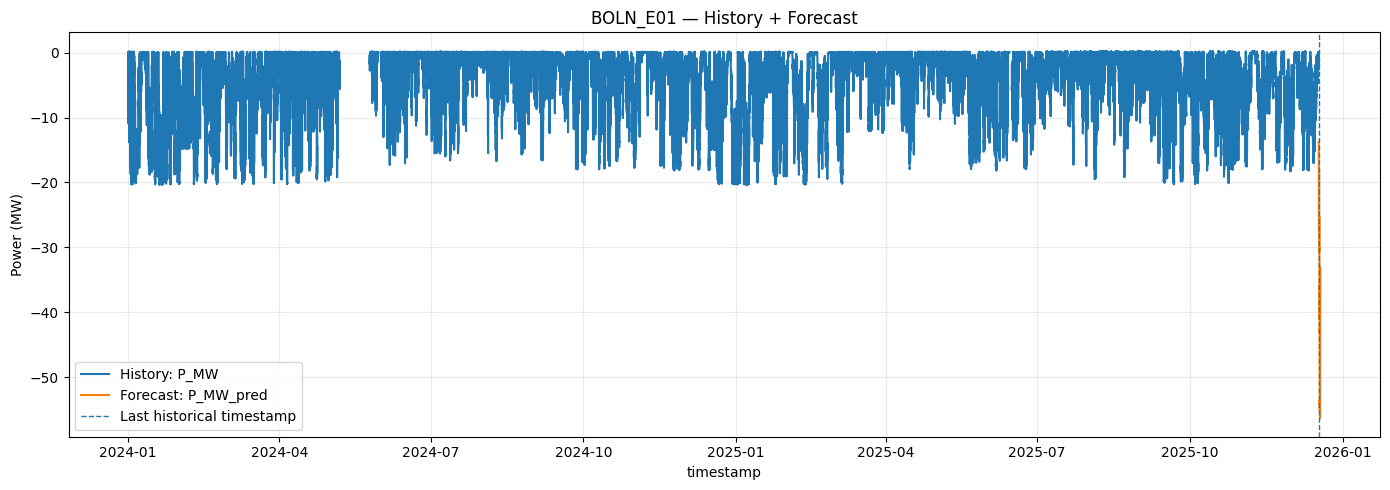

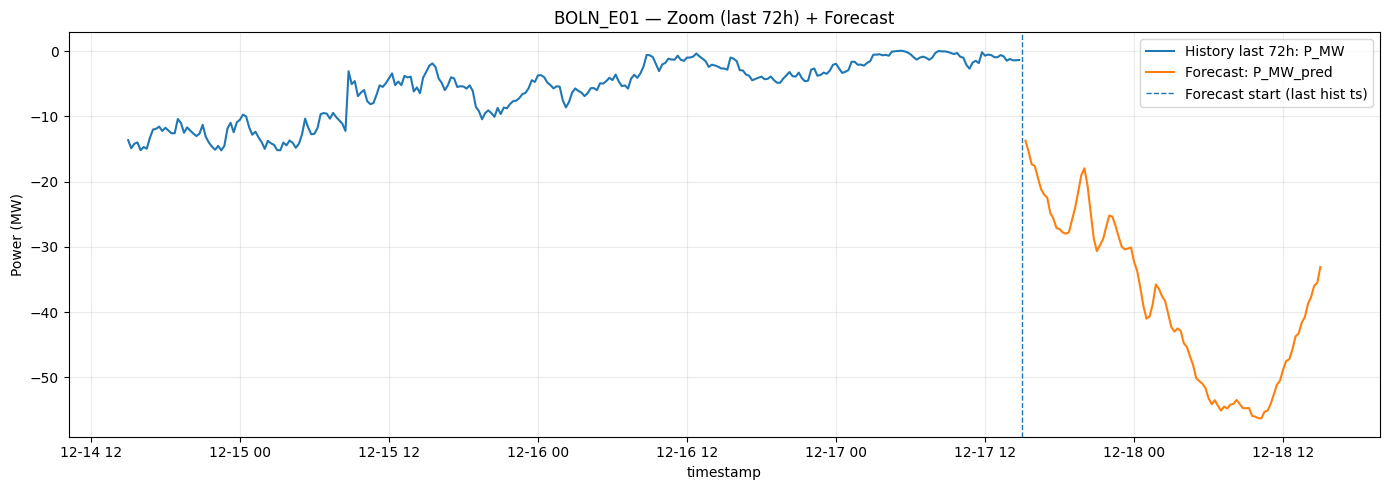

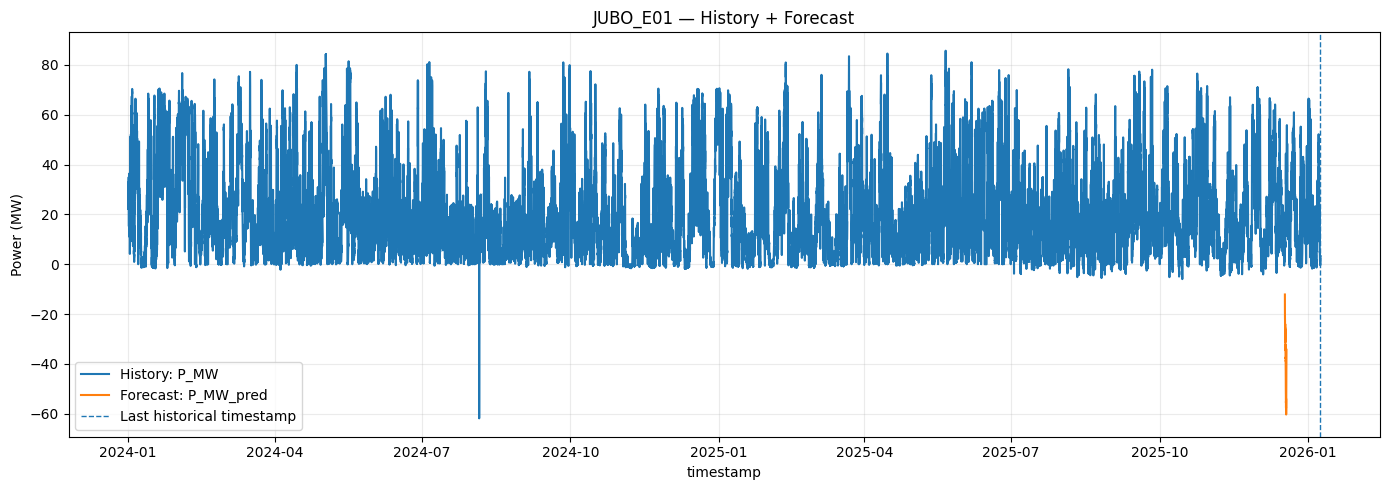

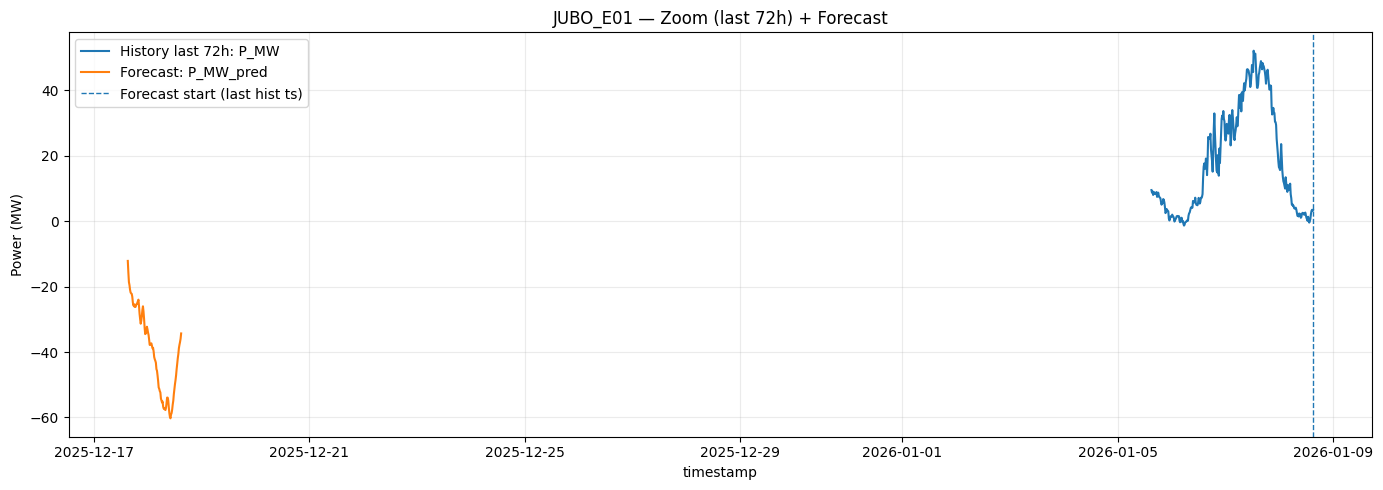

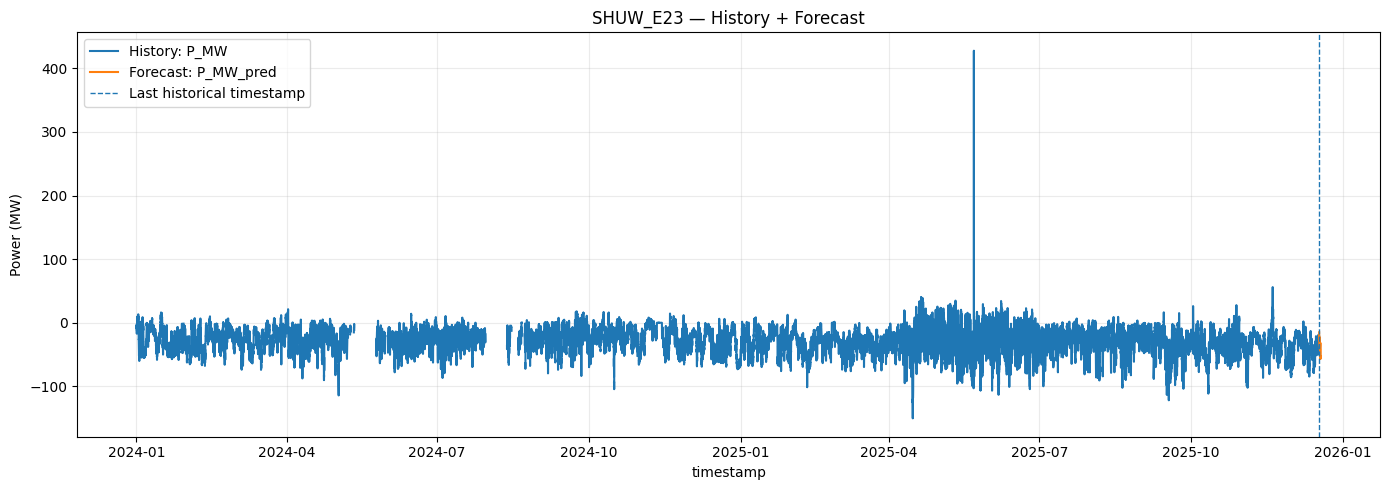

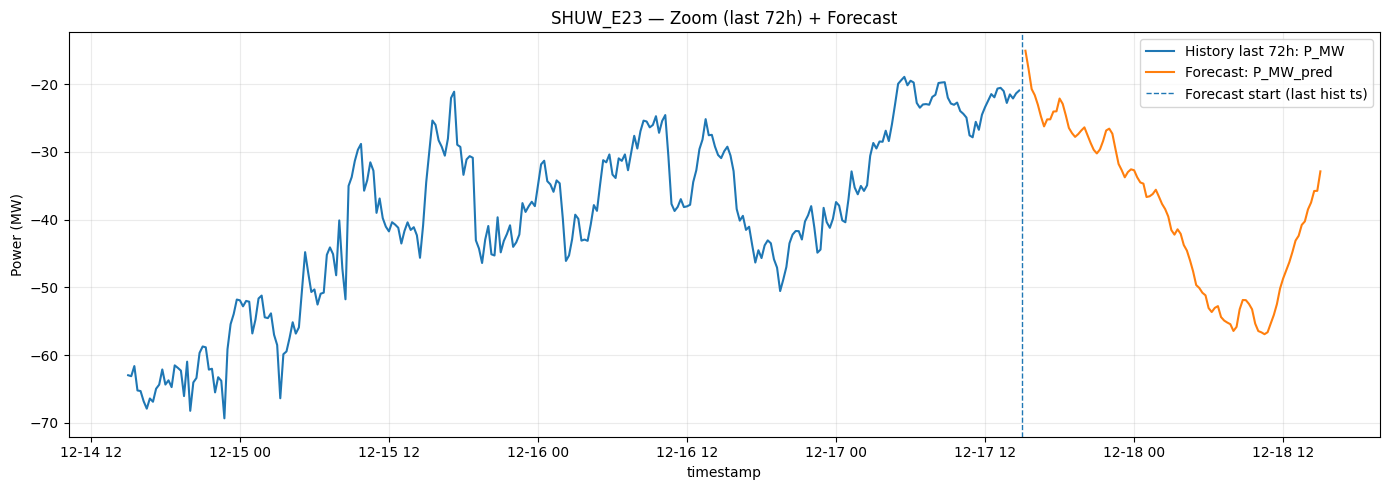

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.config import CLEAN_TS_DIR, PRED_TS_DIR

TIMESTAMP_COL = "timestamp"
TARGET_COL = "P_MW"
PRED_COL = "P_MW_pred"

def load_hist(node_id: str) -> pd.DataFrame:
    p = Path(CLEAN_TS_DIR) / f"{node_id}_hist_clean.csv"
    df = pd.read_csv(p)
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df

def load_pred(node_id: str) -> pd.DataFrame:
    p = Path(PRED_TS_DIR) / f"{node_id}_pred.csv"
    df = pd.read_csv(p)
    df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL])
    df = df.sort_values(TIMESTAMP_COL).reset_index(drop=True)
    return df

def plot_hist_and_forecast(node_id: str, zoom_hours: int = 72):
    hist = load_hist(node_id)
    pred = load_pred(node_id)

    # --- Plot 1: Full history + forecast ---
    plt.figure(figsize=(14, 5))
    plt.plot(hist[TIMESTAMP_COL], hist[TARGET_COL], label="History: P_MW")
    plt.plot(pred[TIMESTAMP_COL], pred[PRED_COL], label="Forecast: P_MW_pred")
    plt.axvline(hist[TIMESTAMP_COL].iloc[-1], linestyle="--", linewidth=1, label="Last historical timestamp")
    plt.title(f"{node_id} — History + Forecast")
    plt.xlabel("timestamp")
    plt.ylabel("Power (MW)")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # --- Plot 2: Zoom on last X hours + forecast ---
    last_ts = hist[TIMESTAMP_COL].iloc[-1]
    zoom_start = last_ts - pd.Timedelta(hours=zoom_hours)
    hist_zoom = hist[hist[TIMESTAMP_COL] >= zoom_start].copy()

    plt.figure(figsize=(14, 5))
    plt.plot(hist_zoom[TIMESTAMP_COL], hist_zoom[TARGET_COL], label=f"History last {zoom_hours}h: P_MW")
    plt.plot(pred[TIMESTAMP_COL], pred[PRED_COL], label="Forecast: P_MW_pred")
    plt.axvline(last_ts, linestyle="--", linewidth=1, label="Forecast start (last hist ts)")
    plt.title(f"{node_id} — Zoom (last {zoom_hours}h) + Forecast")
    plt.xlabel("timestamp")
    plt.ylabel("Power (MW)")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()


# ----------------------------
# Choose nodes to plot
# ----------------------------
# Option A: manually pick a few nodes
nodes_to_plot = ["BOLN_E01", "JUBO_E01", "SHUW_E23"]  # change as you like

# Option B: automatically pick first N nodes that have both files
# clean_nodes = sorted([p.stem.replace("_hist_clean","") for p in Path(CLEAN_TS_DIR).glob("*_hist_clean.csv")])
# nodes_to_plot = []
# for n in clean_nodes:
#     if (Path(PRED_TS_DIR)/f"{n}_pred.csv").exists():
#         nodes_to_plot.append(n)
#     if len(nodes_to_plot) >= 3:
#         break

for node_id in nodes_to_plot:
    plot_hist_and_forecast(node_id, zoom_hours=72)


In [5]:
import pandas as pd
from src.forecast import forecast_all_nodes
from src.config import PRED_TS_DIR

# 30h Cap (dein “B”), überschreiben
summary = forecast_all_nodes(overwrite=True, max_hours_cap=30.0)

summary[~summary["ok"]]

from pathlib import Path

pred_dir = Path(PRED_TS_DIR)
pred_files = sorted(pred_dir.glob("*_pred.csv"))

len(pred_files), pred_files[:5]



[OK] BOLN_E01 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E01_pred.csv (n=100)
[OK] BOLN_E02 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E02_pred.csv (n=100)
[OK] BOLN_E03 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E03_pred.csv (n=100)
[OK] JUBO_E01 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E01_pred.csv (n=100)
[OK] JUBO_E02 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E02_pred.csv (n=100)
[OK] JUBO_E03 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E03_pred.csv (n=100)
[OK] SHUW_E23 -> /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/SHUW_E23_pred.csv (n=100)
[OK] SHUW_E24 -> /Users/martinkrawtzow/Documents/Masterthesis/

(14,
 [PosixPath('/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E01_pred.csv'),
  PosixPath('/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E02_pred.csv'),
  PosixPath('/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/BOLN_E03_pred.csv'),
  PosixPath('/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E01_pred.csv'),
  PosixPath('/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred/JUBO_E02_pred.csv')])

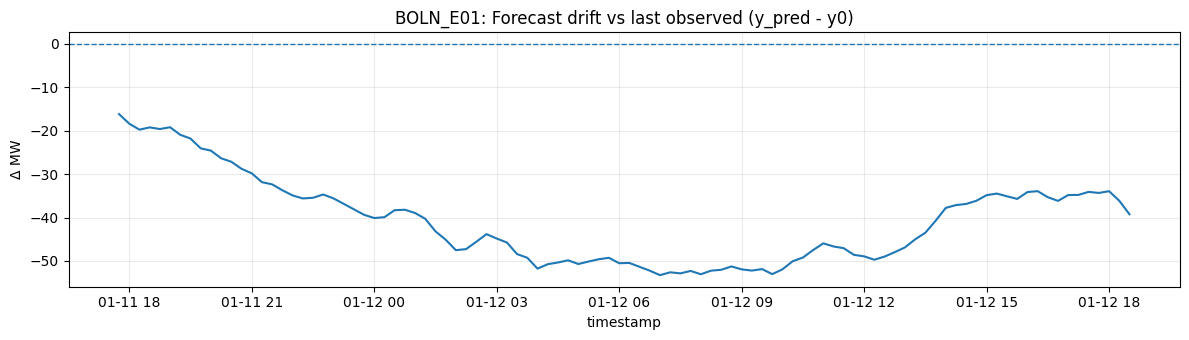

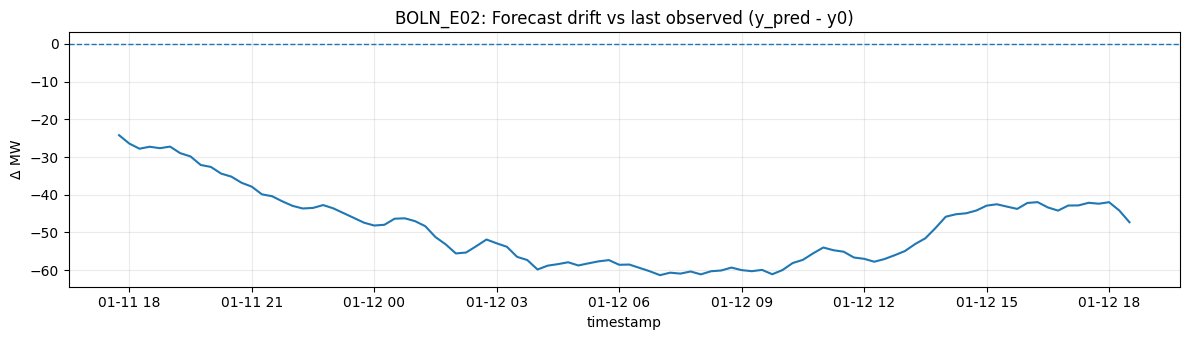

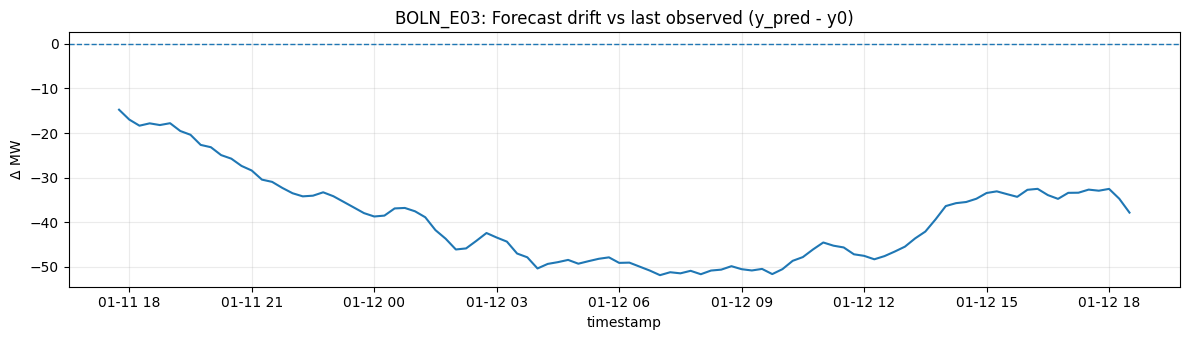

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
from src.config import CLEAN_TS_DIR, PRED_TS_DIR

def plot_hist_vs_forecast(node_id: str, hist_hours: int = 72):
    hist_path = Path(CLEAN_TS_DIR) / f"{node_id}_hist_clean.csv"
    pred_path = Path(PRED_TS_DIR) / f"{node_id}_pred.csv"

    hist = pd.read_csv(hist_path, parse_dates=["timestamp"]).sort_values("timestamp")
    pred = pd.read_csv(pred_path, parse_dates=["timestamp"]).sort_values("timestamp")

    # Fokus: nur die letzten X Stunden Historie
    t0 = hist["timestamp"].max() - pd.Timedelta(hours=hist_hours)
    hist_cut = hist[hist["timestamp"] >= t0].copy()

    plt.figure(figsize=(12, 4))
    plt.plot(hist_cut["timestamp"], hist_cut["P_MW"], label="History (clean)")
    plt.plot(pred["timestamp"], pred["P_MW_pred"], label="Forecast (winner)")
    plt.axvline(hist["timestamp"].max(), linestyle="--", linewidth=1)
    plt.title(f"{node_id}: History vs Forecast")
    plt.xlabel("timestamp")
    plt.ylabel("P_MW / P_MW_pred")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Beispiel: nimm 3 OK-nodes aus summary
ok_nodes = summary[summary["ok"]]["node_id"].head(3).tolist()
ok_nodes

def plot_forecast_delta(node_id: str):
    hist_path = Path(CLEAN_TS_DIR) / f"{node_id}_hist_clean.csv"
    pred_path = Path(PRED_TS_DIR) / f"{node_id}_pred.csv"

    hist = pd.read_csv(hist_path, parse_dates=["timestamp"]).sort_values("timestamp")
    pred = pd.read_csv(pred_path, parse_dates=["timestamp"]).sort_values("timestamp")

    y0 = float(hist["P_MW"].dropna().iloc[-1])
    pred["delta"] = pred["P_MW_pred"] - y0

    plt.figure(figsize=(12, 3.5))
    plt.plot(pred["timestamp"], pred["delta"])
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.title(f"{node_id}: Forecast drift vs last observed (y_pred - y0)")
    plt.xlabel("timestamp")
    plt.ylabel("Δ MW")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()

for nid in ok_nodes:
    plot_forecast_delta(nid)


### heute 14.01.

In [ ]:
# === DC/PTDF Engpass-Screening aus Forecasts (1 Zelle) ===

from pathlib import Path
import numpy as np
import pandas as pd

from src.config import PRED_TS_DIR
from src.alt.network_model import load_network_model
from src.alt.ptdf import check_B_rr_properties
from src.alt.flows import build_flows_timeseries

print("=== SETTINGS ===")
print("PRED_TS_DIR:", Path(PRED_TS_DIR).resolve())

# 1) Netzmodell laden (Slack-Fallback, weil 'SHUW' (busbar) oft nicht im elektrischen Teilnetz hängt)
print("\n=== 1) LOAD NETWORK MODEL ===")
slack_candidates = ["SHUW_E23", "SHUW_E24"]  # bei Bedarf erweitern
net = None
last_err = None

for slack in slack_candidates:
    try:
        print(f"Trying slack_node='{slack}' ...")
        net = load_network_model(slack_node=slack)
        check_B_rr_properties(net)
        print(f"OK: loaded network model with slack='{net.slack_node}'")
        break
    except Exception as e:
        last_err = e
        print(f"FAILED with slack='{slack}': {type(e).__name__}: {e}")

if net is None:
    raise RuntimeError(f"Konnte Netzmodell mit Slack-Kandidaten nicht laden. Last error: {last_err}")

print("\nNodes:", net.nodes.shape, "Lines:", net.lines.shape)
print("Lines preview (first 8):")
display(net.lines[["from_node","to_node","x","b","limit_a"]].head(8))

# 2) Flüsse aus Prognosen berechnen (bestehende Funktion)
print("\n=== 2) BUILD FLOWS TIMESERIES FROM PRED ===")
pred_dir = Path(PRED_TS_DIR)
n_files = len(list(pred_dir.glob("*_pred.csv")))
print("Found forecast files:", n_files)

df_F, H_rel, df_P = build_flows_timeseries(
    net=net,
    meas_dir=pred_dir,
    relevant_only=True,
    use_pinv=True,
    ts_col="timestamp",
    val_col="P_MW_pred",
    suffix="_pred.csv",
)

print("\nPTDF shape (lines x relevant_nodes):", H_rel.shape)
print("P matrix shape (timestamps x nodes):", df_P.shape)
print("F matrix shape (timestamps x lines):", df_F.shape)

print("\nP head (first 3 rows, first 6 cols):")
display(df_P.iloc[:3, :6])

print("\nF head (first 3 rows, first 6 cols):")
display(df_F.iloc[:3, :6])

# 3) Auslastung berechnen (Screening: MW -> A bei 110 kV, cosphi=1)
print("\n=== 3) LINE LOADING (SCREENING) ===")
U_kV = 110.0
U = U_kV * 1e3
limits_a = net.lines["limit_a"].astype(float)

I_A = (df_F.abs() * 1e6) / (np.sqrt(3) * U)     # A
loading = I_A.divide(limits_a, axis=1)          # pu (1.0 = 100%)

print(f"Assumption: U_kV={U_kV} kV, cosphi≈1.0 (DC screening)")

# Summary outputs to compare
print("\n=== SUMMARY OUTPUTS ===")

# Top max loading per line
max_loading = loading.max(axis=0).sort_values(ascending=False)
print("\nTop-10 lines by MAX loading:")
display(max_loading.head(10).to_frame("max_loading_pu"))

# How often > 100%
n_over = (loading > 1.0).sum(axis=0).sort_values(ascending=False)
print("\nTop-10 lines by COUNT(loading>1.0):")
display(n_over.head(10).to_frame("count_over_1.0"))

# Worst single event
worst_idx = loading.stack().idxmax()
worst_val = float(loading.loc[worst_idx[0], worst_idx[1]])
print("\nWorst-case event:")
print("timestamp:", worst_idx[0])
print("line_id  :", worst_idx[1])
print("loading  :", worst_val)

# A bit more context for worst line
worst_line = worst_idx[1]
print("\nWorst line details:")
display(net.lines.loc[[worst_line], ["from_node","to_node","x","limit_a"]])

print("\nWorst line - top 10 timestamps by loading:")
display(loading[worst_line].sort_values(ascending=False).head(10).to_frame("loading_pu"))

print("\nDONE.")


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

=== SETTINGS ===
PRED_TS_DIR: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred

=== 1) LOAD NETWORK MODEL ===
Trying slack_node='SHUW_E23' ...
OK: loaded network model with slack='SHUW_E23'

Nodes: (29, 12) Lines: (15, 11)
Lines preview (first 8):


,from_node,to_node,x,b,limit_a
id,,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",BOLN_A3,BOLN_E02,0.00399,250.626566,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",SIES_A3,BOLN_A3,0.40259,2.483917,545.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",BOLS_A3,BOLN_A3,1.86532,0.536101,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",BOLS_E41,BOLS_A3,0.00399,250.626566,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",SHUW_E23,BOLS_A3,2.80787,0.356142,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",SIES_A3,SIES_E02,0.52907,1.890109,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",SIES_A3,SIEV_A3,0.52907,1.890109,555.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",SIEV_A3,SIEV_E01,0.00040,2500.000000,547.0


B_rr ist numerisch singulär (Rang=15 < 28). PTDF kann unzuverlässig sein.
B_rr ist schlecht konditioniert (cond≈1.12e+17). PTDF-Werte könnten numerisch verrauscht sein.
[LOAD] BOLS_E41: Datei BOLS_E41_pred.csv existiert nicht.
[LOAD] BOLS_E42: Datei BOLS_E42_pred.csv existiert nicht.
compute_line_flows_from_ptdf: folgende Knoten fehlen in df_P und werden mit 0 belegt: ['BOLS_E41', 'BOLS_E42']



=== 2) BUILD FLOWS TIMESERIES FROM PRED ===
Found forecast files: 14

PTDF shape (lines x relevant_nodes): (15, 15)
P matrix shape (timestamps x nodes): (100, 15)
F matrix shape (timestamps x lines): (100, 15)

P head (first 3 rows, first 6 cols):


,BOLN_E01,BOLN_E02,BOLN_E03,JUBO_E01,JUBO_E02,JUBO_E03
timestamp,,,,,,
2026-01-11 17:45:00,-18.634944,-17.727608,-18.774429,-21.537688,-22.067785,-21.280841
2026-01-11 18:00:00,-20.845409,-19.938073,-20.984895,-22.621166,-23.151263,-22.364319
2026-01-11 18:15:00,-22.218744,-21.311408,-22.358230,-23.334137,-23.864234,-23.077290



F head (first 3 rows, first 6 cols):


id,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES"
timestamp,,,,,,
2026-01-11 17:45:00,17.727608,-52.142098,69.869706,-3.559521e-12,69.869706,17.867893
2026-01-11 18:00:00,19.938073,-58.773495,78.711568,-3.879305e-12,78.711568,20.674142
2026-01-11 18:15:00,21.311408,-64.616272,85.927681,-4.206752e-12,85.927681,22.578681



=== 3) LINE LOADING (SCREENING) ===
Assumption: U_kV=110.0 kV, cosphi≈1.0 (DC screening)

=== SUMMARY OUTPUTS ===

Top-10 lines by MAX loading:


,max_loading_pu
id,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",2.206580
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",2.206580
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",1.692161
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",1.090955
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",0.602384
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",0.582058
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",0.526145
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",0.504527
110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,0.316345



Top-10 lines by COUNT(loading>1.0):


,count_over_1.0
id,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",91
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",91
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",85
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",28
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",0



Worst-case event:
timestamp: 2026-01-12 09:45:00
line_id  : 110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3
loading  : 2.206579515230388

Worst line details:


,from_node,to_node,x,limit_a
id,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",SHUW_E23,BOLS_A3,2.80787,547.0



Worst line - top 10 timestamps by loading:


,loading_pu
timestamp,
2026-01-12 09:45:00,2.206580
2026-01-12 10:00:00,2.199174
2026-01-12 09:30:00,2.183421
2026-01-12 08:00:00,2.177968
2026-01-12 10:15:00,2.171484
2026-01-12 09:15:00,2.170593
2026-01-12 08:15:00,2.163523
2026-01-12 07:15:00,2.161458
2026-01-12 09:00:00,2.157948



DONE.


In [ ]:
# === DC/PTDF Engpass-Screening aus Forecasts (MW-basiert, 1 Zelle) ===

from pathlib import Path
import numpy as np
import pandas as pd

from src.config import (
    PRED_TS_DIR,
    NOMINAL_VOLTAGE_KV,
    COSPHI_DC,
)
from src.alt.network_model import load_network_model
from src.alt.ptdf import check_B_rr_properties
from src.alt.flows import build_flows_timeseries

print("=== SETTINGS ===")
print("PRED_TS_DIR        :", Path(PRED_TS_DIR).resolve())
print("NOMINAL_VOLTAGE_KV :", NOMINAL_VOLTAGE_KV)
print("COSPHI_DC          :", COSPHI_DC)

# ------------------------------------------------------------------
# 1) Netzmodell laden
# ------------------------------------------------------------------
print("\n=== 1) LOAD NETWORK MODEL ===")

slack_candidates = ["SHUW_E23", "SHUW_E24"]
net = None
last_err = None

for slack in slack_candidates:
    try:
        print(f"Trying slack_node='{slack}' ...")
        net = load_network_model(slack_node=slack)
        check_B_rr_properties(net)
        print(f"OK: loaded network model with slack='{net.slack_node}'")
        break
    except Exception as e:
        last_err = e
        print(f"FAILED with slack='{slack}': {type(e).__name__}: {e}")

if net is None:
    raise RuntimeError(
        f"Konnte Netzmodell mit Slack-Kandidaten nicht laden. Last error: {last_err}"
    )

print("\nNodes:", net.nodes.shape, "Lines:", net.lines.shape)
print("Lines preview (first 8):")
display(net.lines[["from_node", "to_node", "x", "b", "limit_a"]].head(8))

# ------------------------------------------------------------------
# 2) Leitungsflüsse aus Prognosen berechnen (MW)
# ------------------------------------------------------------------
print("\n=== 2) BUILD FLOWS TIMESERIES FROM PRED (MW) ===")

pred_dir = Path(PRED_TS_DIR)
n_files = len(list(pred_dir.glob("*_pred.csv")))
print("Found forecast files:", n_files)

df_F, H_rel, df_P = build_flows_timeseries(
    net=net,
    meas_dir=pred_dir,
    relevant_only=True,
    use_pinv=True,
    ts_col="timestamp",
    val_col="P_MW_pred",
    suffix="_pred.csv",
)

print("\nPTDF shape (lines x relevant_nodes):", H_rel.shape)
print("P matrix shape (timestamps x nodes):", df_P.shape)
print("F matrix shape (timestamps x lines):", df_F.shape)

print("\nP head (first 3 rows, first 6 cols):")
display(df_P.iloc[:3, :6])

print("\nF head (first 3 rows, first 6 cols) [MW]:")
display(df_F.iloc[:3, :6])

# ------------------------------------------------------------------
# 3) MW-Grenzen aus Stromlimits (110-kV-Ebene)
# ------------------------------------------------------------------
print("\n=== 3) MW LIMITS FROM CURRENT LIMITS ===")

P_limit_MW = (
    np.sqrt(3)
    * NOMINAL_VOLTAGE_KV * 1e3
    * net.lines["limit_a"]
    * COSPHI_DC
    / 1e6
)

print("MW limits (first 8 lines):")
display(P_limit_MW.head(8).to_frame("P_limit_MW"))

# ------------------------------------------------------------------
# 4) MW-Margen & Engpassanalyse
# ------------------------------------------------------------------
print("\n=== 4) MW MARGINS & BOTTLENECKS ===")

P_abs = df_F.abs()
margin_MW = P_limit_MW - P_abs

print("\nTop-10 lines by MIN MW margin:")
display(
    margin_MW.min(axis=0)
    .sort_values()
    .head(10)
    .to_frame("min_margin_MW")
)

print("\nTop-10 lines by COUNT(margin < 0 MW):")
display(
    (margin_MW < 0).sum(axis=0)
    .sort_values(ascending=False)
    .head(10)
    .to_frame("count_overload")
)

# ------------------------------------------------------------------
# 5) Worst-case Ereignis (MW)
# ------------------------------------------------------------------
worst_idx = margin_MW.stack().idxmin()
worst_margin = float(margin_MW.loc[worst_idx[0], worst_idx[1]])

print("\n=== WORST-CASE EVENT (MW) ===")
print("timestamp :", worst_idx[0])
print("line_id   :", worst_idx[1])
print("margin MW :", worst_margin)

print("\nWorst line details:")
display(
    net.lines.loc[[worst_idx[1]], ["from_node", "to_node", "x", "limit_a"]]
)

print("\nWorst line MW context:")
display(
    pd.DataFrame(
        {
            "P_flow_MW": P_abs[worst_idx[1]].loc[worst_idx[0]],
            "P_limit_MW": P_limit_MW.loc[worst_idx[1]],
            "margin_MW": worst_margin,
        },
        index=[worst_idx[1]],
    )
)

print("\nWorst line – top 10 timestamps by smallest MW margin:")
display(
    margin_MW[worst_idx[1]]
    .sort_values()
    .head(10)
    .to_frame("margin_MW")
)

print("\nDONE.")


Leitung SHUW_SS_E23 (SHUW -> SHUW_E23) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung SHUW_SS_E24 (SHUW -> SHUW_E24) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E01_JUBO (JUBO -> JUBO_E01) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E02_JUBO (JUBO_E02 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung JUBO_E03_JUBO (JUBO_E03 -> JUBO) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E01 (TARP_E01 -> TARP) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung TARP_SS_TARP_E03 (TARP -> TARP_E03) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E14 (WEDING_E14 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leitung WEDING_SS_WEDING_E12 (WEDING_E12 -> WEDING) hat keine Reaktanz (X_total_ohm) – wird vorerst mit NaN-x geführt.
Leit

=== SETTINGS ===
PRED_TS_DIR        : /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred
NOMINAL_VOLTAGE_KV : 110.0
COSPHI_DC          : 1.0

=== 1) LOAD NETWORK MODEL ===
Trying slack_node='SHUW_E23' ...
OK: loaded network model with slack='SHUW_E23'

Nodes: (29, 12) Lines: (15, 11)
Lines preview (first 8):


,from_node,to_node,x,b,limit_a
id,,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",BOLN_A3,BOLN_E02,0.00399,250.626566,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",SIES_A3,BOLN_A3,0.40259,2.483917,545.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",BOLS_A3,BOLN_A3,1.86532,0.536101,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",BOLS_E41,BOLS_A3,0.00399,250.626566,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",SHUW_E23,BOLS_A3,2.80787,0.356142,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",SIES_A3,SIES_E02,0.52907,1.890109,547.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",SIES_A3,SIEV_A3,0.52907,1.890109,555.0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",SIEV_A3,SIEV_E01,0.00040,2500.000000,547.0


B_rr ist numerisch singulär (Rang=15 < 28). PTDF kann unzuverlässig sein.
B_rr ist schlecht konditioniert (cond≈1.12e+17). PTDF-Werte könnten numerisch verrauscht sein.
[LOAD] BOLS_E41: Datei BOLS_E41_pred.csv existiert nicht.
[LOAD] BOLS_E42: Datei BOLS_E42_pred.csv existiert nicht.
compute_line_flows_from_ptdf: folgende Knoten fehlen in df_P und werden mit 0 belegt: ['BOLS_E41', 'BOLS_E42']



=== 2) BUILD FLOWS TIMESERIES FROM PRED (MW) ===
Found forecast files: 14

PTDF shape (lines x relevant_nodes): (15, 15)
P matrix shape (timestamps x nodes): (100, 15)
F matrix shape (timestamps x lines): (100, 15)

P head (first 3 rows, first 6 cols):


,BOLN_E01,BOLN_E02,BOLN_E03,JUBO_E01,JUBO_E02,JUBO_E03
timestamp,,,,,,
2026-01-11 17:45:00,-18.634944,-17.727608,-18.774429,-21.537688,-22.067785,-21.280841
2026-01-11 18:00:00,-20.845409,-19.938073,-20.984895,-22.621166,-23.151263,-22.364319
2026-01-11 18:15:00,-22.218744,-21.311408,-22.358230,-23.334137,-23.864234,-23.077290



F head (first 3 rows, first 6 cols) [MW]:


id,"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3","110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES"
timestamp,,,,,,
2026-01-11 17:45:00,17.727608,-52.142098,69.869706,-3.559521e-12,69.869706,17.867893
2026-01-11 18:00:00,19.938073,-58.773495,78.711568,-3.879305e-12,78.711568,20.674142
2026-01-11 18:15:00,21.311408,-64.616272,85.927681,-4.206752e-12,85.927681,22.578681



=== 3) MW LIMITS FROM CURRENT LIMITS ===
MW limits (first 8 lines):


,P_limit_MW
id,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",104.217497
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",103.836446
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",104.217497
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",104.217497
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",104.217497
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",104.217497
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",105.741702
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",104.217497



=== 4) MW MARGINS & BOTTLENECKS ===

Top-10 lines by MIN MW margin:


,min_margin_MW
id,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",-125.746697
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",-125.746697
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",-71.871571
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",-9.617772
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",41.438565
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",43.556839
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",49.384006
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",51.636956
110_SHUW_TARP_GELB_JUBO_BOLS_A5_TARP,71.248855



Top-10 lines by COUNT(margin < 0 MW):


,count_overload
id,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLN A3",91
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",91
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-SIES A3",85
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIES A3",28
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLN A3-BOLN",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV BOLS A3-BOLS",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIES A3-SIES",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SIEV A3-SIEV",0
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV WEDI-SIEV A3",0



=== WORST-CASE EVENT (MW) ===
timestamp : 2026-01-12 09:45:00
line_id   : 110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3
margin MW : -125.74669711908918

Worst line details:


,from_node,to_node,x,limit_a
id,,,,
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",SHUW_E23,BOLS_A3,2.80787,547.0



Worst line MW context:


,P_flow_MW,P_limit_MW,margin_MW
"110-SHUW-WEDI-ROT,BOLN,SIES,SIEV SHUW-BOLN A3",229.964194,104.217497,-125.746697



Worst line – top 10 timestamps by smallest MW margin:


,margin_MW
timestamp,
2026-01-12 09:45:00,-125.746697
2026-01-12 10:00:00,-124.974874
2026-01-12 09:30:00,-123.333213
2026-01-12 08:00:00,-122.764886
2026-01-12 10:15:00,-122.089143
2026-01-12 09:15:00,-121.996252
2026-01-12 08:15:00,-121.259436
2026-01-12 07:15:00,-121.044275
2026-01-12 09:00:00,-120.678405



DONE.


In [7]:
# -*- coding: utf-8 -*-
import json, os
import numpy as np
import pandas as pd
from collections import defaultdict, deque

# ================= Eingaben / Pfade ============================================
graph_json_path = r"/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/graph/whole_graph.json"
csv_folder = r"/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred"
ts_col = "timestamp"
p_col  = "P_MW_pred"
FILE_SUFFIX = "_pred.csv"


S_base_MVA   = 100.0
V_kV_default = 110.0
COSPHI_MIN   = 0.95          # konservativ für Strom-/Auslastungsberechnung

# Knotentypen ohne Messwerte (werden 0 MW gesetzt)
NO_MEASURE_TYPES = {"Sammelschiene", "Leitungsknoten", "junction", "busbar"}

# Behandlung fehlender Reaktanzen:
CONTRACT_ZERO_X = True
FILL_DEFAULT_X  = False
DEFAULT_X_PER_KM = {110.0: 0.35, 220.0: 0.25, 380.0: 0.20}

# Slack-Heuristik
PREFER_TYPES_FOR_SLACK = {"uw_field", "substation", "busbar", "Sammelschiene"}
AVOID_TYPES_FOR_SLACK  = {"BESS", "battery", "load"}

# ================== HELFER ======================================================
def edge_voltage_kV(u, v, efeat, node_features, V_kV_default):
    if efeat.get("Voltage_kV") not in (None, ""):
        try: return float(efeat["Voltage_kV"])
        except: pass
    uV = node_features.get(u, {}).get("Voltage_kV", None)
    vV = node_features.get(v, {}).get("Voltage_kV", None)
    try: uV = float(uV) if uV is not None else None
    except: uV = None
    try: vV = float(vV) if vV is not None else None
    except: vV = None
    if (uV is not None) and (vV is not None) and abs(uV - vV) < 1e-6:
        return uV
    return V_kV_default

def edge_raw_X_ohm(efeat):
    if efeat.get("X_total_ohm") not in (None, ""):
        return float(efeat["X_total_ohm"])
    xpk = efeat.get("X_ohm_per_km", None)
    Lkm = efeat.get("length_km", None)
    try: xpk = float(xpk) if xpk is not None else None
    except: xpk = None
    try: Lkm = float(Lkm) if Lkm is not None else None
    except: Lkm = None
    if (xpk is not None) and (Lkm is not None):
        return xpk * Lkm
    return None

def ohm_to_pu(X_ohm, V_kV, S_base_MVA):
    Zb = (V_kV*1e3)**2 / (S_base_MVA*1e6)
    return X_ohm / Zb

def mw_to_amp_with_pf(P_MW, V_kV, cosphi_min=COSPHI_MIN):
    if V_kV is None or V_kV <= 0: V_kV = V_kV_default
    if cosphi_min <= 0 or cosphi_min > 1:
        raise ValueError("cosφ_min in (0,1] erwartet")
    P_W = abs(P_MW) * 1e6
    U_V = V_kV * 1e3
    return P_W / (np.sqrt(3.0) * U_V * cosphi_min)

class UF:
    def __init__(self, items):
        self.parent = {x:x for x in items}
        self.rank   = {x:0 for x in items}
    def find(self, x):
        p = self.parent[x]
        if p != x:
            self.parent[x] = self.find(p)
        return self.parent[x]
    def union(self, a,b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components(nodes, lines):
    idx = {n:i for i,n in enumerate(nodes)}
    adj = [[] for _ in nodes]
    for (u,v,*_) in lines:
        ui, vi = idx[u], idx[v]
        adj[ui].append(vi); adj[vi].append(ui)
    seen = [False]*len(nodes)
    comps = []
    for i in range(len(nodes)):
        if seen[i]: continue
        q = deque([i]); seen[i]=True; comp=[]
        while q:
            x=q.popleft(); comp.append(nodes[x])
            for y in adj[x]:
                if not seen[y]:
                    seen[y]=True; q.append(y)
        comps.append(comp)
    return comps

def choose_slack_for_component(component_nodes, lines, node_types):
    deg = {n:0 for n in component_nodes}
    for (u,v,*_) in lines:
        if u in deg and v in deg:
            deg[u]+=1; deg[v]+=1
    good = [n for n in component_nodes if node_types.get(n,"") in PREFER_TYPES_FOR_SLACK]
    if good:
        return max(good, key=lambda n: deg[n])
    return max(component_nodes, key=lambda n: deg[n])

def pretty_matrix(name, M, rows=None, cols=None, fmt="{: .6f}", maxn=8):
    r, c = M.shape
    rr = rows or [f"r{i}" for i in range(r)]
    cc = cols or [f"c{j}" for j in range(c)]
    print(f"\n--- {name}  [{r}x{c}] ---")
    take_r = min(r, maxn)
    take_c = min(c, maxn)
    header = ["{:>12}".format("")] + ["{:>12}".format(cc[j]) for j in range(take_c)]
    print(" ".join(header))
    for i in range(take_r):
        row = ["{:>12}".format(rr[i])] + ["{:>12}".format(fmt.format(M[i,j])) for j in range(take_c)]
        print(" ".join(row))
    if r>take_r or c>take_c:
        print("...")

# ================== GRAPH LADEN ================================================
with open(graph_json_path, "r", encoding="utf-8") as f:
    graph = json.load(f)

nodes, edges = [], []
node_types, node_features = {}, {}
for it in graph:
    if "data" not in it: continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid]    = (d.get("type") or "").strip()
        node_features[nid] = d.get("features", {}) or {}

if not nodes:
    raise RuntimeError("Keine Knoten im Graph gefunden.")

print("=== Originalknoten (n={}) ===".format(len(nodes)))
print(nodes)

# ================== KANTEN-PREPROCESSING (Zero-X behandeln) ====================
uf = UF(nodes)
electrical_edges = []   # (u,v,feat, VkV, X_ohm, tag)
visual_to_contract = [] # (u,v) ohne brauchbare X

for e in edges:
    u, v = e["source"], e["target"]
    feat = e.get("features", {}) or {}
    VkV  = edge_voltage_kV(u, v, feat, node_features, V_kV_default)
    Xohm = edge_raw_X_ohm(feat)

    if Xohm is None or Xohm <= 0.0:
        if FILL_DEFAULT_X:
            Lkm = feat.get("length_km", None)
            try: Lkm = float(Lkm) if Lkm is not None else None
            except: Lkm = None
            xpk = DEFAULT_X_PER_KM.get(VkV, None)
            if (Lkm is not None) and (xpk is not None) and Lkm > 0 and xpk > 0:
                Xohm = xpk * Lkm
                electrical_edges.append((u, v, feat, VkV, Xohm, "estimated"))
            else:
                if CONTRACT_ZERO_X:
                    visual_to_contract.append((u, v))
        else:
            if CONTRACT_ZERO_X:
                visual_to_contract.append((u, v))
    else:
        electrical_edges.append((u, v, feat, VkV, Xohm, "given"))

for (u, v) in visual_to_contract:
    if u in node_types and v in node_types:
        uf.union(u, v)

rep_map = {nid: uf.find(nid) for nid in nodes}
super_nodes = sorted(set(rep_map.values()))

members_by_rep = defaultdict(list)
for nid, rep in rep_map.items():
    members_by_rep[rep].append(nid)

def merged_type(members):
    types = [node_types.get(m, "") for m in members if node_types.get(m, "")]
    for t in types:
        if t.lower() in {"bess", "battery"}:
            return "BESS"
    return types[0] if types else ""

super_node_types    = {rep: merged_type(members_by_rep[rep]) for rep in super_nodes}
super_node_features = {rep: {} for rep in super_nodes}

super_edges = []  # (ru, rv, eid, feat, VkV, X_ohm)
for (u, v, feat, VkV, Xohm, tag) in electrical_edges:
    ru, rv = rep_map[u], rep_map[v]
    if ru == rv:
        continue
    eid = feat.get("id", f"{u}-{v}")
    super_edges.append((ru, rv, eid, feat, VkV, Xohm))

if not super_edges:
    raise RuntimeError("Nach Kontraktion/Filterung keine elektrischen Kanten übrig.")

print("\n=== Superknoten (n={}) ===".format(len(super_nodes)))
print(super_nodes)
print("Superknoten-Mitglieder:")
for rep, mem in members_by_rep.items():
    if rep in super_nodes:
        print(f"  {rep}: {mem}")

print("\nSuperknoten-Typen:")
for rep in super_nodes:
    print(f"  {rep}: {super_node_types.get(rep,'')}")

print("\nSuperkanten ({}):".format(len(super_edges)))
for (ru, rv, eid, feat, VkV, Xohm) in super_edges:
    print(f"  {eid}: {ru} -> {rv}, VkV≈{VkV}, XΩ≈{Xohm}")

# ================== CSV LADEN & AUF SUPERKNOTEN AGGREGIEREN ====================
def load_series_for_node(nid):
    path = os.path.join(csv_folder, f"{nid}{FILE_SUFFIX}")  # <— wichtig
    if not os.path.isfile(path):
        return None

    df = pd.read_csv(path)
    if ts_col not in df.columns:
        raise ValueError(f"Zeitspalte '{ts_col}' fehlt in {path}")

    dt = pd.to_datetime(df[ts_col], errors="coerce")
    # falls Forecasts tz-aware sind, zu tz-naiv machen
    try:
        dt = dt.dt.tz_localize(None)
    except Exception:
        pass

    mask = ~dt.isna()
    if not mask.any():
        raise ValueError(f"Alle Zeitstempel in {path} sind ungültig.")

    df = df.loc[mask].copy()
    dt = dt.loc[mask]
    df.index = dt
    df.drop(columns=[ts_col], inplace=True, errors="ignore")

    if p_col not in df.columns:
        raise ValueError(f"Leistungsspalte '{p_col}' fehlt in {path}")

    s = pd.to_numeric(df[p_col], errors="coerce").fillna(0.0)
    s.index.name = None
    s.name = nid
    s = s.sort_index()

    if not isinstance(s.index, pd.DatetimeIndex):
        raise TypeError(f"{path}: Index ist kein DatetimeIndex nach Parsing.")
    return s


series_raw = {}
for nid in nodes:
    if node_types.get(nid, "") == "uw_field":
        series_raw[nid] = load_series_for_node(nid)
    else:
        series_raw[nid] = None


all_series = [s for s in series_raw.values() if s is not None]
if not all_series:
    raise RuntimeError("Keine Messreihen gefunden – prüfe csv_folder / Dateinamen / Spalten.")

missing = [n for n in nodes if node_types.get(n,"")=="uw_field" and series_raw.get(n) is None]
print("Missing forecast files for uw_fields:", missing[:10], "..." if len(missing)>10 else "")

print("\n=== Test Zeitachsen ===")
for nid, s in series_raw.items():
    if s is not None:
        print(f"{nid}: len={len(s)}, idx[0]={s.index[0]} ... tz={s.index.tz}")

P_df = pd.concat(all_series, axis=1).sort_index().fillna(0.0)  # MW
P_df = -1.0 * P_df

for nid in nodes:
    if nid not in P_df.columns:
        P_df[nid] = 0.0

# Superknoten-Leistung = Summe der Mitgliedsleistungen
for rep, members in members_by_rep.items():
    cols = [c for c in members if c in P_df.columns]
    P_df[rep] = P_df[cols].sum(axis=1) if cols else 0.0

P_df = P_df[super_nodes]
print("\n=== P_df Spalten (Superknoten) ===")
print(list(P_df.columns))
print("Zeilen (Zeitstempel):", len(P_df))

# ================== B-MATRIX (Supernetz, p.u.) =================================
n = len(super_nodes)
node_index = {nid:i for i, nid in enumerate(super_nodes)}
B = np.zeros((n, n), dtype=float)

lines = []  # (ru, rv, X_pu, eid, feat, VkV)
for (ru, rv, eid, feat, VkV, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, VkV, S_base_MVA)
    if X_pu <= 0: continue
    lines.append((ru, rv, X_pu, eid, feat, VkV))

if not lines:
    raise RuntimeError("Keine gültigen Leitungen mit X_pu > 0 im Supernetz.")

for (ru, rv, X_pu, eid, feat, VkV) in lines:
    i, j = node_index[ru], node_index[rv]
    b = 1.0 / X_pu
    B[i, j] -= b
    B[j, i] -= b
for i in range(n):
    B[i, i] = -np.sum(B[i, :])

pretty_matrix("B (nodale Suszeptanz in p.u.)", B, rows=super_nodes, cols=super_nodes)

# ================== KOMPONENTEN & SLACK JE KOMPONENTE ==========================
components = connected_components(super_nodes, lines)
if not components:
    raise RuntimeError("Keine Komponenten im Supernetz gefunden.")
print("\n=== Komponenten ===")
for comp in components:
    print("  ", comp)

slack_by_comp = {}
for comp in components:
    slack = choose_slack_for_component(comp, lines, super_node_types)
    slack_by_comp[frozenset(comp)] = slack

node_idx = {n:i for i, n in enumerate(super_nodes)}
comp_data = {}  # comp_key -> dict

for comp in components:
    comp_key = frozenset(comp)
    slack = slack_by_comp[comp_key]
    comp_idx = [node_idx[n] for n in comp]
    B_sub = B[np.ix_(comp_idx, comp_idx)]

    non_slack_nodes_local = [n for n in comp if n != slack]
    non_slack_idx_global  = [node_idx[n] for n in non_slack_nodes_local]

    comp_to_local = {node_idx[n]: i for i, n in enumerate(comp)}
    mask_local = [comp_to_local[node_idx[n]] for n in non_slack_nodes_local]

    B_rr = B_sub[np.ix_(mask_local, mask_local)]
    try:
        B_rr_inv = np.linalg.inv(B_rr)
    except np.linalg.LinAlgError:
        raise RuntimeError(f"B_rr in Komponente {list(comp)} ist singulär. Prüfe Zero-X-Kontraktion / Netzanschlüsse.")

    # Konditionszahl als Qualitätsindikator
    cond = np.linalg.cond(B_rr)

    comp_data[comp_key] = {
        "slack": slack,
        "B_rr": B_rr, "B_rr_inv": B_rr_inv, "cond": cond,
        "non_slack_nodes": non_slack_nodes_local,
        "non_slack_idx": non_slack_idx_global,
        "comp_nodes": comp,
    }
    pretty_matrix(f"B_rr (Komponente {list(comp)} | Slack={slack} | cond={cond: .2e})",
                  B_rr, rows=non_slack_nodes_local, cols=non_slack_nodes_local)

# ================== PTDF JE KOMPONENTE (zeitinvariant) =========================
PTDF_by_comp = {}  # comp_key -> {"PTDF":..., "lines":..., "line_ids":[...]}

for comp in components:
    comp_key = frozenset(comp)
    info = comp_data[comp_key]
    slack = info["slack"]
    non_slack_nodes_local = info["non_slack_nodes"]
    B_rr_inv = info["B_rr_inv"]

    comp_lines = [(u, v, Xpu, eid, feat, VkV)
                  for (u, v, Xpu, eid, feat, VkV) in lines
                  if (u in comp and v in comp)]
    m = len(comp_lines); k = len(non_slack_nodes_local)
    if m == 0:
        PTDF_by_comp[comp_key] = {"PTDF": np.zeros((0, k)), "lines": [], "line_ids": []}
        continue

    A_r = np.zeros((m, k), dtype=float)
    line_ids = []
    for ell, (u, v, Xpu, eid, feat, VkV) in enumerate(comp_lines):
        line_ids.append(eid)
        if u != slack:
            A_r[ell, non_slack_nodes_local.index(u)] = +1.0
        if v != slack:
            A_r[ell, non_slack_nodes_local.index(v)] = -1.0

    B_ell = np.diag([1.0 / Xpu for (_, _, Xpu, _, _, _) in comp_lines])
    PTDF = B_ell @ A_r @ B_rr_inv  # (m x k)
    PTDF_by_comp[comp_key] = {"PTDF": PTDF, "lines": comp_lines, "line_ids": line_ids}

    # Ausgabe
    print(f"\n=== PTDF (Komponente {list(comp)} | Slack={slack})  shape={PTDF.shape} ===")
    # Erste Zeilen zeigen
    pretty_matrix("A_r", A_r, rows=line_ids, cols=non_slack_nodes_local)
    pretty_matrix("B_ell", B_ell, rows=line_ids, cols=line_ids)
    pretty_matrix("PTDF (MW/MW)", PTDF, rows=line_ids, cols=non_slack_nodes_local)

    # Numerischer Gegencheck: Δf ≈ PTDF·ΔP
    if k > 0:
        test_node = non_slack_nodes_local[0]
        j = non_slack_nodes_local.index(test_node)
        dP = 1.0  # MW
        print(f"\n--- Finite-Difference-Check für Node={test_node}, ΔP={dP} MW ---")
        print("PTDF·ΔP (erwartete Δf je Leitung) :")
        est = PTDF[:, j] * dP
        for lid, val in zip(line_ids, est):
            print(f"  {lid:>25s}: {val:+.6f} MW")

# ================== ZEITREIHEN: DC-LASTFLUSS JE ZEITPUNKT ======================
edge_ids_global = [e[3] for e in lines]
flows_MW_ts, angles_ts = [], []

# Hilfs-Lookups für Spannung/Limit je Leitung
edge_meta = {}
for (u, v, Xpu, eid, feat, VkV) in lines:
    edge_meta[eid] = {"u":u, "v":v, "Xpu":Xpu, "VkV":VkV, "limit_A": feat.get("Strom_Limit_in_A", None)}

for t, row in P_df.iterrows():
    theta_global = np.zeros(len(super_nodes))
    flows_now = {}

    for comp in components:
        comp_key = frozenset(comp)
        info = comp_data[comp_key]
        slack = info["slack"]
        non_slack_nodes_local = info["non_slack_nodes"]
        non_slack_idx_global  = info["non_slack_idx"]
        B_rr_inv = info["B_rr_inv"]

        # Bilanz in der Komponente prüfen & Slack angleichen
        P_comp = np.array([row[n] for n in comp], dtype=float)
        mismatch = P_comp.sum()
        if abs(mismatch) > 1e-9:
            row.loc[slack] = row.get(slack, 0.0) - mismatch

        # Nicht-Slack P in p.u.
        P_ns_MW = np.array([row[n] for n in non_slack_nodes_local], dtype=float)
        P_ns_pu = P_ns_MW / S_base_MVA

        # Winkel
        theta_ns = B_rr_inv @ P_ns_pu
        for local_idx, idx_g in enumerate(non_slack_idx_global):
            theta_global[idx_g] = theta_ns[local_idx]
        # Slack bleibt 0

        # Flüsse (nur Leitungen dieser Komponente)
        comp_lines = PTDF_by_comp[comp_key]["lines"]
        for (u, v, Xpu, eid, feat, VkV) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            f_MW = f_pu * S_base_MVA
            flows_now[eid] = f_MW

    flows_MW_ts.append(pd.Series(flows_now, name=t))
    angles_ts.append(pd.Series(theta_global, index=super_nodes, name=t))

flows_MW_df = pd.DataFrame(flows_MW_ts).sort_index()
angles_df   = pd.DataFrame(angles_ts).sort_index()

print("\n=== Beispielausgabe: erster Zeitstempel ===")
if len(flows_MW_df) > 0:
    t0 = flows_MW_df.index[0]
    print("t0 =", t0)

    # 1) P @ t0 (MW) – Bilanz
    P0 = P_df.loc[t0, super_nodes]
    print("\nP (MW) @ t0:")
    print(P0.to_dict())
    print("Bilanz ΣP (MW) der Komponente(n) wird via Slack ausgeglichen.")

    # 2) Winkel @ t0
    print("\nWinkel θ (rad) @ t0:")
    print(angles_df.loc[t0].to_dict())

    # 3) Flüsse @ t0
    print("\nLeitungsflüsse (MW) @ t0:")
    print(flows_MW_df.loc[t0].to_dict())

    # 4) Knotenbilanz aus Flüssen rekonstruieren (Check)
    recon = defaultdict(float)
    for eid, fMW in flows_MW_df.loc[t0].items():
        u = edge_meta[eid]["u"]; v = edge_meta[eid]["v"]
        recon[u] += fMW
        recon[v] -= fMW
    recon = dict(recon)
    print("\nRekonstruierte Knoteneinspeisungen aus Flüssen (MW) @ t0:")
    print(recon)
    print("Summe rekonstruierter P (MW):", sum(recon.values()))

# ================== AUSLASTUNG (Leitungen & Felder) @ t0 =======================
if len(flows_MW_df) > 0:
    t0 = flows_MW_df.index[0]
    line_rows = []
    for eid, fMW in flows_MW_df.loc[t0].items():
        meta = edge_meta[eid]
        VkV  = meta["VkV"]
        I_A  = mw_to_amp_with_pf(fMW, VkV, COSPHI_MIN)
        limA = meta["limit_A"]
        util = None
        if limA not in (None, ""):
            try:
                limA = float(limA)
                if limA > 0:
                    util = abs(I_A)/limA*100.0
            except:
                limA = None
        line_rows.append({
            "edge_id": eid, "u": meta["u"], "v": meta["v"], "U_kV": VkV,
            "P_MW": fMW, "I_A": I_A, "limit_A": limA, "util_%": util
        })
    line_df = pd.DataFrame(line_rows).set_index("edge_id")
    line_df_sorted = line_df.sort_values(by=["util_%"], ascending=False)
    print("\n=== Leitungsauslastung @ t0 (mit cosφ_min={}) ===".format(COSPHI_MIN))
    print(line_df_sorted.round(3).to_string())

    # Feld-/Knoten-Auslastung: max(|I|) der anliegenden Leitungen pro Knoten
    node_rows = []
    # Map (Knoten)->Liste|I|
    node_I = defaultdict(list)
    for eid, row in line_df.iterrows():
        u = row["u"]; v = row["v"]; Iabs = abs(row["I_A"]); limA = edge_meta[eid]["limit_A"]
        node_I[u].append(Iabs); node_I[v].append(Iabs)
    for n in super_nodes:
        maxI = max(node_I.get(n, [0.0])) if node_I.get(n) else 0.0
        limA = super_node_features.get(n,{}).get("Strom_Limit_in_A", None)  # nur falls gepflegt
        util = None
        if limA not in (None, ""):
            try:
                limA = float(limA)
                if limA > 0: util = maxI/limA*100.0
            except:
                limA = None
        node_rows.append({"node": n, "type": super_node_types.get(n,""), "I_max_A": maxI, "limit_A": limA, "util_%": util})
    node_df = pd.DataFrame(node_rows).set_index("node").sort_values(by=["util_%"], ascending=False)
    print("\n=== Feld-/Knoten-Auslastung @ t0 (max. anliegender Strom) ===")
    print(node_df.round(3).to_string())

# ================== ZUSAMMENFASSUNG ===========================================
print("\n=== Zusammenfassung ===")
print(f"Superknoten (n={len(super_nodes)}): {super_nodes}")
print(f"Anzahl elektrischer Leitungen (nach Kontraktion): {len(lines)}")
print(f"Anzahl Zeitstempel: {len(flows_MW_df)}")
print("Komponenten & Slack:")
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    print(f" - {list(comp)} | Slack: {info['slack']} | kond(B_rr)≈{info['cond']:.2e}")


=== Originalknoten (n=29) ===
['WEDING', 'TARP', 'JUBO', 'SHUW', 'BOLN', 'SIES', 'SIEV', 'SHUW_E24', 'SHUW_E23', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'TARP_E03', 'TARP_E01', 'WEDING_E14', 'WEDING_E12', 'SIEV_E01', 'SIES_E02', 'BOLN_E02', 'BOLN_E03', 'BOLN_E01', 'BOLS_E42', 'BOLS_E41', 'BOLS_A5', 'JUBO_A5', 'BOLS_A3', 'SIES_A3', 'SIEV_A3', 'BOLN_A3']

=== Superknoten (n=15) ===
['BOLN_A3', 'BOLN_E02', 'BOLS_A3', 'BOLS_A5', 'BOLS_E41', 'BOLS_E42', 'JUBO', 'JUBO_A5', 'SHUW', 'SIES_A3', 'SIES_E02', 'SIEV_A3', 'SIEV_E01', 'TARP_E01', 'WEDING_E14']
Superknoten-Mitglieder:
  WEDING_E14: ['WEDING', 'WEDING_E14', 'WEDING_E12']
  TARP_E01: ['TARP', 'TARP_E03', 'TARP_E01']
  JUBO: ['JUBO', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03']
  SHUW: ['SHUW', 'SHUW_E24', 'SHUW_E23']
  BOLN_E02: ['BOLN', 'BOLN_E02', 'BOLN_E03', 'BOLN_E01']
  SIES_E02: ['SIES', 'SIES_E02']
  SIEV_E01: ['SIEV', 'SIEV_E01']
  BOLS_E42: ['BOLS_E42']
  BOLS_E41: ['BOLS_E41']
  BOLS_A5: ['BOLS_A5']
  JUBO_A5: ['JUBO_A5']
  BOLS_A3: ['BOLS

In [11]:
# -*- coding: utf-8 -*-
import json, os, re
import numpy as np
import pandas as pd
from collections import defaultdict, deque

# =============================================================================
# SETTINGS  (ANPASSEN)
# =============================================================================
GRAPH_PATH  = r"/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/graph/whole_graph.json"
PRED_DIR    = r"/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/timeseries"

TS_COL = "timestamp"
P_COL  = "P_MW"   # <-- FIX

S_BASE_MVA   = 100.0
V_KV_DEFAULT = 110.0

# Deine Konvention: Last positiv, Einspeisung negativ.
# Für DC brauchen wir Injection (+ Einspeisung, - Last).
# Wenn deine Forecasts bereits negative Werte für Last haben (wie dein Beispiel),
# dann ist SIGN_TO_INJ = +1.0 richtig.
# Wenn deine Forecasts Last positiv liefern, dann SIGN_TO_INJ = -1.0.
SIGN_TO_INJ = 1.0  # <-- basierend auf deinem Beispiel (-18 MW)

ALLOWED_FORECAST_NODE_TYPES = set()  # zum Debug erstmal NICHT filtern

USE_MEMBER_PRIORITY_ONE_SOURCE_PER_SUPERNODE = False  # erstmal aus, bis Mapping sitzt

CONTRACT_ZERO_X = True
FILL_DEFAULT_X  = False
DEFAULT_X_PER_KM = {110.0: 0.35, 220.0: 0.25, 380.0: 0.20}

CONTRACT_TINY_X = True
X_MIN_OHM = 0.01

PREFER_TYPES_FOR_SLACK = {"uw_field", "substation", "busbar", "Sammelschiene"}
AVOID_TYPES_FOR_SLACK  = {"BESS", "battery", "load"}

# OPTIONAL: Regex um node_id aus Dateinamen zu extrahieren.
# Beispiel: "pred_SHUW_E24.csv" -> SHUW_E24
# Wenn None, dann versuchen wir "beste Übereinstimmung" gegen echte node_ids.
FILENAME_NODEID_REGEX = None
# FILENAME_NODEID_REGEX = r"([A-Z0-9]+(?:_[A-Z0-9]+)*)\.csv$"

# =============================================================================
# HELPER
# =============================================================================
def edge_voltage_kV(u, v, efeat, node_features, V_kV_default):
    if efeat.get("Voltage_kV") not in (None, ""):
        try: return float(efeat["Voltage_kV"])
        except: pass
    uV = node_features.get(u, {}).get("Voltage_kV", None)
    vV = node_features.get(v, {}).get("Voltage_kV", None)
    try: uV = float(uV) if uV is not None else None
    except: uV = None
    try: vV = float(vV) if vV is not None else None
    except: vV = None
    if (uV is not None) and (vV is not None) and abs(uV - vV) < 1e-6:
        return uV
    return V_kV_default

def edge_raw_X_ohm(efeat):
    if efeat.get("X_total_ohm") not in (None, ""):
        return float(efeat["X_total_ohm"])
    xpk = efeat.get("X_ohm_per_km", None)
    Lkm = efeat.get("length_km", None)
    try: xpk = float(xpk) if xpk is not None else None
    except: xpk = None
    try: Lkm = float(Lkm) if Lkm is not None else None
    except: Lkm = None
    if (xpk is not None) and (Lkm is not None):
        return xpk * Lkm
    return None

def ohm_to_pu(X_ohm, V_kV, S_base_MVA):
    Zb = (V_kV*1e3)**2 / (S_base_MVA*1e6)
    return X_ohm / Zb

class UF:
    def __init__(self, items):
        self.parent = {x:x for x in items}
        self.rank   = {x:0 for x in items}
    def find(self, x):
        p = self.parent[x]
        if p != x:
            self.parent[x] = self.find(p)
        return self.parent[x]
    def union(self, a,b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb: return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components(nodes, lines):
    idx = {n:i for i,n in enumerate(nodes)}
    adj = [[] for _ in nodes]
    for (u,v,*_) in lines:
        ui, vi = idx[u], idx[v]
        adj[ui].append(vi); adj[vi].append(ui)
    seen = [False]*len(nodes)
    comps = []
    for i in range(len(nodes)):
        if seen[i]: continue
        q = deque([i]); seen[i]=True; comp=[]
        while q:
            x=q.popleft(); comp.append(nodes[x])
            for y in adj[x]:
                if not seen[y]:
                    seen[y]=True; q.append(y)
        comps.append(comp)
    return comps

def choose_slack_for_component(component_nodes, lines, node_types):
    deg = {n:0 for n in component_nodes}
    for (u,v,*_) in lines:
        if u in deg and v in deg:
            deg[u]+=1; deg[v]+=1
    good = [n for n in component_nodes if node_types.get(n,"") in PREFER_TYPES_FOR_SLACK]
    if good:
        return max(good, key=lambda n: deg[n])
    return max(component_nodes, key=lambda n: deg[n])

def load_forecast_csv(path):
    df = pd.read_csv(path)
    if TS_COL not in df.columns:
        raise ValueError(f"{path}: missing TS_COL={TS_COL}")
    if P_COL not in df.columns:
        raise ValueError(f"{path}: missing P_COL={P_COL}")
    dt = pd.to_datetime(df[TS_COL], errors="coerce")
    mask = ~dt.isna()
    if not mask.any():
        raise ValueError(f"{path}: no valid timestamps")
    s = pd.to_numeric(df.loc[mask, P_COL], errors="coerce").fillna(0.0)
    s.index = dt.loc[mask]
    s = s.sort_index()
    return s

def infer_node_id_from_filename(fname, known_node_ids):
    base = os.path.splitext(os.path.basename(fname))[0]

    # 1) wenn exakt base in known_node_ids -> direkt
    if base in known_node_ids:
        return base

    # 2) optional regex
    if FILENAME_NODEID_REGEX:
        m = re.search(FILENAME_NODEID_REGEX, os.path.basename(fname))
        if m:
            cand = m.group(1)
            if cand in known_node_ids:
                return cand

    # 3) Heuristik: nimm den längsten known_node_id, der als Substring vorkommt
    hits = [nid for nid in known_node_ids if nid in base]
    if hits:
        return sorted(hits, key=len, reverse=True)[0]

    return None

# =============================================================================
# LOAD GRAPH
# =============================================================================
print("=== SETTINGS ===")
print("GRAPH_PATH :", GRAPH_PATH)
print("PRED_DIR   :", PRED_DIR)
print("TS_COL     :", TS_COL)
print("P_COL      :", P_COL)
print("SIGN_TO_INJ:", SIGN_TO_INJ)

with open(GRAPH_PATH, "r", encoding="utf-8") as f:
    graph = json.load(f)

nodes, edges = [], []
node_types, node_features = {}, {}
for it in graph:
    if "data" not in it:
        continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid]    = (d.get("type") or "").strip()
        node_features[nid] = d.get("features", {}) or {}

print("\n=== GRAPH RAW ===")
print("Nodes:", len(nodes), "Edges:", len(edges))
print("Node type counts:", dict(pd.Series([node_types.get(n,"") for n in nodes]).value_counts()))

known_node_ids = set(nodes)

# =============================================================================
# CONTRACTION
# =============================================================================
uf = UF(nodes)
electrical_edges = []
visual_to_contract = []

for e in edges:
    u, v = e["source"], e["target"]
    feat = e.get("features", {}) or {}
    VkV  = edge_voltage_kV(u, v, feat, node_features, V_KV_DEFAULT)
    Xohm = edge_raw_X_ohm(feat)

    contract = False
    if Xohm is None or Xohm <= 0.0:
        contract = CONTRACT_ZERO_X and (not FILL_DEFAULT_X)

    if (Xohm is None or Xohm <= 0.0) and FILL_DEFAULT_X:
        Lkm = feat.get("length_km", None)
        try: Lkm = float(Lkm) if Lkm is not None else None
        except: Lkm = None
        xpk = DEFAULT_X_PER_KM.get(VkV, None)
        if (Lkm is not None) and (xpk is not None) and Lkm > 0 and xpk > 0:
            Xohm = xpk * Lkm
            contract = False
            electrical_edges.append((u, v, feat, VkV, Xohm, "estimated"))
        else:
            contract = CONTRACT_ZERO_X

    if (Xohm is not None) and CONTRACT_TINY_X and (Xohm < X_MIN_OHM):
        contract = True

    if contract:
        visual_to_contract.append((u, v))
    else:
        if Xohm is not None and Xohm > 0:
            electrical_edges.append((u, v, feat, VkV, Xohm, "given"))

for (u, v) in visual_to_contract:
    uf.union(u, v)

rep_map = {nid: uf.find(nid) for nid in nodes}
super_nodes = sorted(set(rep_map.values()))
members_by_rep = defaultdict(list)
for nid, rep in rep_map.items():
    members_by_rep[rep].append(nid)

def merged_type(members):
    types = [node_types.get(m, "") for m in members if node_types.get(m, "")]
    for t in types:
        if t.lower() in {"bess", "battery"}:
            return "BESS"
    for t in types:
        if t == "uw_field":
            return "uw_field"
    return types[0] if types else ""

super_node_types = {rep: merged_type(members_by_rep[rep]) for rep in super_nodes}

super_edges = []
for (u, v, feat, VkV, Xohm, tag) in electrical_edges:
    ru, rv = rep_map[u], rep_map[v]
    if ru == rv:
        continue
    eid = feat.get("id", f"{u}-{v}")
    super_edges.append((ru, rv, eid, feat, VkV, Xohm))

print("\n=== CONTRACTION RESULT ===")
print("Supernodes:", len(super_nodes), "| Superedges:", len(super_edges))

# =============================================================================
# LOAD FORECASTS ROBUST
# =============================================================================
files = [os.path.join(PRED_DIR, f) for f in os.listdir(PRED_DIR) if f.lower().endswith(".csv")]
print("\n=== PRED FILES FOUND ===")
print("n_files:", len(files))
for f in files[:15]:
    print(" ", os.path.basename(f))
if len(files) > 15:
    print(" ...")

series_raw = {}

for fpath in files:
    nid = infer_node_id_from_filename(fpath, known_node_ids)
    if nid is None:
        continue

    # optional type filter
    if ALLOWED_FORECAST_NODE_TYPES:
        if node_types.get(nid, "") not in ALLOWED_FORECAST_NODE_TYPES:
            continue

    try:
        s = load_forecast_csv(fpath)
    except Exception as ex:
        print("SKIP (bad csv):", os.path.basename(fpath), "|", ex)
        continue

    s.name = nid
    series_raw[nid] = s

print("\n=== FORECAST LOAD RESULT ===")
print("loaded series:", len(series_raw))
if not series_raw:
    # Debug: zeig 1 file header
    if files:
        sample = files[0]
        df0 = pd.read_csv(sample, nrows=5)
        print("\nSAMPLE FILE:", os.path.basename(sample))
        print(df0.head())
        print("\nGraph node_id examples:", list(sorted(list(known_node_ids))[:10]))
    raise RuntimeError("Keine Forecast-Reihen geladen. -> Dateinamen-Mapping passt nicht zu node_ids im Graph.")

# Combine and sign
P_df_nodes = pd.concat(list(series_raw.values()), axis=1).sort_index().fillna(0.0)
P_df_nodes = SIGN_TO_INJ * P_df_nodes

# Aggregate to supernodes
P_df = pd.DataFrame(index=P_df_nodes.index)
for rep, members in members_by_rep.items():
    cols = [c for c in members if c in P_df_nodes.columns]
    P_df[rep] = P_df_nodes[cols].sum(axis=1) if cols else 0.0
P_df = P_df.reindex(columns=super_nodes).fillna(0.0)

print("\n=== TIME GRID ===")
print("rows:", len(P_df), "| t0:", P_df.index[0], "| t1:", P_df.index[-1])
print("\n=== NET INJECTION (before slack) ===")
print(P_df.sum(axis=1).describe())

# =============================================================================
# BUILD B + SOLVE DC
# =============================================================================
n = len(super_nodes)
node_index = {nid:i for i, nid in enumerate(super_nodes)}
B = np.zeros((n, n), dtype=float)

lines = []
for (ru, rv, eid, feat, VkV, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, VkV, S_BASE_MVA)
    if X_pu <= 0:
        continue
    lines.append((ru, rv, X_pu, eid, feat, VkV))

for (ru, rv, X_pu, eid, feat, VkV) in lines:
    i, j = node_index[ru], node_index[rv]
    b = 1.0 / X_pu
    B[i, j] -= b
    B[j, i] -= b
for i in range(n):
    B[i, i] = -np.sum(B[i, :])

components = connected_components(super_nodes, lines)
slack_by_comp = {}
for comp in components:
    slack_by_comp[frozenset(comp)] = choose_slack_for_component(comp, lines, super_node_types)

node_idx = {n:i for i, n in enumerate(super_nodes)}
comp_data = {}
for comp in components:
    ck = frozenset(comp)
    slack = slack_by_comp[ck]
    comp_idx = [node_idx[n] for n in comp]
    B_sub = B[np.ix_(comp_idx, comp_idx)]

    ns = [n for n in comp if n != slack]
    comp_to_local = {node_idx[n]: i for i, n in enumerate(comp)}
    mask = [comp_to_local[node_idx[n]] for n in ns]
    B_rr = B_sub[np.ix_(mask, mask)]
    B_rr_inv = np.linalg.inv(B_rr)

    comp_data[ck] = dict(
        slack=slack,
        non_slack_nodes=ns,
        non_slack_idx=[node_idx[n] for n in ns],
        B_rr_inv=B_rr_inv,
        cond=np.linalg.cond(B_rr),
        rank=np.linalg.matrix_rank(B_rr),
    )

print("\n=== COMPONENTS ===")
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    print("comp n=", len(comp), "| slack=", info["slack"], "| cond=", f"{info['cond']:.2e}")

flows_rows = []
angles_rows = []

for t, row in P_df.iterrows():
    theta_global = np.zeros(len(super_nodes))
    flows_now = {}

    for comp in components:
        ck = frozenset(comp)
        info = comp_data[ck]
        slack = info["slack"]
        ns = info["non_slack_nodes"]
        ns_idx = info["non_slack_idx"]
        B_rr_inv = info["B_rr_inv"]

        # slack balance
        Psum = float(row.loc[list(comp)].sum())
        if abs(Psum) > 1e-9:
            row.loc[slack] = row.get(slack, 0.0) - Psum

        P_ns_pu = np.array([row[n] for n in ns], dtype=float) / S_BASE_MVA
        theta_ns = B_rr_inv @ P_ns_pu
        for k_local, idx_g in enumerate(ns_idx):
            theta_global[idx_g] = theta_ns[k_local]

        comp_lines = [ln for ln in lines if (ln[0] in comp and ln[1] in comp)]
        for (u, v, Xpu, eid, feat, VkV) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            flows_now[eid] = f_pu * S_BASE_MVA

    flows_rows.append(pd.Series(flows_now, name=t))
    angles_rows.append(pd.Series(theta_global, index=super_nodes, name=t))

flows_MW_df = pd.DataFrame(flows_rows).sort_index()
angles_df   = pd.DataFrame(angles_rows).sort_index()

print("\n=== DONE ===")
print("flows shape:", flows_MW_df.shape, "| angles shape:", angles_df.shape)
print("\nflows head:")
print(flows_MW_df.head(3).iloc[:, :6])


=== SETTINGS ===
GRAPH_PATH : /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/graph/whole_graph.json
PRED_DIR   : /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/raw/timeseries
TS_COL     : timestamp
P_COL      : P_MW
SIGN_TO_INJ: 1.0

=== GRAPH RAW ===
Nodes: 29 Edges: 29
Node type counts: {'uw_field': np.int64(14), 'busbar': np.int64(7), 'junction': np.int64(6), 'battery': np.int64(2)}

=== CONTRACTION RESULT ===
Supernodes: 11 | Superedges: 11

=== PRED FILES FOUND ===
n_files: 16
  JUBO_E03_hist.csv
  JUBO_E02_hist.csv
  BOLN_E01_hist.csv
  TARP_E01_hist.csv
  SHUW_E23_hist.csv
  WEDING_E14_hist.csv
  BOLS_E41_hist.csv
  SHUW_E24_hist.csv
  WEDING_E12_hist.csv
  TARP_E03_hist.csv
  BOLN_E03_hist.csv
  BOLN_E02_hist.csv
  SIES_E02_hist.csv
  JUBO_E01_hist.csv
  BOLS_E42_hist.csv
 ...

=== FORECAST LOAD RESULT ===
loaded series: 16

=== TIME GRID ===
rows: 71207 | t0: 2024-01-01 00:00:00 | t1: 2026-01-11 

KeyboardInterrupt: 

In [15]:
from pathlib import Path
import os
import pandas as pd
import numpy as np
from collections import defaultdict

# ============================================================
# SINGLE-TIMESTAMP TEST WITH HISTORICAL *CLEAN* DATA
# ============================================================

# -> setze das auf dein Repo-Root oder nutze BASE_DIR aus deiner config
REPO_ROOT = Path("/Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis")

HIST_DIR   = REPO_ROOT / "src" / "data" / "clean" / "timeseries_no_bess"
TS_COL     = "timestamp"

# !!! anpassen falls anders benannt in den hist_clean CSVs:
P_COL_HIST = "P_MW"          # z.B. "P_MW", "P_MW_clean", "P_MW_no_bess", ...
T_TARGET   = "2025-12-01 12:00:00"   # <- existierender Zeitpunkt in Hist
SIGN_TO_INJ = -1.0           # <- wenn Hist "Last positiv" ist: -1.0, sonst +1.0

t_target = pd.to_datetime(T_TARGET)

def load_hist_value_for_node(nid: str):
    """
    Erwartet Datei: <nid>_hist_clean.csv im HIST_DIR
    """
    path = HIST_DIR / f"{nid}_hist_clean.csv"
    if not path.is_file():
        return None

    df = pd.read_csv(path)

    if TS_COL not in df.columns:
        raise ValueError(f"{path}: '{TS_COL}' fehlt. Spalten: {list(df.columns)}")
    if P_COL_HIST not in df.columns:
        raise ValueError(f"{path}: '{P_COL_HIST}' fehlt. Spalten: {list(df.columns)}")

    dt = pd.to_datetime(df[TS_COL], errors="coerce")
    mask = ~dt.isna()
    df = df.loc[mask].copy()
    df.index = dt.loc[mask]
    df = df.sort_index()

    if t_target not in df.index:
        return None

    val = pd.to_numeric(df.loc[t_target, P_COL_HIST], errors="coerce")
    if pd.isna(val):
        return 0.0
    return float(val)

# ----------------------------
# Build node-level P vector at t_target
# ----------------------------
P_node = {nid: 0.0 for nid in nodes}  # nodes = raw nodes from graph

loaded = 0
missing_files = []
missing_time  = 0

for nid in nodes:
    # optional: nur diese Typen aktiv laden, Rest 0
    # if node_types.get(nid) not in {"uw_field", "busbar"}:
    #     continue

    v = load_hist_value_for_node(nid)
    if v is None:
        path = HIST_DIR / f"{nid}_hist_clean.csv"
        if not path.is_file():
            missing_files.append(nid)
        else:
            missing_time += 1
        continue

    P_node[nid] = v
    loaded += 1

print("\n=== HIST CLEAN LOAD (single timestamp) ===")
print("HIST_DIR:", str(HIST_DIR))
print("t_target:", t_target)
print("loaded nodes:", loaded)
print("missing files:", len(missing_files), "| missing timestamp in existing files:", missing_time)
if missing_files[:10]:
    print("example missing files:", missing_files[:10])

# ----------------------------
# Aggregate to supernodes (using members_by_rep from contraction)
# ----------------------------
P_super = {sn: 0.0 for sn in super_nodes}
for rep, members in members_by_rep.items():
    P_super[rep] = float(sum(P_node.get(m, 0.0) for m in members))

# Convert to injection sign convention
for sn in P_super:
    P_super[sn] = SIGN_TO_INJ * P_super[sn]

P_vec = pd.Series(P_super, index=super_nodes, dtype=float)

print("\n=== P SUPER (before slack) ===")
print("sum(P) MW:", float(P_vec.sum()))
print("top 10 abs(P):")
print(P_vec.reindex(P_vec.abs().sort_values(ascending=False).head(10).index))

# ----------------------------
# Slack balancing per component
# ----------------------------
P_bal = P_vec.copy()
for comp in components:
    ck = frozenset(comp)
    slack = slack_by_comp[ck]
    comp_sum = float(P_bal.loc[list(comp)].sum())
    if abs(comp_sum) > 1e-9:
        P_bal.loc[slack] = P_bal.get(slack, 0.0) - comp_sum

print("\n=== AFTER SLACK BALANCE ===")
print("sum(P) MW:", float(P_bal.sum()))

# ----------------------------
# DC solve for single timestamp
# ----------------------------
theta_global = np.zeros(len(super_nodes), dtype=float)
flows_now = {}

for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    slack = info["slack"]
    non_slack_nodes_local = info["non_slack_nodes"]
    non_slack_idx_global  = info["non_slack_idx"]
    B_rr_inv = info["B_rr_inv"]

    P_ns_MW = np.array([P_bal.loc[n] for n in non_slack_nodes_local], dtype=float)
    P_ns_pu = P_ns_MW / S_base_MVA

    theta_ns = B_rr_inv @ P_ns_pu
    for local_idx, idx_g in enumerate(non_slack_idx_global):
        theta_global[idx_g] = theta_ns[local_idx]

    # Leitungen dieser Komponente direkt aus 'lines' filtern (immer konsistent zum aktuellen Run)
    comp_set = set(comp)
    comp_lines = [(u, v, Xpu, eid, feat, VkV) for (u, v, Xpu, eid, feat, VkV) in lines
                if (u in comp_set and v in comp_set)]

    if not comp_lines:
        raise RuntimeError(f"Keine Leitungen in dieser Komponente gefunden. comp size={len(comp_set)}")

    for (u, v, Xpu, eid, feat, VkV) in comp_lines:
        i, j = node_index[u], node_index[v]
        f_pu = (theta_global[i] - theta_global[j]) / Xpu
        flows_now[eid] = f_pu * S_base_MVA


angles = pd.Series(theta_global, index=super_nodes, name=t_target)
flows  = pd.Series(flows_now, name=t_target)

print("\n=== RESULT (single timestamp) ===")
print("angles head:")
print(angles.head(10))
print("\nflows (top 10 abs MW):")
print(flows.reindex(flows.abs().sort_values(ascending=False).head(10).index))

# Check: reconstruct nodal injections from flows
recon = defaultdict(float)
for eid, fMW in flows.items():
    u = edge_meta[eid]["u"]; v = edge_meta[eid]["v"]
    recon[u] += fMW
    recon[v] -= fMW
recon = pd.Series(recon, dtype=float).reindex(super_nodes).fillna(0.0)

print("\n=== CHECK: recon vs P_bal ===")
df_chk = pd.DataFrame({"P_bal": P_bal, "P_recon_from_flows": recon, "diff": (P_bal - recon)})
print(df_chk.reindex(df_chk["diff"].abs().sort_values(ascending=False).head(10).index))
print("max|diff| MW:", float(df_chk["diff"].abs().max()))



=== HIST CLEAN LOAD (single timestamp) ===
HIST_DIR: /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/clean/timeseries_no_bess
t_target: 2025-12-01 12:00:00
loaded nodes: 14
missing files: 15 | missing timestamp in existing files: 0
example missing files: ['WEDING', 'TARP', 'JUBO', 'SHUW', 'BOLN', 'SIES', 'SIEV', 'BOLS_E42', 'BOLS_E41', 'BOLS_A5']

=== P SUPER (before slack) ===
sum(P) MW: -70.19117562593419
top 10 abs(P):
SHUW         -91.904175
TARP_E01      21.081545
SIES_E02      -7.993829
WEDING_E14     6.595564
SIEV_E01       2.045463
BOLN_E02      -0.021917
JUBO           0.006173
BOLS_A5        0.000000
BOLS_E41       0.000000
JUBO_A5        0.000000
dtype: float64

=== AFTER SLACK BALANCE ===
sum(P) MW: 4.440892098500626e-15

=== RESULT (single timestamp) ===
angles head:
BOLN_E02    0.000000
BOLS_A5    -0.017108
BOLS_E41   -0.009570
JUBO       -0.022364
JUBO_A5    -0.022365
SHUW       -0.023975
SIES_A3    -0.000269
SIES_E02   -0.000619
SI

In [18]:
lines = []  # list of dicts

for (ru, rv, eid, feat, VkV, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, VkV, S_base_MVA)
    if X_pu <= 0:
        continue

    lines.append({
        "u": ru,
        "v": rv,
        "eid": eid,
        "feat": feat,
        "VkV": VkV,
        "X_pu": float(X_pu),
    })

for L in lines:
    i, j = node_index[L["u"]], node_index[L["v"]]
    b = 1.0 / L["X_pu"]
    B[i, j] -= b
    B[j, i] -= b

edge_meta = {
    L["eid"]: {
        "u": L["u"],
        "v": L["v"],
        "Xpu": L["X_pu"],
        "VkV": L["VkV"],
        "limit_A": (L["feat"] or {}).get("Strom_Limit_in_A", None),
    }
    for L in lines
}

comp_lines = [L for L in lines if (L["u"] in comp and L["v"] in comp)]

for L in comp_lines:
    u, v, Xpu, eid = L["u"], L["v"], L["X_pu"], L["eid"]
    i, j = node_index[u], node_index[v]
    f_pu = (theta_global[i] - theta_global[j]) / Xpu
    flows_now[eid] = f_pu * S_base_MVA

target = "BOLN_E02"

print("Kanten im Modell mit BOLN_E02:")
for L in lines:
    if L["u"] == target or L["v"] == target:
        print(" ", L["eid"], L["u"], L["v"])

print("\nKanten in flows mit BOLN_E02:")
for eid in flows.index:
    u = edge_meta[eid]["u"]
    v = edge_meta[eid]["v"]
    if u == target or v == target:
        print(" ", eid, flows[eid])


Kanten im Modell mit BOLN_E02:
  BOLS_A3-BOLN_A3 BOLS_E41 BOLN_E02
  SIES_A3-BOLN_A3 SIES_A3 BOLN_E02

Kanten in flows mit BOLN_E02:
  BOLS_A3-BOLN_A3 -62.07784985708473
  SIES_A3-BOLN_A3 -8.091409144883224


In [19]:
print("lines[0] =", lines[0])
print("len(tuple) =", len(lines[0]))
for i, x in enumerate(lines[0]):
    print(i, type(x), x if not isinstance(x, dict) else list(x.keys())[:5])


lines[0] = {'u': 'SHUW', 'v': 'BOLS_E41', 'eid': 'SHUW_E23-BOLS_A3', 'feat': {'Strom_Limit_in_A': 547, 'X_total_ohm': 2.80787}, 'VkV': 110.0, 'X_pu': 0.023205537190082642}
len(tuple) = 6
0 <class 'str'> u
1 <class 'str'> v
2 <class 'str'> eid
3 <class 'str'> feat
4 <class 'str'> VkV
5 <class 'str'> X_pu


In [29]:
# -*- coding: utf-8 -*-
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict, deque

# =============================================================================
# CONFIG (relative paths)
# =============================================================================
GRAPH_JSON_PATH = Path("src/data/raw/graph/whole_graph.json")
PRED_DIR        = Path("src/data/pred")  # enthält *_pred.csv

TS_COL      = "timestamp"
PRED_COL    = "P_MW_pred"
PRED_SUFFIX = "_pred.csv"

S_BASE_MVA   = 100.0
V_KV_DEFAULT = 110.0
COSPHI_MIN   = 0.95

FORECAST_NODE_TYPES = {"uw_field"}
IGNORE_NODE_TYPES   = {"battery", "BESS", "Battery"}

NO_MEASURE_TYPES = {"Sammelschiene", "Leitungsknoten", "junction", "busbar"}

CONTRACT_ZERO_X = True

# Zeithorizont: zum Testen nur ein Timestamp; später N_TIMESTEPS erhöhen
T_TARGET   = "2026-01-12 04:15:00"   # z.B. "2026-01-11 17:45:00" oder None (= erster Timestamp)
N_TIMESTEPS = 1     # später z.B. 100

# >>> NEU: Slack fixieren (wenn vorhanden in Komponente), sonst Fallback Heuristik
FIXED_SLACK_NODE = "SHUW"

# >>> NEU: Bilanz-Mismatch vor Slack-Korrektur loggen
LOG_MISMATCH = True
# =============================================================================


# =============================================================================
# Helpers
# =============================================================================
def edge_raw_X_ohm(efeat: dict):
    for k in ("X_total_ohm", "X_Total_Ohm"):
        if efeat.get(k) not in (None, ""):
            return float(efeat[k])
    return None

def ohm_to_pu(X_ohm, V_kV, S_base_MVA):
    Zb = (V_kV * 1e3) ** 2 / (S_base_MVA * 1e6)
    return X_ohm / Zb

def mw_to_amp_with_pf(P_MW, V_kV, cosphi_min=COSPHI_MIN):
    if V_kV is None or V_kV <= 0:
        V_kV = V_KV_DEFAULT
    if cosphi_min <= 0 or cosphi_min > 1:
        raise ValueError("cosφ_min in (0,1] erwartet")
    P_W = abs(P_MW) * 1e6
    U_V = V_kV * 1e3
    return P_W / (np.sqrt(3.0) * U_V * cosphi_min)

class UF:
    def __init__(self, items):
        self.parent = {x: x for x in items}
        self.rank = {x: 0 for x in items}
    def find(self, x):
        p = self.parent[x]
        if p != x:
            self.parent[x] = self.find(p)
        return self.parent[x]
    def union(self, a, b):
        ra, rb = self.find(a), self.find(b)
        if ra == rb:
            return
        if self.rank[ra] < self.rank[rb]:
            self.parent[ra] = rb
        elif self.rank[ra] > self.rank[rb]:
            self.parent[rb] = ra
        else:
            self.parent[rb] = ra
            self.rank[ra] += 1

def connected_components(nodes, lines):
    idx = {n: i for i, n in enumerate(nodes)}
    adj = [[] for _ in nodes]
    for (u, v, *_) in lines:
        ui, vi = idx[u], idx[v]
        adj[ui].append(vi)
        adj[vi].append(ui)
    seen = [False] * len(nodes)
    comps = []
    for i in range(len(nodes)):
        if seen[i]:
            continue
        q = deque([i])
        seen[i] = True
        comp = []
        while q:
            x = q.popleft()
            comp.append(nodes[x])
            for y in adj[x]:
                if not seen[y]:
                    seen[y] = True
                    q.append(y)
        comps.append(comp)
    return comps

def choose_slack_for_component(component_nodes, lines, node_types, fixed_slack=FIXED_SLACK_NODE):
    # 1) Fixed slack, wenn in Komponente vorhanden
    if fixed_slack in component_nodes:
        return fixed_slack

    # 2) Heuristik: höchster Grad
    deg = {n: 0 for n in component_nodes}
    for (u, v, *_) in lines:
        if u in deg and v in deg:
            deg[u] += 1
            deg[v] += 1
    return max(component_nodes, key=lambda n: deg[n])

def pretty_matrix(name, M, rows=None, cols=None, fmt="{: .6f}", maxn=8):
    r, c = M.shape
    rr = rows or [f"r{i}" for i in range(r)]
    cc = cols or [f"c{j}" for j in range(c)]
    print(f"\n--- {name}  [{r}x{c}] ---")
    take_r = min(r, maxn)
    take_c = min(c, maxn)
    header = ["{:>12}".format("")] + ["{:>12}".format(cc[j]) for j in range(take_c)]
    print(" ".join(header))
    for i in range(take_r):
        row = ["{:>12}".format(rr[i])] + ["{:>12}".format(fmt.format(M[i, j])) for j in range(take_c)]
        print(" ".join(row))
    if r > take_r or c > take_c:
        print("...")

def read_pred_series_for_node(pred_dir: Path, node_id: str):
    path = pred_dir / f"{node_id}{PRED_SUFFIX}"
    if not path.is_file():
        return None
    df = pd.read_csv(path)
    if TS_COL not in df.columns:
        raise ValueError(f"Zeitspalte '{TS_COL}' fehlt in {path}")
    if PRED_COL not in df.columns:
        raise ValueError(f"Forecast-Spalte '{PRED_COL}' fehlt in {path}")

    dt = pd.to_datetime(df[TS_COL], errors="coerce")
    mask = ~dt.isna()
    if not mask.any():
        raise ValueError(f"Alle Zeitstempel in {path} sind ungültig.")
    df = df.loc[mask].copy()
    dt = dt.loc[mask]
    df.index = dt

    s = pd.to_numeric(df[PRED_COL], errors="coerce").fillna(0.0)
    s.index.name = None
    s.name = node_id
    return s.sort_index()

# =============================================================================
# 1) Graph laden
# =============================================================================
if not GRAPH_JSON_PATH.is_file():
    raise FileNotFoundError(f"GRAPH_JSON_PATH nicht gefunden: {GRAPH_JSON_PATH.resolve()}")
if not PRED_DIR.is_dir():
    raise FileNotFoundError(f"PRED_DIR nicht gefunden: {PRED_DIR.resolve()}")

with GRAPH_JSON_PATH.open("r", encoding="utf-8") as f:
    graph = json.load(f)

nodes, edges = [], []
node_types, node_features = {}, {}
for it in graph:
    if "data" not in it:
        continue
    d = it["data"]
    if "source" in d and "target" in d:
        edges.append(d)
    else:
        nid = d["id"]
        nodes.append(nid)
        node_types[nid] = (d.get("type") or "").strip()
        node_features[nid] = d.get("features", {}) or {}

if not nodes:
    raise RuntimeError("Keine Knoten im Graph gefunden.")

print(f"=== Graph geladen ===\nKnoten: {len(nodes)} | Kanten: {len(edges)}")
print("Node-Type Counts:", pd.Series(list(node_types.values())).value_counts().to_dict())

# =============================================================================
# 2) Kanten-Preprocessing: Zero-X kontrahieren, elektrische Kanten behalten
# =============================================================================
uf = UF(nodes)
electrical_edges = []   # (u,v,eid,feat,Xohm)
visual_to_contract = [] # (u,v) ohne brauchbare X

for e in edges:
    u, v = e["source"], e["target"]
    feat = e.get("features", {}) or {}
    eid = e.get("id") or feat.get("id") or f"{u}-{v}"
    Xohm = edge_raw_X_ohm(feat)

    if Xohm is None or Xohm <= 0.0:
        if CONTRACT_ZERO_X:
            visual_to_contract.append((u, v))
    else:
        electrical_edges.append((u, v, eid, feat, Xohm))

for (u, v) in visual_to_contract:
    if u in node_types and v in node_types:
        uf.union(u, v)

rep_map = {nid: uf.find(nid) for nid in nodes}
super_nodes = sorted(set(rep_map.values()))

members_by_rep = defaultdict(list)
for nid, rep in rep_map.items():
    members_by_rep[rep].append(nid)

def merged_type(members):
    types = [node_types.get(m, "") for m in members if node_types.get(m, "")]
    for t in types:
        if t.lower() in {"bess", "battery"}:
            return "battery"
    return types[0] if types else ""

super_node_types = {rep: merged_type(members_by_rep[rep]) for rep in super_nodes}

super_edges = []  # (ru, rv, eid, feat, Xohm)
for (u, v, eid, feat, Xohm) in electrical_edges:
    ru, rv = rep_map[u], rep_map[v]
    if ru == rv:
        continue
    super_edges.append((ru, rv, eid, feat, Xohm))

if not super_edges:
    raise RuntimeError("Nach Kontraktion/Filterung keine elektrischen Kanten übrig.")

print(f"\n=== Supernetz ===\nSuperknoten: {len(super_nodes)} | Superkanten: {len(super_edges)}")

# =============================================================================
# 3) Forecast laden (nur uw_field) + Vorzeichen-Flip zu Injection-Konvention
#    Forecast: Last +, Einspeisung -  -->  Injection: Einspeisung +, Last -
#    => P_inj = - P_forecast
# =============================================================================
uw_fields = [n for n in nodes if node_types.get(n, "") in FORECAST_NODE_TYPES]
batteries = [n for n in nodes if node_types.get(n, "") in IGNORE_NODE_TYPES]

missing_pred = []
series_by_node = {}

for nid in uw_fields:
    s = read_pred_series_for_node(PRED_DIR, nid)
    if s is None:
        missing_pred.append(nid)
    else:
        series_by_node[nid] = (s)  # SIGN FLIP

if not series_by_node:
    raise RuntimeError("Keine Forecast-Dateien für uw_field gefunden. Prüfe PRED_DIR und Dateinamen <NODE>_pred.csv")

P_df = pd.concat(list(series_by_node.values()), axis=1).sort_index()

# Alle Graph-Nodes als Spalten: fehlende => 0
for nid in nodes:
    if nid not in P_df.columns:
        P_df[nid] = 0.0

# battery explizit 0
for nid in batteries:
    P_df[nid] = 0.0

# Superknoten-Leistung = Summe der Mitgliedsleistungen
for rep, members in members_by_rep.items():
    cols = [c for c in members if c in P_df.columns]
    P_df[rep] = P_df[cols].sum(axis=1) if cols else 0.0

P_df = P_df[super_nodes].fillna(0.0)

print("\n=== Forecast-Input ===")
print(f"uw_field Nodes: {len(uw_fields)} | Forecast vorhanden: {len(series_by_node)} | Fehlend: {len(missing_pred)}")
if missing_pred:
    print("Fehlende Forecast-Dateien (werden als 0 MW behandelt):", missing_pred[:15], "..." if len(missing_pred) > 15 else "")
print(f"Zeitstempel verfügbar: {len(P_df)} | von {P_df.index.min()} bis {P_df.index.max()}")

# =============================================================================
# 4) B-Matrix (p.u.) bauen
# =============================================================================
n = len(super_nodes)
node_index = {nid: i for i, nid in enumerate(super_nodes)}
B = np.zeros((n, n), dtype=float)

lines = []  # (ru, rv, X_pu, eid, feat)
for (ru, rv, eid, feat, Xohm) in super_edges:
    X_pu = ohm_to_pu(Xohm, V_KV_DEFAULT, S_BASE_MVA)
    if X_pu <= 0:
        continue
    lines.append((ru, rv, X_pu, eid, feat))

if not lines:
    raise RuntimeError("Keine gültigen Leitungen mit X_pu > 0 im Supernetz.")

for (ru, rv, X_pu, eid, feat) in lines:
    i, j = node_index[ru], node_index[rv]
    b = 1.0 / X_pu
    B[i, j] -= b
    B[j, i] -= b
for i in range(n):
    B[i, i] = -np.sum(B[i, :])

pretty_matrix("B (nodale Suszeptanz, p.u.)", B, rows=super_nodes, cols=super_nodes)

# =============================================================================
# 5) Komponenten & Slack & Solver-Setup (KEIN inv mehr)
# =============================================================================
components = connected_components(super_nodes, lines)
print("\n=== Komponenten ===")
for comp in components:
    print(" ", comp)

slack_by_comp = {}
for comp in components:
    ck = frozenset(comp)
    slack_by_comp[ck] = choose_slack_for_component(comp, lines, super_node_types, fixed_slack=FIXED_SLACK_NODE)

print("\n=== Slack je Komponente ===")
for comp in components:
    ck = frozenset(comp)
    print(f"  Komponente(size={len(comp)}): Slack={slack_by_comp[ck]} | enthält fixed={FIXED_SLACK_NODE in comp}")

comp_data = {}
for comp in components:
    ck = frozenset(comp)
    slack = slack_by_comp[ck]

    comp_idx = [node_index[n] for n in comp]
    B_sub = B[np.ix_(comp_idx, comp_idx)]

    non_slack = [n for n in comp if n != slack]
    if not non_slack:
        comp_data[ck] = {
            "slack": slack,
            "non_slack_nodes": [],
            "non_slack_idx": [],
            "B_rr": np.zeros((0, 0)),
            "cond": np.nan,
            "comp_nodes": comp,
        }
        continue

    comp_to_local = {node_index[n]: i for i, n in enumerate(comp)}
    mask_local = [comp_to_local[node_index[n]] for n in non_slack]

    B_rr = B_sub[np.ix_(mask_local, mask_local)]
    # nur Condition als Indikator; gelöst wird später via solve
    try:
        cond = np.linalg.cond(B_rr)
    except Exception:
        cond = np.nan

    comp_data[ck] = {
        "slack": slack,
        "non_slack_nodes": non_slack,
        "non_slack_idx": [node_index[n] for n in non_slack],
        "B_rr": B_rr,
        "cond": cond,
        "comp_nodes": comp,
    }
    pretty_matrix(f"B_rr (Komponente {list(comp)} | Slack={slack} | cond={cond: .2e})",
                  B_rr, rows=non_slack, cols=non_slack)

# =============================================================================
# 6) PTDF je Komponente (zeitinvariant) - via solve statt inv
#    PTDF = B_ell @ A_r @ B_rr^{-1}  -> wir berechnen M = solve(B_rr, A_r^T) und nutzen PTDF = B_ell @ M^T
# =============================================================================
PTDF_by_comp = {}
for comp in components:
    ck = frozenset(comp)
    info = comp_data[ck]
    slack = info["slack"]
    non_slack = info["non_slack_nodes"]
    k = len(non_slack)

    comp_lines = [(u, v, Xpu, eid, feat) for (u, v, Xpu, eid, feat) in lines if (u in comp and v in comp)]
    m = len(comp_lines)

    if m == 0 or k == 0:
        PTDF_by_comp[ck] = {"PTDF": np.zeros((m, k)), "lines": comp_lines, "line_ids": [x[3] for x in comp_lines], "pos": {}}
        continue

    pos = {node: i for i, node in enumerate(non_slack)}
    A_r = np.zeros((m, k), dtype=float)
    line_ids = []
    for ell, (u, v, Xpu, eid, feat) in enumerate(comp_lines):
        line_ids.append(eid)
        if u != slack:
            A_r[ell, pos[u]] = +1.0
        if v != slack:
            A_r[ell, pos[v]] = -1.0

    B_ell = np.diag([1.0 / Xpu for (_, _, Xpu, _, _) in comp_lines])

    # solve(B_rr, A_r^T) statt inv(B_rr)
    B_rr = info["B_rr"]
    try:
        M = np.linalg.solve(B_rr, A_r.T)  # (k x m)
    except np.linalg.LinAlgError:
        raise RuntimeError(f"B_rr singulär in Komponente {list(comp)}. Prüfe Kontraktion/Topologie.")

    PTDF = B_ell @ M.T  # (m x k)

    PTDF_by_comp[ck] = {"PTDF": PTDF, "lines": comp_lines, "line_ids": line_ids, "pos": pos}

    print(f"\n=== PTDF (Komponente {list(comp)} | Slack={slack}) shape={PTDF.shape} ===")
    pretty_matrix("PTDF (MW/MW)", PTDF, rows=line_ids, cols=non_slack)

# =============================================================================
# 7) Einen Zeitpunkt auswählen und DC-Lastfluss + Auslastung berechnen (solve statt inv)
# =============================================================================
if len(P_df) == 0:
    raise RuntimeError("P_df ist leer – keine Zeitstempel in Forecasts?")

if T_TARGET is None:
    t_start = P_df.index[0]
else:
    t_start = pd.to_datetime(T_TARGET)
    if t_start not in P_df.index:
        t_start = P_df.index[P_df.index.get_indexer([t_start], method="nearest")[0]]

start_loc = P_df.index.get_loc(t_start)
sel_index = P_df.index[start_loc : start_loc + N_TIMESTEPS]

# edge meta für Limits/Auslastung + (optional) Supernode-Mitglieder
edge_meta = {}
for (u, v, Xpu, eid, feat) in lines:
    edge_meta[eid] = {
        "u": u, "v": v, "Xpu": Xpu, "VkV": V_KV_DEFAULT,
        "limit_A": feat.get("Strom_Limit_in_A", None),
        "u_members": ",".join(members_by_rep.get(u, [u])),
        "v_members": ",".join(members_by_rep.get(v, [v])),
    }

print("\n=== Auswahl ===")
print("t_start:", t_start)
print("N_TIMESTEPS:", len(sel_index))

mismatch_log = []  # optional

for t in sel_index[:1]:
    P_row = P_df.loc[t].copy()

    theta_global = np.zeros(len(super_nodes), dtype=float)
    flows_now = {}

    for comp in components:
        ck = frozenset(comp)
        info = comp_data[ck]
        slack = info["slack"]
        non_slack = info["non_slack_nodes"]
        non_slack_idx = info["non_slack_idx"]
        B_rr = info["B_rr"]

        # Bilanz check & Slack-Korrektur
        P_comp = np.array([P_row[n] for n in comp], dtype=float)
        mismatch = float(P_comp.sum())
        if LOG_MISMATCH:
            mismatch_log.append({"t": t, "component_size": len(comp), "slack": slack, "mismatch_MW": mismatch})

        if abs(mismatch) > 1e-9:
            P_row[slack] = P_row.get(slack, 0.0) - mismatch

        if len(non_slack) == 0:
            continue

        P_ns_MW = np.array([P_row[n] for n in non_slack], dtype=float)
        P_ns_pu = P_ns_MW / S_BASE_MVA

        # >>> NEU: solve statt inv @
        try:
            theta_ns = np.linalg.solve(B_rr, P_ns_pu)
        except np.linalg.LinAlgError:
            raise RuntimeError(f"B_rr singulär beim Lösen in Komponente {list(comp)} (t={t}).")

        for local_i, idx_g in enumerate(non_slack_idx):
            theta_global[idx_g] = theta_ns[local_i]

        # Flüsse
        comp_lines = PTDF_by_comp[ck]["lines"]
        for (u, v, Xpu, eid, feat) in comp_lines:
            i, j = node_index[u], node_index[v]
            f_pu = (theta_global[i] - theta_global[j]) / Xpu
            flows_now[eid] = f_pu * S_BASE_MVA

    # Ausgabe Tabelle
    line_rows = []
    for eid, fMW in flows_now.items():
        meta = edge_meta[eid]
        I_A = mw_to_amp_with_pf(fMW, meta["VkV"], COSPHI_MIN)
        limA = meta["limit_A"]
        util = None
        if limA not in (None, ""):
            try:
                limA = float(limA)
                if limA > 0:
                    util = abs(I_A) / limA * 100.0
            except:
                limA = None

        line_rows.append({
            "edge_id": eid,
            "u_rep": meta["u"],
            "v_rep": meta["v"],
            "u_members": meta["u_members"],
            "v_members": meta["v_members"],
            "P_MW": fMW,
            "I_A": I_A,
            "limit_A": limA,
            "util_%": util,
        })

    line_df = pd.DataFrame(line_rows).set_index("edge_id")
    line_df_sorted = line_df.sort_values(by=["util_%"], ascending=False)

    print(f"\n=== Leitungsauslastung @ {t} (cosφ_min={COSPHI_MIN}, U={V_KV_DEFAULT} kV) ===")
    print(line_df_sorted.round(3).to_string())

# Mismatch-Report (für den einen Timestamp)
if LOG_MISMATCH and mismatch_log:
    mm = pd.DataFrame(mismatch_log)
    print("\n=== Mismatch (ΣP je Komponente vor Slack-Korrektur) ===")
    print(mm.round(6).to_string(index=False))

print("\n=== Done ===")
print(f"Hinweis: Vorzeichen intern ist Injection-Konvention (P_inj = -P_MW_pred).")
print(f"Slack wird bevorzugt fixiert auf '{FIXED_SLACK_NODE}' (falls in Komponente vorhanden), sonst Heuristik.")
print("Wenn du später mehrere Zeitpunkte willst: N_TIMESTEPS erhöhen und den Loop unten erweitern.")


=== Graph geladen ===
Knoten: 29 | Kanten: 29
Node-Type Counts: {'uw_field': 14, 'busbar': 7, 'junction': 6, 'battery': 2}

=== Supernetz ===
Superknoten: 15 | Superkanten: 15

=== Forecast-Input ===
uw_field Nodes: 14 | Forecast vorhanden: 14 | Fehlend: 0
Zeitstempel verfügbar: 100 | von 2026-01-11 17:45:00 bis 2026-01-12 18:30:00

--- B (nodale Suszeptanz, p.u.)  [15x15] ---
                  BOLN_A3     BOLN_E02      BOLS_A3      BOLS_A5     BOLS_E41     BOLS_E42         JUBO      JUBO_A5
     BOLN_A3  30691.236676 -30325.814536   -64.868226     0.000000     0.000000     0.000000     0.000000     0.000000
    BOLN_E02 -30325.814536  30325.814536     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
     BOLS_A3   -64.868226     0.000000  30433.775926     0.000000 -30325.814536     0.000000     0.000000     0.000000
     BOLS_A5     0.000000     0.000000     0.000000  30405.584752     0.000000 -30325.814536     0.000000   -56.726284
    BOLS_E41     0.000000  

In [30]:
t = pd.Timestamp("2026-01-12 04:15:00")

# Hier: P_df ist deine Matrix NACH dem Flip (egal ob du flipst oder nicht)
uw_fields_super = [n for n in super_nodes if super_node_types.get(n) == "uw_field" or n.endswith(("_E01","_E02","_E03","_E14","_E12","_E23","_E24"))]
# (wenn du sauber willst: nimm die members_by_rep und prüfe ob darin uw_field ist)

P = P_df.loc[t, super_nodes].copy()

# nur die Superknoten, die wirklich einen Wert haben
nz = P[P.abs() > 1e-6].sort_values()
print("=== Nicht-Null P (super) @ t ===")
print(nz.to_string())

print("\n=== Vorzeichen-Statistik ===")
print("count:", len(nz))
print("pos:", int((nz>0).sum()), "neg:", int((nz<0).sum()))


=== Nicht-Null P (super) @ t ===
JUBO         -166.925807
BOLN_E02     -158.888797
TARP_E01     -114.486940
SHUW         -102.352295
WEDING_E14   -100.782187
SIEV_E01      -57.630899
SIES_E02      -55.430751

=== Vorzeichen-Statistik ===
count: 7
pos: 0 neg: 7


In [31]:
# --- Notebook Test: "Normalisierung VOR Modell" (Quantile-Clip der no-bess Historie)
# Ziel:
# 1) Nimm die bereinigten Daten aus src/data/clean/timeseries_no_bess
# 2) Normalisiere sie "analog" zu unserer späteren Normalisierung, indem wir die Historie
#    auf ihre eigenen Quantile clippen (q01/q99) – das ist der Teil, der sauber VOR dem Training
#    als Preprocessing denkbar ist.
# 3) Nutze das SIEGERMODELL (aus _current) und erzeuge Prognosen erneut (inkl. der bestehenden
#    Post-Normalisierung im forecast.py: flip-check + level-align + quantile-clip)
# 4) Vergleiche die neuen Prognosen mit deinen bisherigen (aus src/data/pred_normalized)

import json
from pathlib import Path
import numpy as np
import pandas as pd
from joblib import load

import src.forecast as fc  # nutzt vorhandene Logik + Normalisierung aus forecast.py

# -----------------------------
# Paths / Settings
# -----------------------------
CLEAN_DIR = Path("src/data/clean/timeseries_no_bess")  # du hast das bestätigt
WEATHER_DIR = Path("src/data/raw/weather_forecast")
WINNER_MODEL_PATH = Path("reports/forecast_experiments/_current/best_model.joblib")
WINNER_META_PATH  = Path("reports/forecast_experiments/_current/best_model_meta.json")

# Bestehende Outputs (Baseline zum Vergleich)
BASE_PRED_NORM_DIR = Path("src/data/pred_normalized")

# Neue Test-Ausgabe
TEST_ROOT = Path("src/data/pred_normalized_pretrain_test")
TEST_HIST_DIR = TEST_ROOT / "hist_clipped"          # hier speichern wir "pretrain-normalisierte" Historien
TEST_PRED_DIR = TEST_ROOT / "pred_normalized"       # hier schreiben wir neue normalisierte Prognosen

TEST_HIST_DIR.mkdir(parents=True, exist_ok=True)
TEST_PRED_DIR.mkdir(parents=True, exist_ok=True)

# "Pretrain-Normalisierung" (Quantile-Clip) – analog zu forecast.py Quantil-Clipping:
Q_LO = float(getattr(fc, "CLIP_Q_LO", 0.01))
Q_HI = float(getattr(fc, "CLIP_Q_HI", 0.99))

# -----------------------------
# Load winner (Model + Meta)
# -----------------------------
if not WINNER_MODEL_PATH.exists():
    raise FileNotFoundError(WINNER_MODEL_PATH.resolve())
if not WINNER_META_PATH.exists():
    raise FileNotFoundError(WINNER_META_PATH.resolve())

model = load(WINNER_MODEL_PATH)
meta = fc.WinnerMeta.from_json(WINNER_META_PATH)

print("Winner loaded:", meta.winner_model_name, "| H =", meta.H)
print("Meta target_col:", meta.target_col, "| timestamp_col:", meta.timestamp_col)
print("Exog cols (features used):", meta.exog_cols)

# -----------------------------
# Helper: read history + apply "pretrain normalization" (Quantile clip)
# -----------------------------
hist_files = sorted(CLEAN_DIR.glob("*_hist_clean.csv"))
if not hist_files:
    raise RuntimeError(f"Keine *_hist_clean.csv in {CLEAN_DIR.resolve()} gefunden.")

print("Found history files:", len(hist_files))
print("Example:", hist_files[0].name)

# Sanity: Spaltencheck einmal
tmp = pd.read_csv(hist_files[0])
print("Columns example:", list(tmp.columns))

# -----------------------------
# Step 1: Create clipped history copies (pretrain-normalized history)
# -----------------------------
hist_clip_summary = []

for p in hist_files:
    node_id = p.stem.replace("_hist_clean", "")

    df = pd.read_csv(p)
    if meta.timestamp_col not in df.columns or meta.target_col not in df.columns:
        raise ValueError(f"{p.name} missing cols: {meta.timestamp_col}, {meta.target_col}")

    df[meta.timestamp_col] = pd.to_datetime(df[meta.timestamp_col], errors="coerce", utc=False)
    df = df.dropna(subset=[meta.timestamp_col]).sort_values(meta.timestamp_col).reset_index(drop=True)

    y = pd.to_numeric(df[meta.target_col], errors="coerce")
    df = df.dropna(subset=[meta.target_col]).reset_index(drop=True)
    y = df[meta.target_col].astype(float)

    # Quantile bounds (wie in forecast.py: _hist_quantiles)
    lo = float(np.quantile(y.to_numpy(dtype=float), Q_LO))
    hi = float(np.quantile(y.to_numpy(dtype=float), Q_HI))
    if lo > hi:
        lo, hi = hi, lo

    y_clip = np.clip(y.to_numpy(dtype=float), lo, hi)
    df_clip = df.copy()
    df_clip[meta.target_col] = y_clip

    out_path = TEST_HIST_DIR / f"{node_id}_hist_clean.csv"
    df_clip.to_csv(out_path, index=False)

    hist_clip_summary.append({
        "node_id": node_id,
        "n_hist": len(df_clip),
        "hist_q_lo": lo,
        "hist_q_hi": hi,
        "hist_min_before": float(np.min(y)),
        "hist_max_before": float(np.max(y)),
        "hist_min_after": float(np.min(y_clip)),
        "hist_max_after": float(np.max(y_clip)),
        "written": str(out_path),
    })

hist_clip_summary_df = pd.DataFrame(hist_clip_summary).sort_values("node_id").reset_index(drop=True)
print("\n=== Pretrain-history clipping done ===")
display(hist_clip_summary_df.head(10))

# -----------------------------
# Step 2: Re-forecast using clipped history (lags built from clipped history)
#         + keep SAME post-normalization from forecast.py
# -----------------------------
pred_compare_rows = []

for p in hist_files:
    node_id = p.stem.replace("_hist_clean", "")

    # read clipped history
    hist_path = TEST_HIST_DIR / f"{node_id}_hist_clean.csv"
    hist_df = pd.read_csv(hist_path)
    hist_df[meta.timestamp_col] = pd.to_datetime(hist_df[meta.timestamp_col], utc=False)
    hist_df = hist_df.sort_values(meta.timestamp_col).dropna(subset=[meta.target_col]).reset_index(drop=True)

    # read weather forecast (wie forecast.py)
    wf_path = WEATHER_DIR / f"{node_id}_weather_forecast.csv"
    if not wf_path.exists():
        pred_compare_rows.append({
            "node_id": node_id,
            "ok": False,
            "reason": "MISSING_WEATHER_FORECAST",
        })
        continue

    wf = pd.read_csv(wf_path)
    wf[meta.timestamp_col] = pd.to_datetime(wf[meta.timestamp_col], errors="coerce", utc=False)
    wf = wf.dropna(subset=[meta.timestamp_col]).sort_values(meta.timestamp_col).reset_index(drop=True)

    # Build lags from clipped history
    lag_vec = fc._build_lag_vector_from_history(hist_df, meta.target_col, meta.target_lags)

    # Make X for horizons (DirectStacked)
    use_steps = min(len(wf), meta.H)
    wf_use = wf.iloc[:use_steps].copy().reset_index(drop=True)
    horizons = np.arange(1, use_steps + 1, dtype=int)

    X = fc._make_direct_X_for_horizons(wf_use, meta, lag_vec, horizons)
    y_pred = np.asarray(model.predict(X), dtype=float)

    # Post-normalization (wie bisher) – ABER jetzt bezogen auf die geclipte Historie
    hist_s = hist_df[meta.target_col].astype(float)
    norm = fc._normalize_pred_series(y_pred=y_pred, hist=hist_s)

    out_norm = pd.DataFrame({
        meta.timestamp_col: wf_use[meta.timestamp_col].astype(str),
        "P_MW_pred_raw": norm["pred_raw"],
        "used_flip": int(norm["used_flip"]),
        "shift_added_MW": float(norm["shift"]),
        "hist_q01": float(norm["hist_lo"]),
        "hist_q99": float(norm["hist_hi"]),
        "P_MW_pred_norm": norm["pred_norm"],
    })
    out_path = TEST_PRED_DIR / f"{node_id}_pred.csv"
    out_norm.to_csv(out_path, index=False)

    # Compare vs existing baseline pred_normalized
    base_path = BASE_PRED_NORM_DIR / f"{node_id}_pred.csv"
    if not base_path.exists():
        pred_compare_rows.append({
            "node_id": node_id,
            "ok": True,
            "reason": "BASELINE_MISSING",
            "n_pred": len(out_norm),
            "test_path": str(out_path),
        })
        continue

    base = pd.read_csv(base_path)
    # normalize timestamps to comparable form
    base[meta.timestamp_col] = pd.to_datetime(base[meta.timestamp_col], errors="coerce", utc=False)
    out_norm[meta.timestamp_col] = pd.to_datetime(out_norm[meta.timestamp_col], errors="coerce", utc=False)

    m = base.merge(out_norm, on=meta.timestamp_col, how="inner", suffixes=("_base", "_test"))
    if m.empty:
        pred_compare_rows.append({
            "node_id": node_id,
            "ok": False,
            "reason": "NO_TIMESTAMP_OVERLAP",
            "n_pred": len(out_norm),
            "test_path": str(out_path),
        })
        continue

    # Baseline columns may include: P_MW_pred_norm, P_MW_pred_raw, etc.
    if "P_MW_pred_norm_base" not in m.columns:
        # fallback: if baseline uses P_MW_pred_norm without suffix (shouldn't happen after merge)
        pred_compare_rows.append({
            "node_id": node_id,
            "ok": False,
            "reason": "BASELINE_SCHEMA_UNEXPECTED",
            "n_overlap": len(m),
            "test_path": str(out_path),
        })
        continue

    mae_norm = float(np.mean(np.abs(m["P_MW_pred_norm_base"].astype(float) - m["P_MW_pred_norm_test"].astype(float))))
    mae_raw = np.nan
    if "P_MW_pred_raw_base" in m.columns and "P_MW_pred_raw_test" in m.columns:
        mae_raw = float(np.mean(np.abs(m["P_MW_pred_raw_base"].astype(float) - m["P_MW_pred_raw_test"].astype(float))))

    pred_compare_rows.append({
        "node_id": node_id,
        "ok": True,
        "reason": "",
        "n_pred_test": len(out_norm),
        "n_overlap": len(m),
        "MAE_norm_test_vs_base": mae_norm,
        "MAE_raw_test_vs_base": mae_raw,
        "test_path": str(out_path),
        "base_path": str(base_path),
    })

compare_df = pd.DataFrame(pred_compare_rows).sort_values(["ok", "node_id"], ascending=[False, True]).reset_index(drop=True)

print("\n=== Comparison Summary (test vs existing pred_normalized) ===")
display(compare_df)

# Optional quick view: top 10 nodes with largest differences (norm)
if "MAE_norm_test_vs_base" in compare_df.columns:
    top = compare_df.dropna(subset=["MAE_norm_test_vs_base"]).sort_values("MAE_norm_test_vs_base", ascending=False).head(10)
    print("\nTop differences (by MAE_norm):")
    display(top[["node_id","n_overlap","MAE_norm_test_vs_base","MAE_raw_test_vs_base","reason"]])

print("\nDONE.")
print("New histories (clipped) :", TEST_HIST_DIR.resolve())
print("New preds (normalized)  :", TEST_PRED_DIR.resolve())


Winner loaded: Ridge | H = 100
Meta target_col: P_MW | timestamp_col: timestamp
Exog cols (features used): ['wind_speed_mps', 'solar_radiation_Wm2', 'temperature_C', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos', 'day_sin1', 'day_sin2', 'day_sin3', 'day_cos1', 'day_cos2', 'day_cos3']
Found history files: 14
Example: BOLN_E01_hist_clean.csv
Columns example: ['timestamp', 'P_MW', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']

=== Pretrain-history clipping done ===


,node_id,n_hist,hist_q_lo,hist_q_hi,hist_min_before,hist_max_before,hist_min_after,hist_max_after,written
0,BOLN_E01,68859,-19.717760,0.116127,-20.360947,0.256795,-19.717760,0.116127,src/data/pred_normalized_pretrain_test/hist_cl...
1,BOLN_E02,68860,-0.261933,56.428178,-1.289830,63.098640,-0.261933,56.428178,src/data/pred_normalized_pretrain_test/hist_cl...
2,BOLN_E03,68845,-39.821251,0.322318,-43.784824,1.131041,-39.821251,0.322318,src/data/pred_normalized_pretrain_test/hist_cl...
3,JUBO_E01,71207,-1.059605,68.511447,-61.828244,85.655653,-1.059605,68.511447,src/data/pred_normalized_pretrain_test/hist_cl...
4,JUBO_E02,69062,-53.464648,0.400899,-58.242793,7.473509,-53.464648,0.400899,src/data/pred_normalized_pretrain_test/hist_cl...
5,JUBO_E03,70712,-28.452186,1.093933,-40.642751,61.820920,-28.452186,1.093933,src/data/pred_normalized_pretrain_test/hist_cl...
6,SHUW_E23,67031,-75.465835,7.960198,-150.303600,427.740991,-75.465835,7.960198,src/data/pred_normalized_pretrain_test/hist_cl...
7,SHUW_E24,68847,-118.239771,4.872152,-195.637267,142.890660,-118.239771,4.872152,src/data/pred_normalized_pretrain_test/hist_cl...
8,SIES_E02,68749,-12.237320,0.181263,-12.677130,0.550402,-12.237320,0.181263,src/data/pred_normalized_pretrain_test/hist_cl...
9,SIEV_E01,66823,-49.756228,4.840426,-62.488713,8.035213,-49.756228,4.840426,src/data/pred_normalized_pretrain_test/hist_cl...



=== Comparison Summary (test vs existing pred_normalized) ===


,node_id,ok,reason,n_pred_test,n_overlap,MAE_norm_test_vs_base,MAE_raw_test_vs_base,test_path,base_path
0,BOLN_E01,True,,100,100,6.217249e-17,4.618528e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/BOLN_E01_pred.csv
1,BOLN_E02,True,,100,100,3.606004e-15,5.607722e-04,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/BOLN_E02_pred.csv
2,BOLN_E03,True,,100,100,7.060841e-05,3.373263e-04,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/BOLN_E03_pred.csv
3,JUBO_E01,True,,100,100,2.113865e-15,3.732826e-02,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/JUBO_E01_pred.csv
4,JUBO_E02,True,,100,100,3.197442e-16,3.197442e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/JUBO_E02_pred.csv
5,JUBO_E03,True,,100,100,3.132800e-07,3.907985e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/JUBO_E03_pred.csv
6,SHUW_E23,True,,100,100,1.243450e-16,3.907985e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/SHUW_E23_pred.csv
7,SHUW_E24,True,,100,100,4.085621e-16,2.131628e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/SHUW_E24_pred.csv
8,SIES_E02,True,,100,100,2.131628e-16,2.288211e-03,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/SIES_E02_pred.csv
9,SIEV_E01,True,,100,100,7.105427e-17,2.842171e-16,src/data/pred_normalized_pretrain_test/pred_no...,src/data/pred_normalized/SIEV_E01_pred.csv



Top differences (by MAE_norm):


,node_id,n_overlap,MAE_norm_test_vs_base,MAE_raw_test_vs_base,reason
12,WEDING_E12,100,6.162212e-03,2.486900e-16,
2,BOLN_E03,100,7.060841e-05,3.373263e-04,
5,JUBO_E03,100,3.132800e-07,3.907985e-16,
1,BOLN_E02,100,3.606004e-15,5.607722e-04,
3,JUBO_E01,100,2.113865e-15,3.732826e-02,
7,SHUW_E24,100,4.085621e-16,2.131628e-16,
13,WEDING_E14,100,3.375078e-16,2.131628e-16,
4,JUBO_E02,100,3.197442e-16,3.197442e-16,
11,TARP_E03,100,2.664535e-16,2.486900e-16,
8,SIES_E02,100,2.131628e-16,2.288211e-03,



DONE.
New histories (clipped) : /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred_normalized_pretrain_test/hist_clipped
New preds (normalized)  : /Users/martinkrawtzow/Documents/Masterthesis/thesis/Code/Github/masterthesis/src/data/pred_normalized_pretrain_test/pred_normalized
